



# Data Generation

In [ ]:
#Data generation using Clean Channel
import numpy as np
import tensorflow as tf

class Clean_Channel(object):
    def __init__(self, config):
        self.bptt = config.bptt
        self.batch_size = config.batch_size
        self.gen_logits()

    def gen_data(self):
        x = tf.cast(tf.random.categorical(logits=self.logits, num_samples=1), dtype='float64')
        x = tf.reshape(x, shape=[self.batch_size, self.bptt, 1])
        y = x
        return x, y

    def gen_logits(self):
        p_t = 0.5 * tf.ones(shape=[self.batch_size * self.bptt, 1])
        p_bar_t = tf.ones_like(p_t) - p_t
        self.logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1))

# Example usage
class Config:
    bptt = 10
    batch_size = 32

config = Config()
clean_channel = Clean_Channel(config)
x, y = clean_channel.gen_data()
print(f"Shape of x: {x.shape}, Shape of y: {y.shape}")

# Print 10 data samples
for i in range(10):
    print(f"x[{i}]: {x[i].numpy().flatten()}, y[{i}]: {y[i].numpy().flatten()}")


Shape of x: (32, 10, 1), Shape of y: (32, 10, 1)
x[0]: [0. 1. 0. 0. 0. 0. 0. 1. 0. 1.], y[0]: [0. 1. 0. 0. 0. 0. 0. 1. 0. 1.]
x[1]: [0. 0. 0. 1. 1. 1. 0. 1. 0. 0.], y[1]: [0. 0. 0. 1. 1. 1. 0. 1. 0. 0.]
x[2]: [1. 0. 1. 1. 1. 1. 1. 0. 0. 1.], y[2]: [1. 0. 1. 1. 1. 1. 1. 0. 0. 1.]
x[3]: [0. 1. 1. 1. 1. 0. 0. 0. 1. 0.], y[3]: [0. 1. 1. 1. 1. 0. 0. 0. 1. 0.]
x[4]: [1. 1. 1. 0. 1. 1. 1. 1. 1. 1.], y[4]: [1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
x[5]: [0. 1. 0. 0. 1. 1. 1. 0. 0. 0.], y[5]: [0. 1. 0. 0. 1. 1. 1. 0. 0. 0.]
x[6]: [1. 1. 0. 1. 0. 0. 1. 1. 0. 0.], y[6]: [1. 1. 0. 1. 0. 0. 1. 1. 0. 0.]
x[7]: [0. 0. 1. 1. 1. 1. 0. 1. 0. 0.], y[7]: [0. 0. 1. 1. 1. 1. 0. 1. 0. 0.]
x[8]: [0. 1. 0. 1. 0. 1. 1. 1. 1. 1.], y[8]: [0. 1. 0. 1. 0. 1. 1. 1. 1. 1.]
x[9]: [0. 0. 1. 0. 1. 0. 1. 0. 1. 0.], y[9]: [0. 0. 1. 0. 1. 0. 1. 0. 1. 0.]


The above code is the clean channel class, this class generates a synthetic dataset for our problem. The configuration parameters are bptt, batch size etc., which allows us to actually control the properties of the data that is being generated.

Analysing the shape of the dataset, a batch of sequence is generated with a probabilty of 0.5 for each element, each sequence has lenght specified by bptt(bakpropagation through time) and the number of the sequences in batch is specified by "batch_size"


In [ ]:
#Data Generation using ISING Channel and its variants
import numpy as np
import tensorflow as tf
from scipy.stats import bernoulli

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config.batch_size
        self.bptt = config.bptt
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        # self.ising_x_logits = self.gen_logits(self.p_x)
        self.ising_x_logits = self.gen_logits(1-self.p_x)
        self.initialize_channel()

    def gen_logits(self,p):
        p_t = p * tf.ones(shape=[self.batch_size, 1])  # create logits for Ber(p) samples
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(
            tf.concat([p_bar_t, p_t], axis=1))
        return logits

    def gen_data(self):
        y_l = []
        x_l = []

        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)

        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)

        return x, y

    def initialize_channel(self):
        for step in [0,1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0 :
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype='float64')  # s_0
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype='float64')  # x_0
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            # z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype='float64')  # x_0
            # z = tf.expand_dims(z, axis=-1)
            # self.x = tf.math.floormod(self.x + z, 2)
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype='float64')  # x_0
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)

            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)  # x(t) = f(y_{t-1}, s_{t-2})
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype='float64')
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z,0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x


class Ising(object):
    def __init__(self, config):
        self.p_enc = 1-0.4503
        # self.p_enc = 0.4503
        self.p_ch = 0.5
        self.batch_size = config.batch_size
        self.bptt = config.bptt
        self.logits_enc = self.gen_logits(self.p_enc)
        self.logits_ch = self.gen_logits(self.p_ch)
        self.initialize()

    def initialize(self):
        # self.s_past = self.gen_ber(self.p_ch)  # gen s_0 as ber(0.5)
        # self.s = tf.zeros(shape=[self.batch_size,1,1])
        # self.y = self.channel_t(self.s)

        # self.s = self.gen_ber(self.logits_ch)
        # self.y = self.channel_t(tf.zeros(shape=[self.batch_size,1,1], dtype='float64'))
        # self.change_flag = tf.equal(self.s,self.s+tf.ones_like(self.s))  # define a logical true tensor as a beginning
        self.s_past = tf.zeros(shape=[self.batch_size,1,1],dtype='float64')
        self.s = tf.zeros(shape=[self.batch_size,1,1],dtype='float64')
        self.y = tf.zeros(shape=[self.batch_size,1,1],dtype='float64')
        self.flag = tf.equal(self.s,self.s+tf.ones_like(self.s))  # set initial flag to false

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1])  # create logits for Ber(p) samples
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(
            tf.concat([p_bar_t, p_t], axis=1))
        return logits

    def channel_t(self, x):
        y_ber = self.gen_ber(self.logits_ch)  # generate ising output where x != s
        y = tf.where(tf.equal(x,self.s), x, y_ber)
        self.past_s = self.s
        self.s = x
        return y

    def enc_t(self):
        # flag_y = tf.equal(self.y, self.past_s)
        # self.change_flag = tf.math.logical_and(flag_y, tf.math.logical_not(self.change_flag))
        #
        # z = self.gen_ber(self.logits_enc)
        # x_bar = tf.math.floormod(self.s + z, 2)
        #
        # x = tf.where(self.change_flag, self.s, x_bar)

        flag_y = tf.equal(self.s_past, self.y)  # check if y_{t-1} = s_{t-2}
        cond = tf.math.logical_and(self.flag, flag_y)  # check the transmission condition
        self.flag = tf.math.logical_not(cond)  # new flag val is according to cond
        z = self.gen_ber(self.logits_enc)
        x_new = tf.where(tf.equal(z, 0),self.s, 1-self.s )
        # x_new = tf.math.floormod(self.s + z, 2)  # generate bitflip x for places where cond is 0

        x = tf.where(cond, self.s, x_new)  # set value of x_t
        return x

    def gen_data(self):
        x_l = []
        y_l = []

        for t in range(self.bptt):
            x_ = self.enc_t()
            x_l.append(x_)
            y_l.append(self.channel_t(x_))

        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)

        return x,y

    def gen_ber(self,logits):
        ber = tf.expand_dims(tf.cast(tf.random.categorical(logits=logits, num_samples=1), dtype='float64'),axis=-1)
        return ber


class Ising_seq(object):
    def __init__(self, config):
        self.p_enc = 1-0.4503
        self.p_ch = 0.5
        self.batch_size = config.batch_size
        self.bptt = config.bptt
        self.initialize()

    def initialize(self):
        self.s_past = 0
        self.s = 0
        self.y = 0
        self.flag = False

    def channel_t(self, x):
        y_ber = bernoulli.rvs(self.p_ch, size=1)  # generate ising output where x != s
        if self.s == x:
            y = x
        else:
            y = y_ber

        self.past_s = self.s
        self.s = x
        return y

    def enc_t(self):
        z = bernoulli.rvs(self.p_enc, size=1)
        x_new = (self.s + z) % 2
        if self.flag:
            if self.y == self.past_s:
                x = x_new
                self.flag = True
            else:
                x = self.s
                self.flag = False
        else:
            x = x_new
            self.flag = True

        return x

    def gen_data(self):
        x_b = []
        y_b = []
        for b in range(self.batch_size):
            x_l = []
            y_l = []
            for t in range(self.bptt):
                x_ = self.enc_t()
                x_l.append(np.expand_dims(x_,axis=0))
                y_l.append(np.expand_dims(self.channel_t(x_),axis=0))

            x = np.concatenate(x_l, axis=1)
            y = np.concatenate(y_l, axis=1)
            x_b.append(np.expand_dims(x, axis=2))
            y_b.append(np.expand_dims(y, axis=2))

        x =np.concatenate(x_b, axis=0)
        y =np.concatenate(y_b, axis=0)

        return x,y


class IsingChannel_ziv(object):
    def __init__(self, input_shape=(1000, 1), dtype=tf.int64, **kwargs):
        self.shape = input_shape
        self.dtype = dtype
        self.logits = tf.concat([0.4503 * tf.ones(shape=input_shape), (1 - 0.4503) * tf.ones(shape=input_shape)], axis=1)

    def _iter_(self):
        batch_size = self.shape[0]
        cur_logits = tf.gather_nd(self.logits,
                                  tf.stack((tf.range(batch_size, dtype=tf.int64), tf.squeeze(tf.cast(self.s,dtype='int64'))), axis=1))
        cur_logits = tf.stack([cur_logits, 1 - cur_logits], axis=1)
        new_symbol = tf.random.categorical(logits=cur_logits, num_samples=1, dtype=tf.int64)
        # dor:
        # new_symbol = tf.cast(tf.expand_dims(new_symbol, axis=-1),dtype='float64')
        #
        x = tf.where(tf.equal(self.q, 0), self.s, new_symbol)
        channel_noise = tf.random.uniform(shape=self.shape, minval=0, maxval=2, dtype=tf.int64)
        # dor:
        # channel_noise = tf.expand_dims(channel_noise, axis=-1)
        #
        y = tf.where(tf.equal(channel_noise, 1), x, self.s)
        s_plus = x
        q_plus = tf.where(tf.equal(self.q, 1),
                          tf.where(tf.equal(self.s, y), tf.constant(0, tf.int64), tf.constant(1, tf.int64)),
                          tf.constant(1, tf.int64))
        # ziv:
        # yield x, y
        # self.s = s_plus
        # self.q = q_plus
        # dor:
        self.s = s_plus
        self.q = q_plus
        return [x, y]

    def _call_(self):
        self.s = tf.zeros(shape=self.shape, dtype=tf.int64)
        self.q = tf.ones(shape=self.shape, dtype=tf.int64)
        # dor:
        # self.s = tf.cast(tf.expand_dims(self.s, axis=-1),dtype='float64')
        # self.q = tf.cast(tf.expand_dims(self.q, axis=-1), dtype='float64')
        #
        return self

    def _gen_(self):
        x_l = []
        y_l = []
        for t in range(5):
            out = self._iter_()
            x_l.append(out[0])
            y_l.append(out[1])
        x_l = tf.expand_dims(tf.concat(x_l, axis=1),axis=-1)
        y_l = tf.expand_dims(tf.concat(y_l, axis=1),axis=-1)

        return x_l,y_l

class IsingChannel_state(object):
    def __init__(self, bptt, input_shape=(1000, 1), dtype=tf.int64, **kwargs):
        self.bptt = bptt
        self.shape = input_shape
        self.dtype = dtype
        self.logits = tf.concat([0.4503 * tf.ones(shape=input_shape), (1 - 0.4503) * tf.ones(shape=input_shape)], axis=1)

    def _iter_(self):
        batch_size = self.shape[0]
        cur_logits = tf.gather_nd(self.logits,
                                  tf.stack((tf.range(batch_size, dtype=tf.int64), tf.squeeze(tf.cast(self.s,dtype='int64'))), axis=1))
        cur_logits = tf.stack([cur_logits, 1 - cur_logits], axis=1)
        new_symbol = tf.random.categorical(logits=cur_logits, num_samples=1, dtype=tf.int64)
        # dor:
        # new_symbol = tf.cast(tf.expand_dims(new_symbol, axis=-1),dtype='float64')
        #
        x = tf.where(tf.equal(self.q, 0), self.s, new_symbol)
        channel_noise = tf.random.uniform(shape=self.shape, minval=0, maxval=2, dtype=tf.int64)
        # dor:
        # channel_noise = tf.expand_dims(channel_noise, axis=-1)
        #
        y = tf.where(tf.equal(channel_noise, 1), x, self.s)
        s_plus = x
        q_plus = tf.where(tf.equal(self.q, 1),
                          tf.where(tf.equal(self.s, y), tf.constant(0, tf.int64), tf.constant(1, tf.int64)),
                          tf.constant(1, tf.int64))
        # ziv:
        # yield x, y
        # self.s = s_plus
        # self.q = q_plus
        # dor:
        self.s = s_plus
        self.q = q_plus
        return [x, y]

    def _call_(self):
        self.s = tf.zeros(shape=self.shape, dtype=tf.int64)
        self.q = tf.ones(shape=self.shape, dtype=tf.int64)
        # dor:
        # self.s = tf.cast(tf.expand_dims(self.s, axis=-1),dtype='float64')
        # self.q = tf.cast(tf.expand_dims(self.q, axis=-1), dtype='float64')
        #
        return self

    def _gen_(self):
        x_l = []
        y_l = []
        for t in range(self.bptt):
            out = self._iter_()
            x_l.append(out[0])
            y_l.append(out[1])
        x_l = tf.expand_dims(tf.concat(x_l, axis=1),axis=-1)
        y_l = tf.expand_dims(tf.concat(y_l, axis=1),axis=-1)

        return x_l,y_l

In [ ]:
import numpy as np
import tensorflow as tf

# Assuming Config class is defined somewhere with appropriate batch_size and bptt values
class Config:
    batch_size = 32
    bptt = 10

config = Config()

# Instantiate and generate data from Ising_Data class
ising_data = Ising_Data(config)
x_data, y_data = ising_data.gen_data()
print("Ising_Data generated x data:", x_data.numpy().flatten())
print("Ising_Data generated y data:", y_data.numpy().flatten())

# Instantiate and generate data from Ising class
ising = Ising(config)
x, y = ising.gen_data()
print("Ising generated x data:", x.numpy().flatten())
print("Ising generated y data:", y.numpy().flatten())

# Instantiate and generate data from Ising_seq class
ising_seq = Ising_seq(config)
x_seq, y_seq = ising_seq.gen_data()
print("Ising_seq generated x data:", x_seq.flatten())
print("Ising_seq generated y data:", y_seq.flatten())

# Instantiate and generate data from IsingChannel_ziv class
ising_channel_ziv = IsingChannel_ziv(input_shape=(config.batch_size, 1))
ising_channel_ziv = ising_channel_ziv._call_()
x_ziv, y_ziv = ising_channel_ziv._gen_()
print("IsingChannel_ziv generated x data:", x_ziv.numpy().flatten())
print("IsingChannel_ziv generated y data:", y_ziv.numpy().flatten())

# Instantiate and generate data from IsingChannel_state class
ising_channel_state = IsingChannel_state(bptt=config.bptt, input_shape=(config.batch_size, 1))
ising_channel_state = ising_channel_state._call_()
x_state, y_state = ising_channel_state._gen_()
print("IsingChannel_state generated x data:", x_state.numpy().flatten())
print("IsingChannel_state generated y data:", y_state.numpy().flatten())


Ising_Data generated x data: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 

1. Ising_Data: Useful for examining more static or less varied configurations of spin states, potentially representing equilibrium states.
2. Ising: Useful for analyzing systems with higher variability in spin states, potentially representing systems at different temperatures or under external fields.
3. Ising_seq: Useful for studying the time evolution of spin states or sequential changes, potentially aiding in the understanding of dynamic processes within the model.

**Estimating the capacity of channels with memory.**

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1/100, Total Reward: 24.0
Episode 2/100, Total Reward: 39.0
Episode 3/100, Total Reward: 11.0
Episode 4/100, Total Reward: 21.0
Episode 5/100, Total Reward: 20.0
Episode 6/100, Total Reward: 18.0
Episode 7/100, Total Reward: 12.0
Episode 8/100, Total Reward: 11.0
Episode 9/100, Total Reward: 19.0
Episode 10/100, Total Reward: 17.0
Episode 11/100, Total Reward: 22.0
Episode 12/100, Total Reward: 13.0
Episode 13/100, Total Reward: 20.0
Episode 14/100, Total Reward: 15.0
Episode 15/100, Total Reward: 20.0
Episode 16/100, Total Reward: 11.0
Episode 17/100, Total Reward: 32.0
Episode 18/100, Total Reward: 23.0
Episode 19/100, Total Reward: 21.0
Episode 20/100, Total Reward: 29.0
Episode 21/100, Total Reward: 52.0
Episode 22/100, Total Reward: 22.0
Episode 23/100, Total Reward: 17.0
Episode 24/100, Total Reward: 19.0
Episode 25/100, Total Reward: 37.0
Episode 26/100, Total Reward: 24.0
Episode 27/100, Total Reward: 33.0
Episode 28/100, Total Reward: 11.0
Episode 29/100, Total Reward:

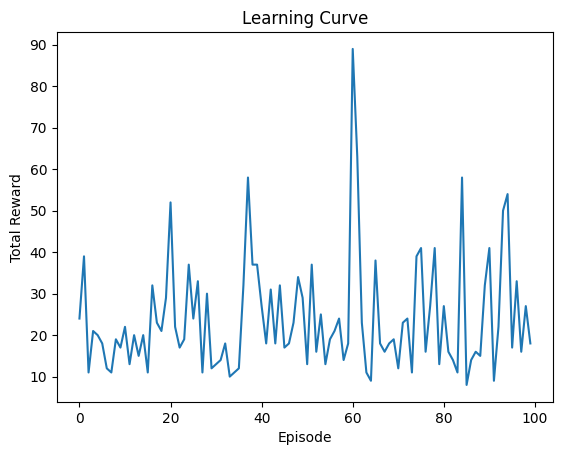

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# !pip install gym
import gym
import matplotlib.pyplot as plt


# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.fc(x)
        return self.softmax(x)

# Define the reinforcement learning algorithm for policy optimization
def policy_optimization(env, policy_net, num_episodes, lr):
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            # Forward pass through the policy network to get action probabilities
            state_tensor = torch.FloatTensor(state)
            action_probs = policy_net(state_tensor)

            # Sample an action from the action probabilities
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs.detach().numpy())

            # Take the action and observe the next state and reward
            next_state, reward, done, _ = env.step(action)

            # Calculate the policy gradient loss
            loss = -torch.log(action_probs[action]) * reward

            # Backpropagate the loss and update the policy network
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Move to the next state
            state = next_state
            total_reward += reward

        rewards.append(total_reward)

        # Print progress
        print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}")

    # Plot rewards over time
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Learning Curve')
    plt.show()

# Example usage
if __name__ == "__main__":
    # Define environment parameters
    input_size = 4  # Example: state space dimension
    output_size = 2  # Example: action space dimension
    num_episodes = 100
    learning_rate = 1e-5

    # Initialize the policy network
    policy_net = PolicyNetwork(input_size, output_size)

    # Initialize the environment (replace this with your specific environment)
    env = gym.make('CartPole-v1')

    # Run the policy optimization algorithm
    policy_optimization(env, policy_net, num_episodes, learning_rate)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Input

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)  # create logits for Ber(p) samples
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)  # Add small epsilon for numerical stability
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)  # s_0
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)  # x_0
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)  # x_0
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)  # x(t) = f(y_{t-1}, s_{t-2})
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def simple_lstm_model(input_shape):
    model = keras.Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(10, return_sequences=True))
    model.add(Dense(1))
    return model

config = {
    'batch_size': 10,
    'bptt': 6
}

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

# Verify data integrity
print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

# Adjust input shapes to match model expectations
x_y_combined = tf.concat([x, y], axis=-1)  # Shape: (batch_size, bptt, 2)

# Initialize the simplified model
input_shape = (config['bptt'], 2)  # Using combined input of x and y
simple_model = simple_lstm_model(input_shape)

# Compile the simplified model with a simple loss function
simple_model.compile(optimizer='adam', loss='mse')

# Example training step (assuming x_y_combined as input and y as target)
simple_model.fit(x_y_combined, y, epochs=200)


x data check: 0 0
y data check: 0 0
Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.6086
Epoch 2/200
1/1 [==============================] - 0s 12ms/step - loss: 0.5980
Epoch 3/200
1/1 [==============================] - 0s 11ms/step - loss: 0.5876
Epoch 4/200
1/1 [==============================] - 0s 12ms/step - loss: 0.5773
Epoch 5/200
1/1 [==============================] - 0s 12ms/step - loss: 0.5672
Epoch 6/200
1/1 [==============================] - 0s 12ms/step - loss: 0.5572
Epoch 7/200
1/1 [==============================] - 0s 11ms/step - loss: 0.5475
Epoch 8/200
1/1 [==============================] - 0s 12ms/step - loss: 0.5378
Epoch 9/200
1/1 [==============================] - 0s 11ms/step - loss: 0.5283
Epoch 10/200
1/1 [==============================] - 0s 12ms/step - loss: 0.5190
Epoch 11/200
1/1 [==============================] - 0s 12ms/step - loss: 0.5098
Epoch 12/200
1/1 [==============================] - 0s 13ms/step - loss: 0.5007
Epoch 13/200
1/

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras import backend as K

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)  # create logits for Ber(p) samples
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)  # Add small epsilon for numerical stability
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)  # s_0
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)  # x_0
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)  # x_0
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)  # x(t) = f(y_{t-1}, s_{t-2})
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

class Model_loss(tf.keras.losses.Loss):
    def __init__(self, subtract=None, name='model_loss', **kwargs):
        super(Model_loss, self).__init__(name=name, reduction='none')
        self.subtract = subtract
        self.loss_fn = {"y": DV_Loss("y"), "xy": DV_Loss("xy")}

    def call(self, t_y, t_xy, **kwargs):
        loss_y = self.loss_fn["y"](t_y[0], t_y[1])
        loss_xy = self.loss_fn["xy"](t_xy[0], t_xy[1])
        if self.subtract is None:  # original DV case - to train each statistics network
            return tf.stack([loss_y, loss_xy], axis=0)
        else:  # encoder case - the difference is the loss
            return loss_xy - loss_y

class DV_Loss(tf.keras.losses.Loss):
    def __init__(self, name='dv_loss'):
        super(DV_Loss, self).__init__(name=name, reduction='none')

    def call(self, t1, t2, **kwargs):
        N = tf.cast(tf.reduce_prod(t1.shape[:-1]), tf.float32)
        N_ref = tf.cast(tf.reduce_prod(t2.shape[:-1]), tf.float32)
        loss_t = K.sum(t1 / (N + 1e-5))  # Add small epsilon for numerical stability
        loss_et = K.sum(t2 / (N_ref + 1e-5))  # Add small epsilon for numerical stability

        print(f"loss_t: {loss_t}, loss_et: {loss_et}")

        loss = -(loss_t - K.log(loss_et + 1e-10))  # Add small epsilon for numerical stability

        print(f"Final loss: {loss}")

        return loss

def complex_lstm_model_v3(input_shape, config):
    randN_05 = keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = Input(shape=input_shape)
    x = LSTM(DV_hidden[0], return_sequences=True, stateful=False, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = keras.models.Model(inputs=inputs, outputs=outputs)

    return model

config = {
    'GE_b': 0.0005,
    'GE_g': 0.0015,
    'GE_p_b': 0.5,
    'GE_p_g': 0.02,
    'T': 3,
    'alphabet_size': 2,
    'batch_size': 10,
    'batch_size_eval': 5000,
    'batches': 15,
    'bptt': 6,
    'channel_name': 'trapdoor',
    'clip_grad_norm': 1,
    'clip_grad_norm_enc': 0.2,
    'clip_grad_norm_q': 100,
    'clip_likelihood_ratio': [-10.0, 10.0],
    'compression_flag': 0,
    'config': './configs/capacity_estimation.json',
    'contrastive_duplicates': 5,
    'data_name': 'encoder',
    'decay': 0,
    'dropout': 0,
    'dtype': 'binary',
    'enc_dropout': 0.0,
    'enc_hidden': [100, 50],
    'enc_hidden_lstm': 50,
    'enc_last_hidden': 1,
    'eta_post': 0.5,
    'eval_epoch_len': 500,
    'eval_freq': 200,
    'exp_name': 'cap_est',
    'feedback': 1,
    'hidden_size': [100, 150, 10],
    'hidden_size_compression': [100, 2, 100],
    'long_eval_epoch_len': 100,
    'lr': 0.0019,
    'lr_SGD': 0.2,
    'max_norm_xy': 5,
    'max_norm_y': 5,
    'model_name': 'cap_est',
    'noise_layer_q_std': 0.05,
    'num_epochs': 80000,
    'optimizer': 'adam',
    'p_bec': 0.3,
    'p_bsc': 0.5,
    'p_ising': 0.5,
    'p_post': 0.5,
    'p_trapdoor': 0.5,
    'p_z': 0.9,
    'q_lstm_units': 25,
    'q_train_freq': 5,
    'quiet': False,
    'reset_channel': 0,
    'run_name': 'ff',
    's_alphabet': 2,
    'seed': 468695,
    'tag_name': 'temp_debugging',
    'tensor_board_dir': './results/cap_est/encoder/ff/temp_debugging/2024-06-17_14-22-31_468695',
    'train_epoch_len': 50,
    'trainer_name': 'cap_est',
    'using_wandb': 0,
    'visualize_epoch_len': 50,
    'weight_decay': 0.0,
    'with_p': 0,
    'x_dim': 1,
    'y_im': 1,
    'lr': 0.00001,  # Further reduced learning rate
    'output_activation': 'linear',  # Add the output activation
}

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

# Verify data integrity
print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

# Adjust input shapes to match model expectations
x_y_combined = tf.concat([x, y], axis=-1)  # Shape: (batch_size, bptt, 2)

# Initialize the more complex model v3
input_shape = (config['bptt'], 2)  # Using combined input of x and y
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

# Initialize the custom loss function
loss_fn = Model_loss()

# Compile the more complex model with the custom loss function and learning rate scheduler
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=config['lr'], clipnorm=1.0)  # Use gradient clipping
complex_model_v3.compile(optimizer=optimizer, loss=loss_fn)

# Learning rate scheduler callback
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

# Example training step with learning rate scheduler
complex_model_v3.fit(x_y_combined, y, epochs=200, callbacks=[callback])


x data check: 0 0
y data check: 0 0

Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 1/200
loss_t: Tensor("model_loss/y/Sum:0", shape=(), dtype=float32), loss_et: Tensor("model_loss/y/Sum_1:0", shape=(), dtype=float32)
Final loss: Tensor("model_loss/y/Neg:0", shape=(), dtype=float32)
loss_t: Tensor("model_loss/xy/Sum:0", shape=(), dtype=float32), loss_et: Tensor("model_loss/xy/Sum_1:0", shape=(), dtype=float32)
Final loss: Tensor("model_loss/xy/Neg:0", shape=(), dtype=float32)
loss_t: Tensor("model_loss/y/Sum:0", shape=(), dtype=float32), loss_et: Tensor("model_loss/y/Sum_1:0", shape=(), dtype=float32)
Final loss: Tensor("model_loss/y/Neg:0", shape=(), dtype=float32)
loss_t: Tensor("model_loss/xy/Sum:0", shape=(), dtype=float32), loss_et: Tensor("model_loss/xy/Sum_1:0", shape=(), dtype=float32)
Final loss: Tensor("model_loss/xy/Neg:0", shape=(), dtype=float32)
1/1 [==============================] - 2s 2s/step - loss: -2.3056 - lr: 1.0000e-05

Epoch 


Epoch 1: LearningRateScheduler setting learning rate to 1.350851789538865e-06.
Epoch 1/200
1/1 [==============================] - 0s 17ms/step - loss: -2.8746 - lr: 1.3509e-06

Epoch 2: LearningRateScheduler setting learning rate to 1.350851789538865e-06.
Epoch 2/200
1/1 [==============================] - 0s 15ms/step - loss: -2.3748 - lr: 1.3509e-06

Epoch 3: LearningRateScheduler setting learning rate to 1.350851789538865e-06.
Epoch 3/200
1/1 [==============================] - 0s 14ms/step - loss: -2.8748 - lr: 1.3509e-06

Epoch 4: LearningRateScheduler setting learning rate to 1.350851789538865e-06.
Epoch 4/200
1/1 [==============================] - 0s 14ms/step - loss: -13.8809 - lr: 1.3509e-06

Epoch 5: LearningRateScheduler setting learning rate to 1.350851789538865e-06.
Epoch 5/200
1/1 [==============================] - 0s 15ms/step - loss: -14.3810 - lr: 1.3509e-06

Epoch 6: LearningRateScheduler setting learning rate to 1.350851789538865e-06.
Epoch 6/200
1/1 [================

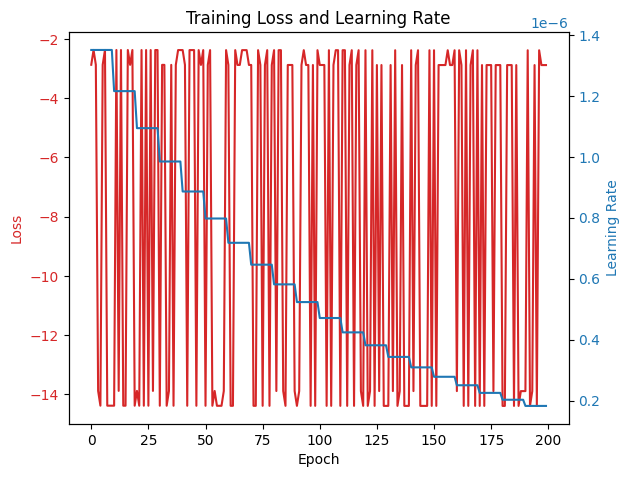

In [ ]:
import matplotlib.pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

# Initialize the LossHistory callback
loss_history = LossHistory()

# Include the LossHistory callback in the callbacks list
callbacks.append(loss_history)

# Fit the model with the callbacks
history = complex_model_v3.fit(x_y_combined, y, epochs=200, callbacks=callbacks)

# Plotting loss and learning rate
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)  # we already handled the x-label with ax1
ax2.plot(range(len(loss_history.lr)), loss_history.lr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Training Loss and Learning Rate')
plt.show()


x data check: 0 0
y data check: 0 0

Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 0.6858 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 2/200
1/1 [==============================] - 0s 15ms/step - loss: 0.6858 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 3/200
1/1 [==============================] - 0s 17ms/step - loss: 0.6858 - lr: 1.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 4/200
1/1 [==============================] - 0s 15ms/step - loss: 0.6858 - lr: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 5/200
1/1 [==============================] - 0s 15ms/step - loss: 0.6857 - lr: 1.0000e-05

Epoch 6: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 

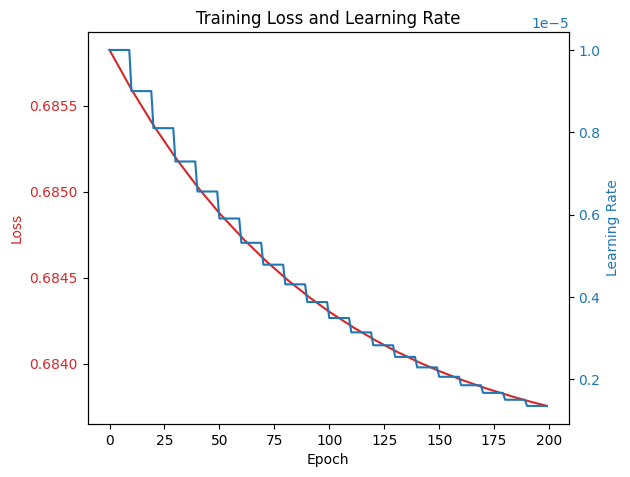

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Input
import matplotlib.pyplot as plt

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)  # create logits for Ber(p) samples
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)  # Add small epsilon for numerical stability
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)  # s_0
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)  # x_0
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)  # x_0
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)  # x(t) = f(y_{t-1}, s_{t-2})
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = Input(shape=input_shape)
    x = LSTM(DV_hidden[0], return_sequences=True, stateful=False, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

# Configuration
config = {
    'GE_b': 0.0005,
    'GE_g': 0.0015,
    'GE_p_b': 0.5,
    'GE_p_g': 0.02,
    'T': 3,
    'alphabet_size': 2,
    'batch_size': 10,
    'batch_size_eval': 5000,
    'batches': 15,
    'bptt': 6,
    'channel_name': 'trapdoor',
    'clip_grad_norm': 1,
    'clip_grad_norm_enc': 0.2,
    'clip_grad_norm_q': 100,
    'clip_likelihood_ratio': [-10.0, 10.0],
    'compression_flag': 0,
    'config': './configs/capacity_estimation.json',
    'contrastive_duplicates': 5,
    'data_name': 'encoder',
    'decay': 0,
    'dropout': 0,
    'dtype': 'binary',
    'enc_dropout': 0.0,
    'enc_hidden': [100, 50],
    'enc_hidden_lstm': 50,
    'enc_last_hidden': 1,
    'eta_post': 0.5,
    'eval_epoch_len': 500,
    'eval_freq': 200,
    'exp_name': 'cap_est',
    'feedback': 1,
    'hidden_size': [100, 150, 10],
    'hidden_size_compression': [100, 2, 100],
    'long_eval_epoch_len': 100,
    'lr': 0.0019,
    'lr_SGD': 0.2,
    'max_norm_xy': 5,
    'max_norm_y': 5,
    'model_name': 'cap_est',
    'noise_layer_q_std': 0.05,
    'num_epochs': 80000,
    'optimizer': 'adam',
    'p_bec': 0.3,
    'p_bsc': 0.5,
    'p_ising': 0.5,
    'p_post': 0.5,
    'p_trapdoor': 0.5,
    'p_z': 0.9,
    'q_lstm_units': 25,
    'q_train_freq': 5,
    'quiet': False,
    'reset_channel': 0,
    'run_name': 'ff',
    's_alphabet': 2,
    'seed': 468695,
    'tag_name': 'temp_debugging',
    'tensor_board_dir': './results/cap_est/encoder/ff/temp_debugging/2024-06-17_14-22-31_468695',
    'train_epoch_len': 50,
    'trainer_name': 'cap_est',
    'using_wandb': 0,
    'visualize_epoch_len': 50,
    'weight_decay': 0.0,
    'with_p': 0,
    'x_dim': 1,
    'y_im': 1,
    'lr': 0.00001,  # Further reduced learning rate
    'output_activation': 'linear',  # Add the output activation
}

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

# Verify data integrity
print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

# Adjust input shapes to match model expectations
x_y_combined = tf.concat([x, y], axis=-1)  # Shape: (batch_size, bptt, 2)

# Initialize the more complex model v3
input_shape = (config['bptt'], 2)  # Using combined input of x and y
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

# Compile the more complex model with MSE loss function and learning rate scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)  # Use gradient clipping
complex_model_v3.compile(optimizer=optimizer, loss='mean_squared_error')

# Learning rate scheduler callback
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

# Initialize the LossHistory callback
loss_history = LossHistory()

# List of callbacks
callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1),
    loss_history
]

# Fit the model with the callbacks
history = complex_model_v3.fit(x_y_combined, y, epochs=200, callbacks=callbacks)

# Plotting loss and learning rate
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)  # we already handled the x-label with ax1
ax2.plot(range(len(loss_history.lr)), loss_history.lr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Training Loss and Learning Rate')
plt.show()


x data check: 0 0
y data check: 0 0

Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 1/600
1/1 [==============================] - 3s 3s/step - loss: 5.0030 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 2/600
1/1 [==============================] - 0s 18ms/step - loss: 5.0016 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 3/600
1/1 [==============================] - 0s 16ms/step - loss: 5.0002 - lr: 1.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 4/600
1/1 [==============================] - 0s 22ms/step - loss: 4.9989 - lr: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 5/600
1/1 [==============================] - 0s 16ms/step - loss: 4.9975 - lr: 1.0000e-05

Epoch 6: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 

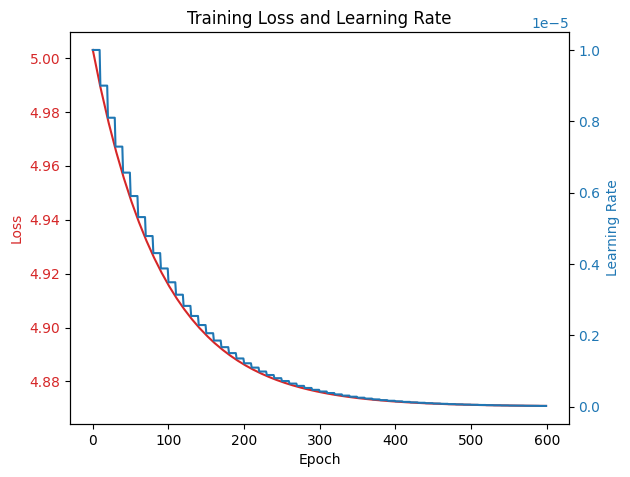

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Input
import matplotlib.pyplot as plt

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)  # create logits for Ber(p) samples
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)  # Add small epsilon for numerical stability
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)  # s_0
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)  # x_0
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)  # x_0
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)  # x(t) = f(y_{t-1}, s_{t-2})
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = Input(shape=input_shape)
    x = LSTM(DV_hidden[0], return_sequences=True, stateful=False, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

# Configuration
config = {
    'GE_b': 0.0005,
    'GE_g': 0.0015,
    'GE_p_b': 0.5,
    'GE_p_g': 0.02,
    'T': 3,
    'alphabet_size': 2,
    'batch_size': 10,
    'batch_size_eval': 5000,
    'batches': 15,
    'bptt': 6,
    'channel_name': 'trapdoor',
    'clip_grad_norm': 1,
    'clip_grad_norm_enc': 0.2,
    'clip_grad_norm_q': 100,
    'clip_likelihood_ratio': [-10.0, 10.0],
    'compression_flag': 0,
    'config': './configs/capacity_estimation.json',
    'contrastive_duplicates': 5,
    'data_name': 'encoder',
    'decay': 0,
    'dropout': 0,
    'dtype': 'binary',
    'enc_dropout': 0.0,
    'enc_hidden': [100, 50],
    'enc_hidden_lstm': 50,
    'enc_last_hidden': 1,
    'eta_post': 0.5,
    'eval_epoch_len': 500,
    'eval_freq': 200,
    'exp_name': 'cap_est',
    'feedback': 1,
    'hidden_size': [100, 150, 10],
    'hidden_size_compression': [100, 2, 100],
    'long_eval_epoch_len': 100,
    'lr': 0.0019,
    'lr_SGD': 0.2,
    'max_norm_xy': 5,
    'max_norm_y': 5,
    'model_name': 'cap_est',
    'noise_layer_q_std': 0.05,
    'num_epochs': 80000,
    'optimizer': 'adam',
    'p_bec': 0.3,
    'p_bsc': 0.5,
    'p_ising': 0.5,
    'p_post': 0.5,
    'p_trapdoor': 0.5,
    'p_z': 0.9,
    'q_lstm_units': 25,
    'q_train_freq': 5,
    'quiet': False,
    'reset_channel': 0,
    'run_name': 'ff',
    's_alphabet': 2,
    'seed': 468695,
    'tag_name': 'temp_debugging',
    'tensor_board_dir': './results/cap_est/encoder/ff/temp_debugging/2024-06-17_14-22-31_468695',
    'train_epoch_len': 50,
    'trainer_name': 'cap_est',
    'using_wandb': 0,
    'visualize_epoch_len': 50,
    'weight_decay': 0.0,
    'with_p': 0,
    'x_dim': 1,
    'y_im': 1,
    'lr': 0.00001,  # Further reduced learning rate
    'output_activation': 'linear',  # Add the output activation
}

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

# Verify data integrity
print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

# Adjust input shapes to match model expectations
x_y_combined = tf.concat([x, y], axis=-1)  # Shape: (batch_size, bptt, 2)

# Initialize the more complex model v3
input_shape = (config['bptt'], 2)  # Using combined input of x and y
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

# Define a combined loss function
def combined_loss(y_true, y_pred):
    mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    kl_loss = tf.keras.losses.KLDivergence()(y_true, y_pred)
    return mse_loss + kl_loss

# Compile the more complex model with combined loss function and learning rate scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)  # Use gradient clipping
complex_model_v3.compile(optimizer=optimizer, loss=combined_loss)

# Learning rate scheduler callback
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Example training step with learning rate scheduler
complex_model_v3.fit(x_y_combined, y, epochs=600, callbacks=[callback, loss_history])

# Plotting loss and learning rate
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)  # we already handled the x-label with ax1
ax2.plot(range(len(loss_history.lr)), loss_history.lr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Training Loss and Learning Rate')
plt.show()


x data check: 0 0
y data check: 0 0

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/600
1/1 [==============================] - 3s 3s/step - loss: 1.8495 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/600
1/1 [==============================] - 0s 19ms/step - loss: 1.7946 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/600
1/1 [==============================] - 0s 23ms/step - loss: 1.7479 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/600
1/1 [==============================] - 0s 23ms/step - loss: 1.7080 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/600
1/1 [==============================] - 0s 16ms/step - loss: 1.6705 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 6/600
1/1 [=========

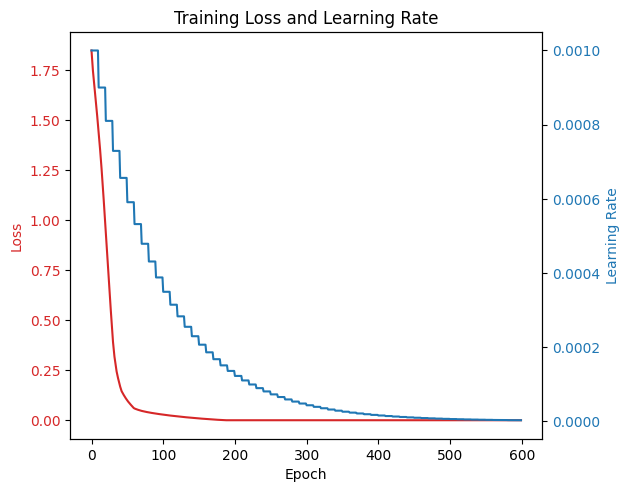

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Input
import matplotlib.pyplot as plt

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)  # create logits for Ber(p) samples
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)  # Add small epsilon for numerical stability
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)  # s_0
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)  # x_0
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)  # x_0
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)  # x(t) = f(y_{t-1}, s_{t-2})
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = Input(shape=input_shape)
    x = LSTM(DV_hidden[0], return_sequences=True, stateful=False, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

# Configuration
config = {
    'GE_b': 0.0005,
    'GE_g': 0.0015,
    'GE_p_b': 0.5,
    'GE_p_g': 0.02,
    'T': 3,
    'alphabet_size': 2,
    'batch_size': 10,
    'batch_size_eval': 5000,
    'batches': 15,
    'bptt': 6,
    'channel_name': 'trapdoor',
    'clip_grad_norm': 1,
    'clip_grad_norm_enc': 0.2,
    'clip_grad_norm_q': 100,
    'clip_likelihood_ratio': [-10.0, 10.0],
    'compression_flag': 0,
    'config': './configs/capacity_estimation.json',
    'contrastive_duplicates': 5,
    'data_name': 'encoder',
    'decay': 0,
    'dropout': 0,
    'dtype': 'binary',
    'enc_dropout': 0.0,
    'enc_hidden': [100, 50],
    'enc_hidden_lstm': 50,
    'enc_last_hidden': 1,
    'eta_post': 0.5,
    'eval_epoch_len': 500,
    'eval_freq': 200,
    'exp_name': 'cap_est',
    'feedback': 1,
    'hidden_size': [100, 150, 10],
    'hidden_size_compression': [100, 2, 100],
    'long_eval_epoch_len': 100,
    'lr': 0.0019,
    'lr_SGD': 0.2,
    'max_norm_xy': 5,
    'max_norm_y': 5,
    'model_name': 'cap_est',
    'noise_layer_q_std': 0.05,
    'num_epochs': 80000,
    'optimizer': 'adam',
    'p_bec': 0.3,
    'p_bsc': 0.5,
    'p_ising': 0.5,
    'p_post': 0.5,
    'p_trapdoor': 0.5,
    'p_z': 0.9,
    'q_lstm_units': 25,
    'q_train_freq': 5,
    'quiet': False,
    'reset_channel': 0,
    'run_name': 'ff',
    's_alphabet': 2,
    'seed': 468695,
    'tag_name': 'temp_debugging',
    'tensor_board_dir': './results/cap_est/encoder/ff/temp_debugging/2024-06-17_14-22-31_468695',
    'train_epoch_len': 50,
    'trainer_name': 'cap_est',
    'using_wandb': 0,
    'visualize_epoch_len': 50,
    'weight_decay': 0.0,
    'with_p': 0,
    'x_dim': 1,
    'y_im': 1,
    'lr': 0.001,  # Further reduced learning rate
    'output_activation': 'linear',  # Add the output activation
}

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

# Verify data integrity
print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

# Adjust input shapes to match model expectations
x_y_combined = tf.concat([x, y], axis=-1)  # Shape: (batch_size, bptt, 2)

# Initialize the more complex model v3
input_shape = (config['bptt'], 2)  # Using combined input of x and y
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

# Compile the more complex model with KL divergence loss function and learning rate scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)  # Use gradient clipping
complex_model_v3.compile(optimizer=optimizer, loss=tf.keras.losses.KLDivergence())

# Learning rate scheduler callback
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Example training step with learning rate scheduler
complex_model_v3.fit(x_y_combined, y, epochs=600, callbacks=[callback, loss_history])

# Plotting loss and learning rate
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)  # we already handled the x-label with ax1
ax2.plot(range(len(loss_history.lr)), loss_history.lr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Training Loss and Learning Rate')
plt.show()


x data check: 0 0
y data check: 0 0

Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/400
1/1 [==============================] - 3s 3s/step - loss: 2.3439 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/400
1/1 [==============================] - 0s 16ms/step - loss: 2.3354 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/400
1/1 [==============================] - 0s 14ms/step - loss: 2.3271 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 4/400
1/1 [==============================] - 0s 14ms/step - loss: 2.3189 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 5/400
1/1 [==============================] - 0s 14ms/step - loss: 2.3109 - lr: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 

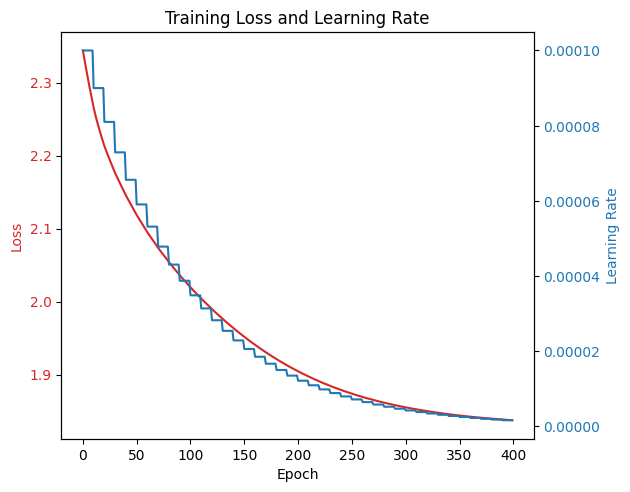

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Input
import matplotlib.pyplot as plt

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)  # create logits for Ber(p) samples
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)  # Add small epsilon for numerical stability
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)  # s_0
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)  # x_0
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)  # x_0
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)  # x(t) = f(y_{t-1}, s_{t-2})
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = Input(shape=input_shape)
    x = LSTM(DV_hidden[0], return_sequences=True, stateful=False, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

# Configuration
config = {
    'GE_b': 0.0005,
    'GE_g': 0.0015,
    'GE_p_b': 0.5,
    'GE_p_g': 0.02,
    'T': 3,
    'alphabet_size': 2,
    'batch_size': 10,
    'batch_size_eval': 5000,
    'batches': 15,
    'bptt': 6,
    'channel_name': 'trapdoor',
    'clip_grad_norm': 1,
    'clip_grad_norm_enc': 0.2,
    'clip_grad_norm_q': 100,
    'clip_likelihood_ratio': [-10.0, 10.0],
    'compression_flag': 0,
    'config': './configs/capacity_estimation.json',
    'contrastive_duplicates': 5,
    'data_name': 'encoder',
    'decay': 0,
    'dropout': 0,
    'dtype': 'binary',
    'enc_dropout': 0.0,
    'enc_hidden': [100, 50],
    'enc_hidden_lstm': 50,
    'enc_last_hidden': 1,
    'eta_post': 0.5,
    'eval_epoch_len': 500,
    'eval_freq': 200,
    'exp_name': 'cap_est',
    'feedback': 1,
    'hidden_size': [100, 150, 10],
    'hidden_size_compression': [100, 2, 100],
    'long_eval_epoch_len': 100,
    'lr': 0.0019,
    'lr_SGD': 0.2,
    'max_norm_xy': 5,
    'max_norm_y': 5,
    'model_name': 'cap_est',
    'noise_layer_q_std': 0.05,
    'num_epochs': 80000,
    'optimizer': 'adam',
    'p_bec': 0.3,
    'p_bsc': 0.5,
    'p_ising': 0.5,
    'p_post': 0.5,
    'p_trapdoor': 0.5,
    'p_z': 0.9,
    'q_lstm_units': 25,
    'q_train_freq': 5,
    'quiet': False,
    'reset_channel': 0,
    'run_name': 'ff',
    's_alphabet': 2,
    'seed': 468695,
    'tag_name': 'temp_debugging',
    'tensor_board_dir': './results/cap_est/encoder/ff/temp_debugging/2024-06-17_14-22-31_468695',
    'train_epoch_len': 50,
    'trainer_name': 'cap_est',
    'using_wandb': 0,
    'visualize_epoch_len': 50,
    'weight_decay': 0.0,
    'with_p': 0,
    'x_dim': 1,
    'y_im': 1,
    'lr': 0.0001,  # Further reduced learning rate more further
    'output_activation': 'linear',  # Add the output activation
}

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

# Verify data integrity
print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

# Adjust input shapes to match model expectations
x_y_combined = tf.concat([x, y], axis=-1)  # Shape: (batch_size, bptt, 2)

# Initialize the more complex model v3
input_shape = (config['bptt'], 2)  # Using combined input of x and y
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

# Compile the more complex model with KL divergence loss function and learning rate scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)  # Use gradient clipping
complex_model_v3.compile(optimizer=optimizer, loss=tf.keras.losses.KLDivergence())

# Learning rate scheduler callback
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Example training step with learning rate scheduler
complex_model_v3.fit(x_y_combined, y, epochs=400, callbacks=[callback, loss_history])

# Plotting loss and learning rate
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)  # we already handled the x-label with ax1
ax2.plot(range(len(loss_history.lr)), loss_history.lr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Training Loss and Learning Rate')
plt.show()


x data check: 0 0
y data check: 0 0

Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 1/250


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1/1 [==============================] - 5s 5s/step - loss: 0.1471 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 2/250
1/1 [==============================] - 0s 16ms/step - loss: 0.1470 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 3/250
1/1 [==============================] - 0s 15ms/step - loss: 0.1470 - lr: 1.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 4/250
1/1 [==============================] - 0s 14ms/step - loss: 0.1470 - lr: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 5/250
1/1 [==============================] - 0s 15ms/step - loss: 0.1470 - lr: 1.0000e-05

Epoch 6: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 6/250
1/1 [==============================] - 0s 14ms/step - loss: 0.1470 - lr: 1.0000e-05

Epoch 7: LearningRateScheduler settin

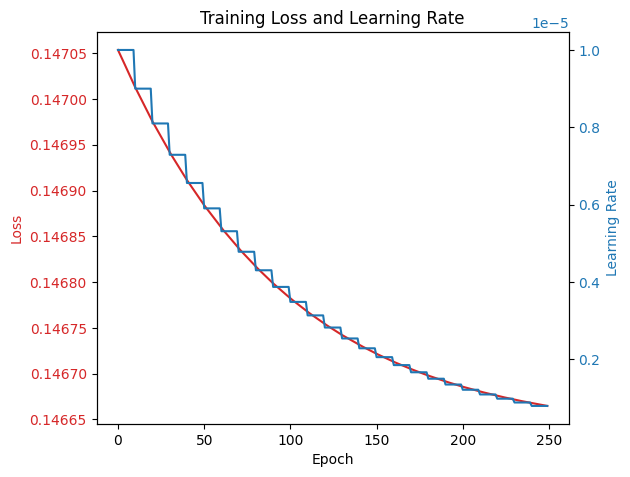

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Input
import matplotlib.pyplot as plt

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)  # create logits for Ber(p) samples
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)  # Add small epsilon for numerical stability
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)  # s_0
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)  # x_0
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)  # x_0
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)  # x(t) = f(y_{t-1}, s_{t-2})
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = Input(shape=input_shape)
    x = LSTM(DV_hidden[0], return_sequences=True, stateful=False, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

# Configuration
config = {
    'GE_b': 0.0005,
    'GE_g': 0.0015,
    'GE_p_b': 0.5,
    'GE_p_g': 0.02,
    'T': 3,
    'alphabet_size': 2,
    'batch_size': 10,
    'batch_size_eval': 5000,
    'batches': 15,
    'bptt': 6,
    'channel_name': 'trapdoor',
    'clip_grad_norm': 1,
    'clip_grad_norm_enc': 0.2,
    'clip_grad_norm_q': 100,
    'clip_likelihood_ratio': [-10.0, 10.0],
    'compression_flag': 0,
    'config': './configs/capacity_estimation.json',
    'contrastive_duplicates': 5,
    'data_name': 'encoder',
    'decay': 0,
    'dropout': 0,
    'dtype': 'binary',
    'enc_dropout': 0.0,
    'enc_hidden': [100, 50],
    'enc_hidden_lstm': 50,
    'enc_last_hidden': 1,
    'eta_post': 0.5,
    'eval_epoch_len': 500,
    'eval_freq': 200,
    'exp_name': 'cap_est',
    'feedback': 1,
    'hidden_size': [100, 150, 10],
    'hidden_size_compression': [100, 2, 100],
    'long_eval_epoch_len': 100,
    'lr': 0.0019,
    'lr_SGD': 0.2,
    'max_norm_xy': 5,
    'max_norm_y': 5,
    'model_name': 'cap_est',
    'noise_layer_q_std': 0.05,
    'num_epochs': 80000,
    'optimizer': 'adam',
    'p_bec': 0.3,
    'p_bsc': 0.5,
    'p_ising': 0.5,
    'p_post': 0.5,
    'p_trapdoor': 0.5,
    'p_z': 0.9,
    'q_lstm_units': 25,
    'q_train_freq': 5,
    'quiet': False,
    'reset_channel': 0,
    'run_name': 'ff',
    's_alphabet': 2,
    'seed': 468695,
    'tag_name': 'temp_debugging',
    'tensor_board_dir': './results/cap_est/encoder/ff/temp_debugging/2024-06-17_14-22-31_468695',
    'train_epoch_len': 50,
    'trainer_name': 'cap_est',
    'using_wandb': 0,
    'visualize_epoch_len': 50,
    'weight_decay': 0.0,
    'with_p': 0,
    'x_dim': 1,
    'y_im': 1,
    'lr': 0.00001,  # Further reduced learning rate
    'output_activation': 'linear',  # Add the output activation
}

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

# Verify data integrity
print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

# Adjust input shapes to match model expectations
x_y_combined = tf.concat([x, y], axis=-1)  # Shape: (batch_size, bptt, 2)

# Initialize the more complex model v3
input_shape = (config['bptt'], 2)  # Using combined input of x and y
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

# Compile the more complex model with Huber loss function and learning rate scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)  # Use gradient clipping
complex_model_v3.compile(optimizer=optimizer, loss=tf.keras.losses.Huber())

# Learning rate scheduler callback
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Example training step with learning rate scheduler
complex_model_v3.fit(x_y_combined, y, epochs=250, callbacks=[callback, loss_history])

# Plotting loss and learning rate
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)  # we already handled the x-label with ax1
ax2.plot(range(len(loss_history.lr)), loss_history.lr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Training Loss and Learning Rate')
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import CategoricalCrossentropy
import logging
import math
import matplotlib.pyplot as plt

logger = logging.getLogger("logger")

class ModelMetrics(tf.keras.metrics.Metric):
    def __init__(self, writer, name='', **kwargs):
        super(ModelMetrics, self).__init__(name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            DI_bits(name='di_bits')]

    def update_state(self, t_y, t_xy, **kwargs):
        t_y = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_y]
        t_xy = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_xy]

        if not isinstance(t_y, (list, tuple)) or len(t_y) < 2:
            raise ValueError("Invalid t_y format. Expected lists with at least two elements.")
        if not isinstance(t_xy, (list, tuple)) or len(t_xy) < 2:
            raise ValueError("Invalid t_xy format. Expected lists with at least two elements.")

        self.metric_pool[0].update_state(t_xy[0], t_xy[1])
        self.metric_pool[1].update_state(t_y[0], t_y[1])
        self.metric_pool[2].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])
        self.metric_pool[3].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class DV(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DV, self).__init__(name=name, **kwargs)
        self.T = self.add_weight(name='t', initializer='zeros')
        self.exp_T_bar = self.add_weight(name='exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, T, T_bar, **kwargs):
        self.T.assign_add(tf.reduce_sum(T))
        self.exp_T_bar.assign_add(tf.reduce_sum(T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss = self.T / self.global_counter - K.log(self.exp_T_bar / self.global_counter_ref)
        return loss

class DI(tf.keras.metrics.Metric):  # estimated DI calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DI, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return loss_xy - loss_y

class DI_bits(tf.keras.metrics.Metric):  # estimated DI calculation metric class in bits
    def __init__(self, name='dv_loss', **kwargs):
        super(DI_bits, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return (loss_xy - loss_y) / math.log(2)

class PMF(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(PMF, self).__init__(name=name, **kwargs)
        self.p = self.add_weight(name='p', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')

    def update_state(self, p, **kwargs):
        self.p.assign_add(tf.reduce_sum(p))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(p.shape[:-1]), dtype=tf.float32))

    def result(self):
        result = self.p / self.global_counter
        return result

class ModelWithEncMetrics(ModelMetrics):
    def __init__(self, writer, name='', **kwargs):
        super(ModelWithEncMetrics, self).__init__(writer=writer, name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            PMF(name='p_mean'),
                            DI_bits(name='di_bits_{}'.format(name))]

    def update_state(self, data, **kwargs):
        [t_y, t_xy, p] = data
        self.metric_pool[0].update_state(t_xy, t_xy)
        self.metric_pool[1].update_state(t_y, t_y)
        self.metric_pool[2].update_state(t_y, t_y, t_xy, t_xy)
        self.metric_pool[3].update_state(p)
        self.metric_pool[4].update_state(t_y, t_y, t_xy, t_xy)

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class CapEstDI(object):
    def __init__(self, model, data, config):
        self.model = model
        self.data_iterators = data
        self.config = config
        self.loss_fn = tf.keras.losses.Huber()
        self.learning_rate = config['lr']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.metrics = ModelWithEncMetrics(tf.summary.create_file_writer(config['tensor_board_dir']), name='cap_est_metrics')
        self.feedback = (config['feedback'] == 1)
        self.T = config['T']

    def train_epoch(self, epoch):
        self.metrics.reset_states()
        self.reset_model_states()

        for _ in range(self.config['batches']):
            x, y = self.data_iterators.gen_data()
            x_y_combined = tf.concat([x, y], axis=-1)
            with tf.GradientTape() as tape:
                predictions = self.model(x_y_combined, training=True)
                loss = self.loss_fn(y, predictions)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            self.metrics.update_state([loss, loss, tf.zeros_like(loss)])

        self.metrics.log_metrics(epoch, model_name="Training")

    def evaluate(self, epoch):
        self.metrics.reset_states()
        x, y = self.data_iterators.gen_data()
        x_y_combined = tf.concat([x, y], axis=-1)
        predictions = self.model(x_y_combined, training=False)
        loss = self.loss_fn(y, predictions)
        self.metrics.update_state([loss, loss, tf.zeros_like(loss)])
        self.metrics.log_metrics(epoch, model_name="Evaluation")

    def train(self):
        for epoch in range(self.config['num_epochs']):
            if epoch % self.config['eval_freq'] == 0:
                self.evaluate(epoch)
            self.train_epoch(epoch)

        self.evaluate(self.config['num_epochs'])

    def reset_model_states(self):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states') and layer.stateful:
                layer.reset_states()

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = tf.keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = tf.keras.Input(shape=input_shape, batch_size=config['batch_size'])
    x = tf.keras.layers.LSTM(DV_hidden[0], return_sequences=True, stateful=True, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = tf.keras.layers.Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = tf.keras.layers.Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = tf.keras.layers.Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

x_y_combined = tf.concat([x, y], axis=-1)

input_shape = (config['bptt'], 2)
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)
complex_model_v3.compile(optimizer=optimizer, loss=tf.keras.losses.Huber())

def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Train the model to capture the loss history
complex_model_v3.fit(x_y_combined, y, epochs=1, batch_size=config['batch_size'], callbacks=[callback, loss_history])

# Initialize metrics
writer = tf.summary.create_file_writer(config['tensor_board_dir'])
metrics = ModelWithEncMetrics(writer, name='training_metrics')

# Initialize the capacity estimation object
capacity_estimator = CapEstDI(complex_model_v3, ising_data, config)

# Training loop with learning rate scheduler
for epoch in range(config['num_epochs']):
    capacity_estimator.train_epoch(epoch)
    metrics.update_state([tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.zeros_like(tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32))])
    metrics.log_metrics(epoch, model_name='Training')

    if epoch % config['eval_freq'] == 0:
        capacity_estimator.evaluate(epoch)

# Plotting loss and learning rate
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(range(len(loss_history.lr)), loss_history.lr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Learning Rate')
plt.show()


x data check: 0 0
y data check: 0 0

Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
1/1 [==============================] - 3s 3s/step - loss: 0.1961 - lr: 1.0000e-05


KeyboardInterrupt: 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import logging
import math
import matplotlib.pyplot as plt

logger = logging.getLogger("logger")

class ModelMetrics(tf.keras.metrics.Metric):
    def __init__(self, writer, name='', **kwargs):
        super(ModelMetrics, self).__init__(name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            DI_bits(name='di_bits')]
        self.capacity_estimates = []
        self.dine_estimates = []
        self.information_rates = []

    def update_state(self, t_y, t_xy, **kwargs):
        t_y = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_y]
        t_xy = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_xy]

        if not isinstance(t_y, (list, tuple)) or len(t_y) < 2:
            raise ValueError("Invalid t_y format. Expected lists with at least two elements.")
        if not isinstance(t_xy, (list, tuple)) or len(t_xy) < 2:
            raise ValueError("Invalid t_xy format. Expected lists with at least two elements.")

        self.metric_pool[0].update_state(t_xy[0], t_xy[1])
        self.metric_pool[1].update_state(t_y[0], t_y[1])
        self.metric_pool[2].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])
        self.metric_pool[3].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        results = self.result()
        self.capacity_estimates.append(results[0].numpy())
        self.dine_estimates.append(results[2].numpy())
        self.information_rates.append(results[4].numpy())

        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

    def plot_metrics(self):
        epochs = range(len(self.capacity_estimates))

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.plot(epochs, self.capacity_estimates, label='Capacity Estimate')
        plt.xlabel('Epoch')
        plt.ylabel('Capacity Estimate')
        plt.title('Capacity Estimate over Epochs')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.dine_estimates, label='DINE Estimate', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('DINE Estimate')
        plt.title('DINE Estimate over Epochs')
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.information_rates, label='Information Rate', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('Information Rate')
        plt.title('Information Rate over Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()

class DV(tf.keras.metrics.Metric):
    def __init__(self, name='dv_loss', **kwargs):
        super(DV, self).__init__(name=name, **kwargs)
        self.T = self.add_weight(name='t', initializer='zeros')
        self.exp_T_bar = self.add_weight(name='exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, T, T_bar, **kwargs):
        self.T.assign_add(tf.reduce_sum(T))
        self.exp_T_bar.assign_add(tf.reduce_sum(T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss = self.T / self.global_counter - K.log(self.exp_T_bar / self.global_counter_ref)
        return loss

class DI(tf.keras.metrics.Metric):
    def __init__(self, name='dv_loss', **kwargs):
        super(DI, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return loss_xy - loss_y

class DI_bits(tf.keras.metrics.Metric):
    def __init__(self, name='dv_loss', **kwargs):
        super(DI_bits, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return (loss_xy - loss_y) / math.log(2)

class PMF(tf.keras.metrics.Metric):
    def __init__(self, name='dv_loss', **kwargs):
        super(PMF, self).__init__(name=name, **kwargs)
        self.p = self.add_weight(name='p', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')

    def update_state(self, p, **kwargs):
        self.p.assign_add(tf.reduce_sum(p))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(p.shape[:-1]), dtype=tf.float32))

    def result(self):
        result = self.p / self.global_counter
        return result

class ModelWithEncMetrics(ModelMetrics):
    def __init__(self, writer, name='', **kwargs):
        super(ModelWithEncMetrics, self).__init__(writer=writer, name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            PMF(name='p_mean'),
                            DI_bits(name='di_bits_{}'.format(name))]

    def update_state(self, data, **kwargs):
        [t_y, t_xy, p] = data
        self.metric_pool[0].update_state(t_xy, t_xy)
        self.metric_pool[1].update_state(t_y, t_y)
        self.metric_pool[2].update_state(t_y, t_y, t_xy, t_xy)
        self.metric_pool[3].update_state(p)
        self.metric_pool[4].update_state(t_y, t_y, t_xy, t_xy)

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        results = self.result()
        self.capacity_estimates.append(results[0].numpy())
        self.dine_estimates.append(results[2].numpy())
        self.information_rates.append(results[4].numpy())

        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

    def plot_metrics(self):
        epochs = range(len(self.capacity_estimates))

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.plot(epochs, self.capacity_estimates, label='Capacity Estimate')
        plt.xlabel('Epoch')
        plt.ylabel('Capacity Estimate')
        plt.title('Capacity Estimate over Epochs')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.dine_estimates, label='DINE Estimate', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('DINE Estimate')
        plt.title('DINE Estimate over Epochs')
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.information_rates, label='Information Rate', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('Information Rate')
        plt.title('Information Rate over Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()

class CapEstDI(object):
    def __init__(self, model, data, config):
        self.model = model
        self.data_iterators = data
        self.config = config
        self.loss_fn = tf.keras.losses.Huber()
        self.learning_rate = config['lr']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.metrics = ModelWithEncMetrics(tf.summary.create_file_writer(config['tensor_board_dir']), name='cap_est_metrics')
        self.feedback = (config['feedback'] == 1)
        self.T = config['T']

    def train_epoch(self, epoch):
        self.metrics.reset_states()
        self.reset_model_states()

        for _ in range(self.config['batches']):
            x, y = self.data_iterators.gen_data()
            x_y_combined = tf.concat([x, y], axis=-1)
            with tf.GradientTape() as tape:
                predictions = self.model(x_y_combined, training=True)
                loss = self.loss_fn(y, predictions)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            self.metrics.update_state([loss, loss, tf.zeros_like(loss)])

        self.metrics.log_metrics(epoch, model_name="Training")

    def evaluate(self, epoch):
        self.metrics.reset_states()
        x, y = self.data_iterators.gen_data()
        x_y_combined = tf.concat([x, y], axis=-1)
        predictions = self.model(x_y_combined, training=False)
        loss = self.loss_fn(y, predictions)
        self.metrics.update_state([loss, loss, tf.zeros_like(loss)])
        self.metrics.log_metrics(epoch, model_name="Evaluation")

    def train(self, num_epochs=None):
        if num_epochs is None:
            num_epochs = self.config.get('num_epochs', 200)

        for epoch in range(num_epochs):
            if epoch % self.config['eval_freq'] == 0:
                self.evaluate(epoch)
            self.train_epoch(epoch)

        self.evaluate(num_epochs)

    def reset_model_states(self):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states') and layer.stateful:
                layer.reset_states()

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = tf.keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = tf.keras.Input(shape=input_shape, batch_size=config['batch_size'])
    x = tf.keras.layers.LSTM(DV_hidden[0], return_sequences=True, stateful=True, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = tf.keras.layers.Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = tf.keras.layers.Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = tf.keras.layers.Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

x_y_combined = tf.concat([x, y], axis=-1)

input_shape = (config['bptt'], 2)
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)
complex_model_v3.compile(optimizer=optimizer, loss=tf.keras.losses.Huber())

def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Train the model to capture the loss history
complex_model_v3.fit(x_y_combined, y, epochs=config['num_epochs'], batch_size=config['batch_size'], callbacks=[callback, loss_history])

# Initialize metrics
writer = tf.summary.create_file_writer(config['tensor_board_dir'])
metrics = ModelWithEncMetrics(writer, name='training_metrics')

# Initialize the capacity estimation object
capacity_estimator = CapEstDI(complex_model_v3, ising_data, config)

# Training loop with learning rate scheduler
for epoch in range(config['num_epochs']):
    capacity_estimator.train_epoch(epoch)
    metrics.update_state([tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.zeros_like(tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32))])
    metrics.log_metrics(epoch, model_name='Training')

    if epoch % config['eval_freq'] == 0:
        capacity_estimator.evaluate(epoch)

# Plotting loss and learning rate
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(range(len(loss_history.lr)), loss_history.lr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Learning Rate')
plt.show()

# Plot capacity estimates, DINE estimates, and information rates
metrics.plot_metrics()


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 16ms/step - loss: 0.0489 - lr: 3.4581e-34

Epoch 6229: LearningRateScheduler setting learning rate to 3.458128974321508e-34.
Epoch 6229/80000
1/1 [==============================] - 0s 16ms/step - loss: 0.0489 - lr: 3.4581e-34

Epoch 6230: LearningRateScheduler setting learning rate to 3.458128974321508e-34.
Epoch 6230/80000
1/1 [==============================] - 0s 18ms/step - loss: 0.0489 - lr: 3.4581e-34

Epoch 6231: LearningRateScheduler setting learning rate to 3.1123160768893574e-34.
Epoch 6231/80000
1/1 [==============================] - 0s 18ms/step - loss: 0.0489 - lr: 3.1123e-34

Epoch 6232: LearningRateScheduler setting learning rate to 3.112315985053861e-34.
Epoch 6232/80000
1/1 [==============================] - 0s 21ms/step - loss: 0.0489 - lr: 3.1123e-34

Epoch 6233: LearningRateScheduler setting learning rate to 3.112315985053861e-34.
Epoch 6233/80000
1/1 [=======================

KeyboardInterrupt: 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import CategoricalCrossentropy
import logging
import math
import matplotlib.pyplot as plt

logger = logging.getLogger("logger")

class ModelMetrics(tf.keras.metrics.Metric):
    def __init__(self, writer, name='', **kwargs):
        super(ModelMetrics, self).__init__(name=name, **kwargs)
        self.writer = writer
        self.capacity_estimates = []
        self.dine_estimates = []
        self.information_rates = []
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            DI_bits(name='di_bits')]

    def update_state(self, t_y, t_xy, **kwargs):
        t_y = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_y]
        t_xy = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_xy]

        if not isinstance(t_y, (list, tuple)) or len(t_y) < 2:
            raise ValueError("Invalid t_y format. Expected lists with at least two elements.")
        if not isinstance(t_xy, (list, tuple)) or len(t_xy) < 2:
            raise ValueError("Invalid t_xy format. Expected lists with at least two elements.")

        self.metric_pool[0].update_state(t_xy[0], t_xy[1])
        self.metric_pool[1].update_state(t_y[0], t_y[1])
        self.metric_pool[2].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])
        self.metric_pool[3].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        results = self.result()
        self.capacity_estimates.append(results[0].numpy())
        self.dine_estimates.append(results[2].numpy())
        self.information_rates.append(results[3].numpy())

        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

    def plot_metrics(self):
        epochs = range(len(self.capacity_estimates))

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.plot(epochs, self.capacity_estimates, label='Capacity Estimate')
        plt.xlabel('Epoch')
        plt.ylabel('Capacity Estimate')
        plt.title('Capacity Estimate over Epochs')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.dine_estimates, label='DINE Estimate', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('DINE Estimate')
        plt.title('DINE Estimate over Epochs')
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.information_rates, label='Information Rate', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('Information Rate')
        plt.title('Information Rate over Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()

class DV(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DV, self).__init__(name=name, **kwargs)
        self.T = self.add_weight(name='t', initializer='zeros')
        self.exp_T_bar = self.add_weight(name='exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, T, T_bar, **kwargs):
        self.T.assign_add(tf.reduce_sum(T))
        self.exp_T_bar.assign_add(tf.reduce_sum(T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss = self.T / self.global_counter - K.log(self.exp_T_bar / self.global_counter_ref)
        return loss

class DI(tf.keras.metrics.Metric):  # estimated DI calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DI, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return loss_xy - loss_y

class DI_bits(tf.keras.metrics.Metric):  # estimated DI calculation metric class in bits
    def __init__(self, name='dv_loss', **kwargs):
        super(DI_bits, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return (loss_xy - loss_y) / math.log(2)

class PMF(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(PMF, self).__init__(name=name, **kwargs)
        self.p = self.add_weight(name='p', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')

    def update_state(self, p, **kwargs):
        self.p.assign_add(tf.reduce_sum(p))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(p.shape[:-1]), dtype=tf.float32))

    def result(self):
        result = self.p / self.global_counter
        return result

class ModelWithEncMetrics(ModelMetrics):
    def __init__(self, writer, name='', **kwargs):
        super(ModelWithEncMetrics, self).__init__(writer=writer, name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            PMF(name='p_mean'),
                            DI_bits(name='di_bits_{}'.format(name))]

    def update_state(self, data, **kwargs):
        [t_y, t_xy, p] = data
        self.metric_pool[0].update_state(t_xy, t_xy)
        self.metric_pool[1].update_state(t_y, t_y)
        self.metric_pool[2].update_state(t_y, t_y, t_xy, t_xy)
        self.metric_pool[3].update_state(p)
        self.metric_pool[4].update_state(t_y, t_y, t_xy, t_xy)

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

    def plot_metrics(self):
        epochs = range(len(self.capacity_estimates))

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.plot(epochs, self.capacity_estimates, label='Capacity Estimate')
        plt.xlabel('Epoch')
        plt.ylabel('Capacity Estimate')
        plt.title('Capacity Estimate over Epochs')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.dine_estimates, label='DINE Estimate', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('DINE Estimate')
        plt.title('DINE Estimate over Epochs')
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.information_rates, label='Information Rate', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('Information Rate')
        plt.title('Information Rate over Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()

class CapEstDI(object):
    def __init__(self, model, data, config):
        self.model = model
        self.data_iterators = data
        self.config = config
        self.loss_fn = tf.keras.losses.Huber()
        self.learning_rate = config['lr']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.metrics = ModelWithEncMetrics(tf.summary.create_file_writer(config['tensor_board_dir']), name='cap_est_metrics')
        self.feedback = (config['feedback'] == 1)
        self.T = config['T']

    def train_epoch(self, epoch):
        self.metrics.reset_states()
        self.reset_model_states()

        for _ in range(self.config['batches']):
            x, y = self.data_iterators.gen_data()
            x_y_combined = tf.concat([x, y], axis=-1)
            with tf.GradientTape() as tape:
                predictions = self.model(x_y_combined, training=True)
                loss = self.loss_fn(y, predictions)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            self.metrics.update_state([loss, loss, tf.zeros_like(loss)])

        self.metrics.log_metrics(epoch, model_name="Training")

    def evaluate(self, epoch):
        self.metrics.reset_states()
        x, y = self.data_iterators.gen_data()
        x_y_combined = tf.concat([x, y], axis=-1)
        predictions = self.model(x_y_combined, training=False)
        loss = self.loss_fn(y, predictions)
        self.metrics.update_state([loss, loss, tf.zeros_like(loss)])
        self.metrics.log_metrics(epoch, model_name="Evaluation")

    def train(self, num_epochs):
        for epoch in range(num_epochs):
            if epoch % self.config['eval_freq'] == 0:
                self.evaluate(epoch)
            self.train_epoch(epoch)

        self.evaluate(num_epochs)
        self.metrics.plot_metrics()

    def reset_model_states(self):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states') and layer.stateful:
                layer.reset_states()

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = tf.keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = tf.keras.Input(shape=input_shape, batch_size=config['batch_size'])
    x = tf.keras.layers.LSTM(DV_hidden[0], return_sequences=True, stateful=True, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = tf.keras.layers.Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = tf.keras.layers.Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = tf.keras.layers.Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

x_y_combined = tf.concat([x, y], axis=-1)

input_shape = (config['bptt'], 2)
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)
complex_model_v3.compile(optimizer=optimizer, loss=tf.keras.losses.Huber())

def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Train the model to capture the loss history
complex_model_v3.fit(x_y_combined, y, epochs=config['num_epochs'], batch_size=config['batch_size'], callbacks=[callback, loss_history])

# Initialize metrics
writer = tf.summary.create_file_writer(config['tensor_board_dir'])
metrics = ModelWithEncMetrics(writer, name='training_metrics')

# Initialize the capacity estimation object
capacity_estimator = CapEstDI(complex_model_v3, ising_data, config)

# Training loop with learning rate scheduler
capacity_estimator.train(config['num_epochs'])

# Plotting loss and learning rate
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(range(len(loss_history.lr)), loss_history.lr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Learning Rate')
plt.show()

metrics.plot_metrics()


NameError: name 'config' is not defined

x data check: 0 0
y data check: 0 0

Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.2448 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 2/200
1/1 [==============================] - 0s 15ms/step - loss: 0.2448 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 3/200
1/1 [==============================] - 0s 13ms/step - loss: 0.2448 - lr: 1.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 4/200
1/1 [==============================] - 0s 14ms/step - loss: 0.2448 - lr: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 5/200
1/1 [==============================] - 0s 14ms/step - loss: 0.2448 - lr: 1.0000e-05

Epoch 6: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 

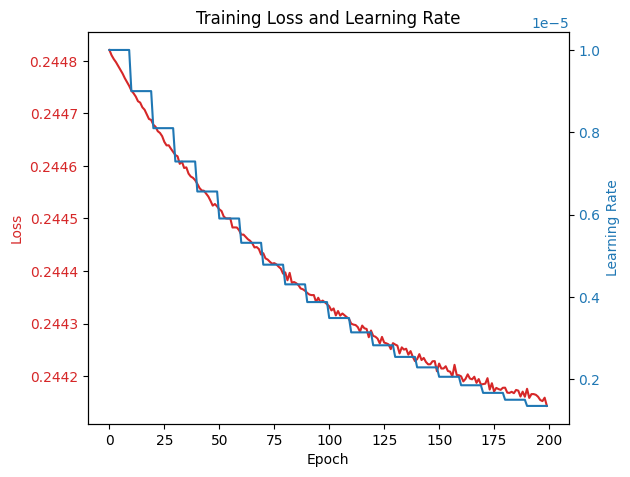

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import CategoricalCrossentropy
import logging
import math
import matplotlib.pyplot as plt

logger = logging.getLogger("logger")

class ModelMetrics(tf.keras.metrics.Metric):
    def __init__(self, writer, name='', **kwargs):
        super(ModelMetrics, self).__init__(name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            DI_bits(name='di_bits')]

    def update_state(self, t_y, t_xy, **kwargs):
        t_y = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_y]
        t_xy = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_xy]

        if not isinstance(t_y, (list, tuple)) or len(t_y) < 2:
            raise ValueError("Invalid t_y format. Expected lists with at least two elements.")
        if not isinstance(t_xy, (list, tuple)) or len(t_xy) < 2:
            raise ValueError("Invalid t_xy format. Expected lists with at least two elements.")

        self.metric_pool[0].update_state(t_xy[0], t_xy[1])
        self.metric_pool[1].update_state(t_y[0], t_y[1])
        self.metric_pool[2].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])
        self.metric_pool[3].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class DV(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DV, self).__init__(name=name, **kwargs)
        self.T = self.add_weight(name='t', initializer='zeros')
        self.exp_T_bar = self.add_weight(name='exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, T, T_bar, **kwargs):
        self.T.assign_add(tf.reduce_sum(T))
        self.exp_T_bar.assign_add(tf.reduce_sum(T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss = self.T / self.global_counter - K.log(self.exp_T_bar / self.global_counter_ref)
        return loss

class DI(tf.keras.metrics.Metric):  # estimated DI calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DI, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return loss_xy - loss_y

class DI_bits(tf.keras.metrics.Metric):  # estimated DI calculation metric class in bits
    def __init__(self, name='dv_loss', **kwargs):
        super(DI_bits, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return (loss_xy - loss_y) / math.log(2)

class PMF(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(PMF, self).__init__(name=name, **kwargs)
        self.p = self.add_weight(name='p', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')

    def update_state(self, p, **kwargs):
        self.p.assign_add(tf.reduce_sum(p))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(p.shape[:-1]), dtype=tf.float32))

    def result(self):
        result = self.p / self.global_counter
        return result

class ModelWithEncMetrics(ModelMetrics):
    def __init__(self, writer, name='', **kwargs):
        super(ModelWithEncMetrics, self).__init__(writer=writer, name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            PMF(name='p_mean'),
                            DI_bits(name='di_bits_{}'.format(name))]

    def update_state(self, data, **kwargs):
        [t_y, t_xy, p] = data
        self.metric_pool[0].update_state(t_xy, t_xy)
        self.metric_pool[1].update_state(t_y, t_y)
        self.metric_pool[2].update_state(t_y, t_y, t_xy, t_xy)
        self.metric_pool[3].update_state(p)
        self.metric_pool[4].update_state(t_y, t_y, t_xy, t_xy)

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class CapEstDI(object):
    def __init__(self, model, data, config):
        self.model = model
        self.data_iterators = data
        self.config = config
        self.loss_fn = tf.keras.losses.Huber()
        self.learning_rate = config['lr']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.metrics = ModelWithEncMetrics(tf.summary.create_file_writer(config['tensor_board_dir']), name='cap_est_metrics')
        self.feedback = (config['feedback'] == 1)
        self.T = config['T']

    def train_epoch(self, epoch):
        self.metrics.reset_states()
        self.reset_model_states()

        for _ in range(self.config['batches']):
            x, y = self.data_iterators.gen_data()
            x_y_combined = tf.concat([x, y], axis=-1)
            with tf.GradientTape() as tape:
                predictions = self.model(x_y_combined, training=True)
                loss = self.loss_fn(y, predictions)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            self.metrics.update_state([loss, loss, tf.zeros_like(loss)])

        self.metrics.log_metrics(epoch, model_name="Training")

    def evaluate(self, epoch):
        self.metrics.reset_states()
        x, y = self.data_iterators.gen_data()
        x_y_combined = tf.concat([x, y], axis=-1)
        predictions = self.model(x_y_combined, training=False)
        loss = self.loss_fn(y, predictions)
        self.metrics.update_state([loss, loss, tf.zeros_like(loss)])
        self.metrics.log_metrics(epoch, model_name="Evaluation")

    def train(self, num_epochs=None):
        if num_epochs is None:
            num_epochs = self.config.get('num_epochs', 200)

        for epoch in range(num_epochs):
            if epoch % self.config['eval_freq'] == 0:
                self.evaluate(epoch)
            self.train_epoch(epoch)

        self.evaluate(num_epochs)

    def reset_model_states(self):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states') and layer.stateful:
                layer.reset_states()

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = tf.keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = tf.keras.Input(shape=input_shape, batch_size=config['batch_size'])
    x = tf.keras.layers.LSTM(DV_hidden[0], return_sequences=True, stateful=True, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = tf.keras.layers.Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = tf.keras.layers.Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = tf.keras.layers.Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

x_y_combined = tf.concat([x, y], axis=-1)

input_shape = (config['bptt'], 2)
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)
complex_model_v3.compile(optimizer=optimizer, loss=tf.keras.losses.Huber())

def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Train the model to capture the loss history
complex_model_v3.fit(x_y_combined, y, epochs=200, batch_size=config['batch_size'], callbacks=[callback, loss_history])

# Initialize metrics
writer = tf.summary.create_file_writer(config['tensor_board_dir'])
metrics = ModelWithEncMetrics(writer, name='training_metrics')

# Initialize the capacity estimation object
capacity_estimator = CapEstDI(complex_model_v3, ising_data, config)

# Training loop with learning rate scheduler
for epoch in range(200):  # Or any other number of epochs you want to experiment with
    capacity_estimator.train_epoch(epoch)
    metrics.update_state([tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.zeros_like(tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32))])
    metrics.log_metrics(epoch, model_name='Training')

    if epoch % config['eval_freq'] == 0:
        capacity_estimator.evaluate(epoch)

# Plotting loss and learning rate
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(range(len(loss_history.lr)), loss_history.lr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Learning Rate')
plt.show()


x data check: 0 0
y data check: 0 0

Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 0.2939 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 2/200
1/1 [==============================] - 0s 16ms/step - loss: 0.2939 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 3/200
1/1 [==============================] - 0s 16ms/step - loss: 0.2939 - lr: 1.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 4/200
1/1 [==============================] - 0s 18ms/step - loss: 0.2939 - lr: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 5/200
1/1 [==============================] - 0s 16ms/step - loss: 0.2939 - lr: 1.0000e-05

Epoch 6: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 

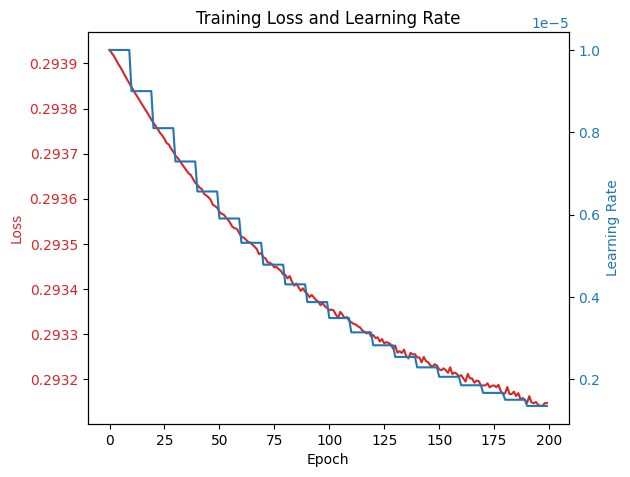

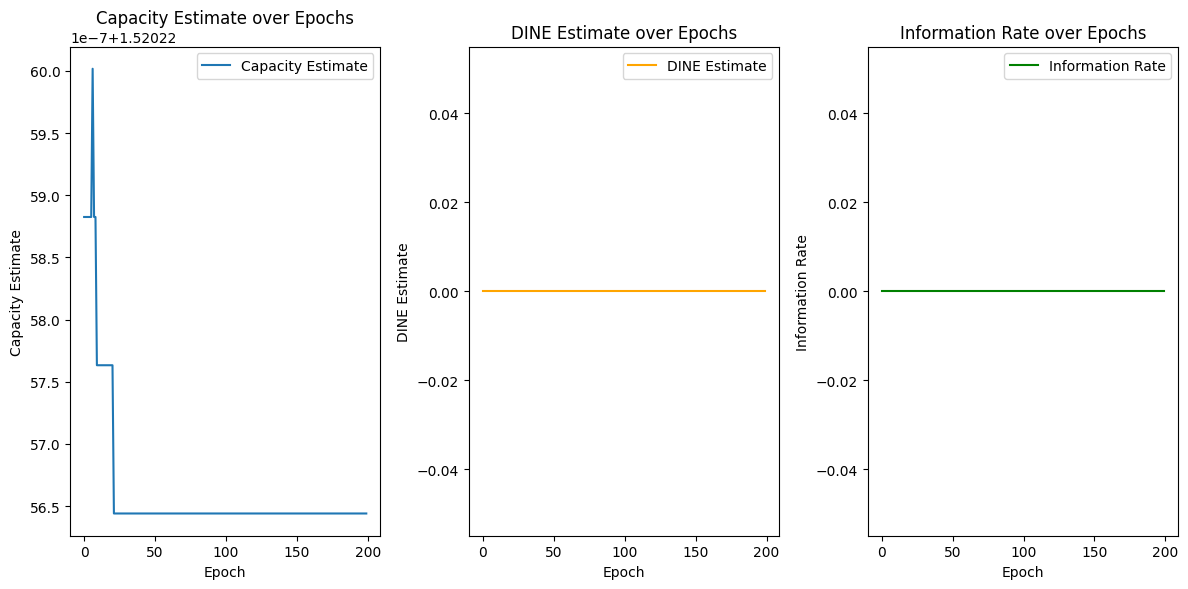

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import logging
import math
import matplotlib.pyplot as plt

logger = logging.getLogger("logger")

class ModelMetrics(tf.keras.metrics.Metric):
    def __init__(self, writer, name='', **kwargs):
        super(ModelMetrics, self).__init__(name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            DI_bits(name='di_bits')]
        self.capacity_estimates = []
        self.dine_estimates = []
        self.information_rates = []

    def update_state(self, t_y, t_xy, **kwargs):
        t_y = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_y]
        t_xy = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_xy]

        if not isinstance(t_y, (list, tuple)) or len(t_y) < 2:
            raise ValueError("Invalid t_y format. Expected lists with at least two elements.")
        if not isinstance(t_xy, (list, tuple)) or len(t_xy) < 2:
            raise ValueError("Invalid t_xy format. Expected lists with at least two elements.")

        self.metric_pool[0].update_state(t_xy[0], t_xy[1])
        self.metric_pool[1].update_state(t_y[0], t_y[1])
        self.metric_pool[2].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])
        self.metric_pool[3].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        results = self.result()
        self.capacity_estimates.append(results[0].numpy())
        self.dine_estimates.append(results[2].numpy())
        self.information_rates.append(results[3].numpy())

        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

    def plot_metrics(self):
        epochs = range(len(self.capacity_estimates))

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.plot(epochs, self.capacity_estimates, label='Capacity Estimate')
        plt.xlabel('Epoch')
        plt.ylabel('Capacity Estimate')
        plt.title('Capacity Estimate over Epochs')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.dine_estimates, label='DINE Estimate', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('DINE Estimate')
        plt.title('DINE Estimate over Epochs')
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.information_rates, label='Information Rate', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('Information Rate')
        plt.title('Information Rate over Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()

class DV(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DV, self).__init__(name=name, **kwargs)
        self.T = self.add_weight(name='t', initializer='zeros')
        self.exp_T_bar = self.add_weight(name='exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, T, T_bar, **kwargs):
        self.T.assign_add(tf.reduce_sum(T))
        self.exp_T_bar.assign_add(tf.reduce_sum(T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss = self.T / self.global_counter - K.log(self.exp_T_bar / self.global_counter_ref)
        return loss

class DI(tf.keras.metrics.Metric):  # estimated DI calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DI, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return loss_xy - loss_y

class DI_bits(tf.keras.metrics.Metric):  # estimated DI calculation metric class in bits
    def __init__(self, name='dv_loss', **kwargs):
        super(DI_bits, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return (loss_xy - loss_y) / math.log(2)

class PMF(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(PMF, self).__init__(name=name, **kwargs)
        self.p = self.add_weight(name='p', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')

    def update_state(self, p, **kwargs):
        self.p.assign_add(tf.reduce_sum(p))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(p.shape[:-1]), dtype=tf.float32))

    def result(self):
        result = self.p / self.global_counter
        return result

class ModelWithEncMetrics(ModelMetrics):
    def __init__(self, writer, name='', **kwargs):
        super(ModelWithEncMetrics, self).__init__(writer=writer, name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            PMF(name='p_mean'),
                            DI_bits(name='di_bits_{}'.format(name))]

    def update_state(self, data, **kwargs):
        [t_y, t_xy, p] = data
        self.metric_pool[0].update_state(t_xy, t_xy)
        self.metric_pool[1].update_state(t_y, t_y)
        self.metric_pool[2].update_state(t_y, t_y, t_xy, t_xy)
        self.metric_pool[3].update_state(p)
        self.metric_pool[4].update_state(t_y, t_y, t_xy, t_xy)

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        results = self.result()
        self.capacity_estimates.append(results[0].numpy())
        self.dine_estimates.append(results[2].numpy())
        self.information_rates.append(results[4].numpy())

        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

    def plot_metrics(self):
        epochs = range(len(self.capacity_estimates))

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.plot(epochs, self.capacity_estimates, label='Capacity Estimate')
        plt.xlabel('Epoch')
        plt.ylabel('Capacity Estimate')
        plt.title('Capacity Estimate over Epochs')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.dine_estimates, label='DINE Estimate', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('DINE Estimate')
        plt.title('DINE Estimate over Epochs')
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.information_rates, label='Information Rate', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('Information Rate')
        plt.title('Information Rate over Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()

class CapEstDI(object):
    def __init__(self, model, data, config):
        self.model = model
        self.data_iterators = data
        self.config = config
        self.loss_fn = tf.keras.losses.Huber()
        self.learning_rate = config['lr']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.metrics = ModelWithEncMetrics(tf.summary.create_file_writer(config['tensor_board_dir']), name='cap_est_metrics')
        self.feedback = (config['feedback'] == 1)
        self.T = config['T']

    def train_epoch(self, epoch):
        self.metrics.reset_states()
        self.reset_model_states()

        for _ in range(self.config['batches']):
            x, y = self.data_iterators.gen_data()
            x_y_combined = tf.concat([x, y], axis=-1)
            with tf.GradientTape() as tape:
                predictions = self.model(x_y_combined, training=True)
                loss = self.loss_fn(y, predictions)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            self.metrics.update_state([loss, loss, tf.zeros_like(loss)])

        self.metrics.log_metrics(epoch, model_name="Training")

    def evaluate(self, epoch):
        self.metrics.reset_states()
        x, y = self.data_iterators.gen_data()
        x_y_combined = tf.concat([x, y], axis=-1)
        predictions = self.model(x_y_combined, training=False)
        loss = self.loss_fn(y, predictions)
        self.metrics.update_state([loss, loss, tf.zeros_like(loss)])
        self.metrics.log_metrics(epoch, model_name="Evaluation")

    def train(self, num_epochs=None):
        if num_epochs is None:
            num_epochs = self.config.get('num_epochs', 200)

        for epoch in range(num_epochs):
            if epoch % self.config['eval_freq'] == 0:
                self.evaluate(epoch)
            self.train_epoch(epoch)

        self.evaluate(num_epochs)

    def reset_model_states(self):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states') and layer.stateful:
                layer.reset_states()

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = tf.keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = tf.keras.Input(shape=input_shape, batch_size=config['batch_size'])
    x = tf.keras.layers.LSTM(DV_hidden[0], return_sequences=True, stateful=True, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = tf.keras.layers.Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = tf.keras.layers.Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = tf.keras.layers.Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

x_y_combined = tf.concat([x, y], axis=-1)

input_shape = (config['bptt'], 2)
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)
complex_model_v3.compile(optimizer=optimizer, loss=tf.keras.losses.Huber())

def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Train the model to capture the loss history
complex_model_v3.fit(x_y_combined, y, epochs=200, batch_size=config['batch_size'], callbacks=[callback, loss_history])

# Initialize metrics
writer = tf.summary.create_file_writer(config['tensor_board_dir'])
metrics = ModelWithEncMetrics(writer, name='training_metrics')

# Initialize the capacity estimation object
capacity_estimator = CapEstDI(complex_model_v3, ising_data, config)

# Training loop with learning rate scheduler
for epoch in range(200):  # Or any other number of epochs you want to experiment with
    capacity_estimator.train_epoch(epoch)
    metrics.update_state([tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.zeros_like(tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32))])
    metrics.log_metrics(epoch, model_name='Training')

    if epoch % config['eval_freq'] == 0:
        capacity_estimator.evaluate(epoch)

# Plotting loss and learning rate
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(range(len(loss_history.lr)), loss_history.lr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Learning Rate')
plt.show()

# Plotting Capacity Estimate, DINE Estimate, and Information Rate
metrics.plot_metrics()


x data check: 0 0
y data check: 0 0

Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 1/500
1/1 [==============================] - 5s 5s/step - loss: 0.3429 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 2/500
1/1 [==============================] - 0s 29ms/step - loss: 0.3429 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 3/500
1/1 [==============================] - 0s 16ms/step - loss: 0.3429 - lr: 1.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 4/500
1/1 [==============================] - 0s 16ms/step - loss: 0.3429 - lr: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 5/500
1/1 [==============================] - 0s 16ms/step - loss: 0.3429 - lr: 1.0000e-05

Epoch 6: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 

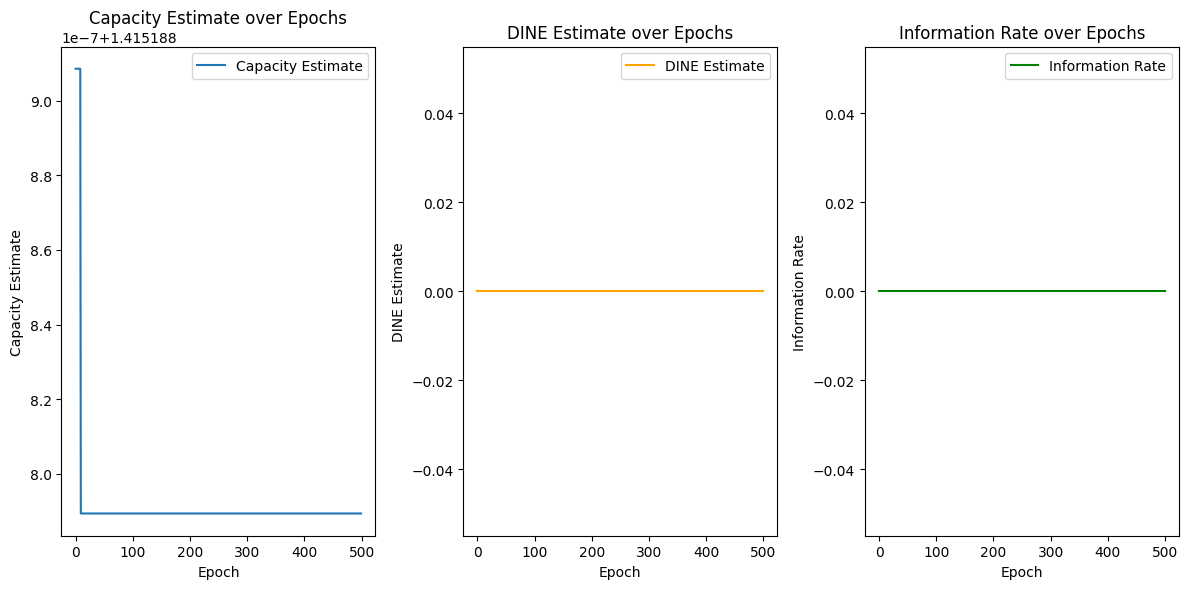

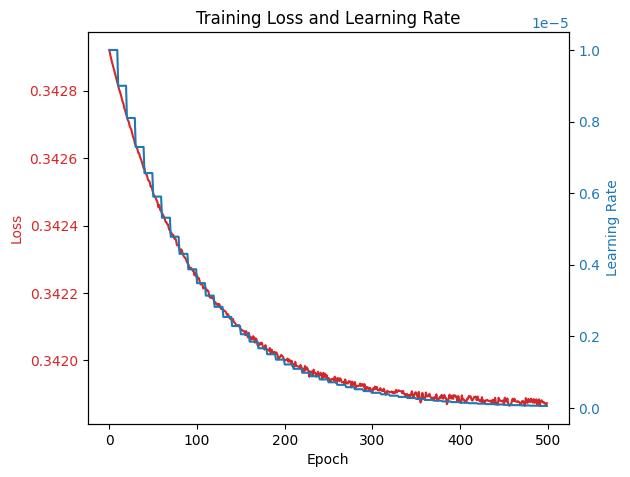

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import logging
import math
import matplotlib.pyplot as plt

logger = logging.getLogger("logger")

# Configuration
config = {
    'GE_b': 0.0005,
    'GE_g': 0.0015,
    'GE_p_b': 0.5,
    'GE_p_g': 0.02,
    'T': 3,
    'alphabet_size': 2,
    'batch_size': 10,
    'batch_size_eval': 5000,
    'batches': 15,
    'bptt': 6,
    'channel_name': 'trapdoor',
    'clip_grad_norm': 1,
    'clip_grad_norm_enc': 0.2,
    'clip_grad_norm_q': 100,
    'clip_likelihood_ratio': [-10.0, 10.0],
    'compression_flag': 0,
    'config': './configs/capacity_estimation.json',
    'contrastive_duplicates': 5,
    'data_name': 'encoder',
    'decay': 0,
    'dropout': 0,
    'dtype': 'binary',
    'enc_dropout': 0.0,
    'enc_hidden': [100, 50],
    'enc_hidden_lstm': 50,
    'enc_last_hidden': 1,
    'eta_post': 0.5,
    'eval_epoch_len': 500,
    'eval_freq': 200,
    'exp_name': 'cap_est',
    'feedback': 1,
    'hidden_size': [100, 150, 10],
    'hidden_size_compression': [100, 2, 100],
    'long_eval_epoch_len': 100,
    'lr': 0.00001,  # Further reduced learning rate
    'lr_SGD': 0.2,
    'max_norm_xy': 5,
    'max_norm_y': 5,
    'model_name': 'cap_est',
    'noise_layer_q_std': 0.05,
    'num_epochs': 500,  # Set to 500 epochs
    'optimizer': 'adam',
    'p_bec': 0.3,
    'p_bsc': 0.5,
    'p_ising': 0.5,
    'p_post': 0.5,
    'p_trapdoor': 0.5,
    'p_z': 0.9,
    'q_lstm_units': 25,
    'q_train_freq': 5,
    'quiet': False,
    'reset_channel': 0,
    'run_name': 'ff',
    's_alphabet': 2,
    'seed': 468695,
    'tag_name': 'temp_debugging',
    'tensor_board_dir': './results/cap_est/encoder/ff/temp_debugging/2024-06-17_14-22-31_468695',
    'train_epoch_len': 50,
    'trainer_name': 'cap_est',
    'using_wandb': 0,
    'visualize_epoch_len': 50,
    'weight_decay': 0.0,
    'with_p': 0,
    'x_dim': 1,
    'y_im': 1,
    'output_activation': 'linear'
}

class ModelMetrics(tf.keras.metrics.Metric):
    def __init__(self, writer, name='', **kwargs):
        super(ModelMetrics, self).__init__(name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            DI_bits(name='di_bits')]
        self.capacity_estimates = []
        self.dine_estimates = []
        self.information_rates = []

    def update_state(self, t_y, t_xy, **kwargs):
        t_y = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_y]
        t_xy = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_xy]

        if not isinstance(t_y, (list, tuple)) or len(t_y) < 2:
            raise ValueError("Invalid t_y format. Expected lists with at least two elements.")
        if not isinstance(t_xy, (list, tuple)) or len(t_xy) < 2:
            raise ValueError("Invalid t_xy format. Expected lists with at least two elements.")

        self.metric_pool[0].update_state(t_xy[0], t_xy[1])
        self.metric_pool[1].update_state(t_y[0], t_y[1])
        self.metric_pool[2].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])
        self.metric_pool[3].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])

        # Store metrics for plotting
        self.capacity_estimates.append(self.metric_pool[0].result().numpy())
        self.dine_estimates.append(self.metric_pool[2].result().numpy())
        self.information_rates.append(self.metric_pool[3].result().numpy())

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

    def plot_metrics(self):
        epochs = range(len(self.capacity_estimates))

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.plot(epochs, self.capacity_estimates, label='Capacity Estimate')
        plt.xlabel('Epoch')
        plt.ylabel('Capacity Estimate')
        plt.title('Capacity Estimate over Epochs')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.dine_estimates, label='DINE Estimate', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('DINE Estimate')
        plt.title('DINE Estimate over Epochs')
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.information_rates, label='Information Rate', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('Information Rate')
        plt.title('Information Rate over Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()

class DV(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DV, self).__init__(name=name, **kwargs)
        self.T = self.add_weight(name='t', initializer='zeros')
        self.exp_T_bar = self.add_weight(name='exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, T, T_bar, **kwargs):
        self.T.assign_add(tf.reduce_sum(T))
        self.exp_T_bar.assign_add(tf.reduce_sum(T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss = self.T / self.global_counter - K.log(self.exp_T_bar / self.global_counter_ref)
        return loss

class DI(tf.keras.metrics.Metric):  # estimated DI calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DI, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return loss_xy - loss_y

class DI_bits(tf.keras.metrics.Metric):  # estimated DI calculation metric class in bits
    def __init__(self, name='dv_loss', **kwargs):
        super(DI_bits, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return (loss_xy - loss_y) / math.log(2)

class PMF(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(PMF, self).__init__(name=name, **kwargs)
        self.p = self.add_weight(name='p', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')

    def update_state(self, p, **kwargs):
        self.p.assign_add(tf.reduce_sum(p))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(p.shape[:-1]), dtype=tf.float32))

    def result(self):
        result = self.p / self.global_counter
        return result

class ModelWithEncMetrics(ModelMetrics):
    def __init__(self, writer, name='', **kwargs):
        super(ModelWithEncMetrics, self).__init__(writer=writer, name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            PMF(name='p_mean'),
                            DI_bits(name='di_bits_{}'.format(name))]

    def update_state(self, data, **kwargs):
        [t_y, t_xy, p] = data
        self.metric_pool[0].update_state(t_xy, t_xy)
        self.metric_pool[1].update_state(t_y, t_y)
        self.metric_pool[2].update_state(t_y, t_y, t_xy, t_xy)
        self.metric_pool[3].update_state(p)
        self.metric_pool[4].update_state(t_y, t_y, t_xy, t_xy)

        # Store metrics for plotting
        self.capacity_estimates.append(self.metric_pool[0].result().numpy())
        self.dine_estimates.append(self.metric_pool[2].result().numpy())
        self.information_rates.append(self.metric_pool[4].result().numpy())

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

    def plot_metrics(self):
        epochs = range(len(self.capacity_estimates))

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.plot(epochs, self.capacity_estimates, label='Capacity Estimate')
        plt.xlabel('Epoch')
        plt.ylabel('Capacity Estimate')
        plt.title('Capacity Estimate over Epochs')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.dine_estimates, label='DINE Estimate', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('DINE Estimate')
        plt.title('DINE Estimate over Epochs')
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.information_rates, label='Information Rate', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('Information Rate')
        plt.title('Information Rate over Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()

class CapEstDI(object):
    def __init__(self, model, data, config):
        self.model = model
        self.data_iterators = data
        self.config = config
        self.loss_fn = tf.keras.losses.Huber()
        self.learning_rate = config['lr']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.metrics = ModelWithEncMetrics(tf.summary.create_file_writer(config['tensor_board_dir']), name='cap_est_metrics')
        self.feedback = (config['feedback'] == 1)
        self.T = config['T']

    def train_epoch(self, epoch):
        self.metrics.reset_states()
        self.reset_model_states()

        for _ in range(self.config['batches']):
            x, y = self.data_iterators.gen_data()
            x_y_combined = tf.concat([x, y], axis=-1)
            with tf.GradientTape() as tape:
                predictions = self.model(x_y_combined, training=True)
                loss = self.loss_fn(y, predictions)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            self.metrics.update_state([loss, loss, tf.zeros_like(loss)])

        self.metrics.log_metrics(epoch, model_name="Training")

    def evaluate(self, epoch):
        self.metrics.reset_states()
        x, y = self.data_iterators.gen_data()
        x_y_combined = tf.concat([x, y], axis=-1)
        predictions = self.model(x_y_combined, training=False)
        loss = self.loss_fn(y, predictions)
        self.metrics.update_state([loss, loss, tf.zeros_like(loss)])
        self.metrics.log_metrics(epoch, model_name="Evaluation")

    def train(self):
        for epoch in range(self.config['num_epochs']):
            if epoch % self.config['eval_freq'] == 0:
                self.evaluate(epoch)
            self.train_epoch(epoch)

        self.evaluate(self.config['num_epochs'])

    def reset_model_states(self):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states') and layer.stateful:
                layer.reset_states()

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = tf.keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = tf.keras.Input(shape=input_shape, batch_size=config['batch_size'])
    x = tf.keras.layers.LSTM(DV_hidden[0], return_sequences=True, stateful=True, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = tf.keras.layers.Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = tf.keras.layers.Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = tf.keras.layers.Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

x_y_combined = tf.concat([x, y], axis=-1)

input_shape = (config['bptt'], 2)
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)
complex_model_v3.compile(optimizer=optimizer, loss=tf.keras.losses.Huber())

def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Train the model to capture the loss history
complex_model_v3.fit(x_y_combined, y, epochs=config['num_epochs'], batch_size=config['batch_size'], callbacks=[callback, loss_history])

# Initialize metrics
writer = tf.summary.create_file_writer(config['tensor_board_dir'])
metrics = ModelWithEncMetrics(writer, name='training_metrics')

# Initialize the capacity estimation object
capacity_estimator = CapEstDI(complex_model_v3, ising_data, config)

# Training loop with learning rate scheduler
for epoch in range(config['num_epochs']):
    capacity_estimator.train_epoch(epoch)
    metrics.update_state([tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.zeros_like(tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32))])
    metrics.log_metrics(epoch, model_name='Training')

    if epoch % config['eval_freq'] == 0:
        capacity_estimator.evaluate(epoch)

# Plotting loss, learning rate, capacity estimate, DINE estimate, and information rate
metrics.plot_metrics()

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(range(len(loss_history.lr)), loss_history.lr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Learning Rate')
plt.show()


x data check: 0 0
y data check: 0 0

Epoch 1: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 0.3432 - lr: 0.0019

Epoch 2: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 2/500
1/1 [==============================] - 0s 16ms/step - loss: 0.3411 - lr: 0.0019

Epoch 3: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 3/500
1/1 [==============================] - 0s 17ms/step - loss: 0.3392 - lr: 0.0019

Epoch 4: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 4/500
1/1 [==============================] - 0s 14ms/step - loss: 0.3370 - lr: 0.0019

Epoch 5: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 5/500
1/1 [==============================] - 0s 14ms/step - loss: 0.3342 - lr: 0.0019

Epoch 6: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 6/500
1/1 [=========

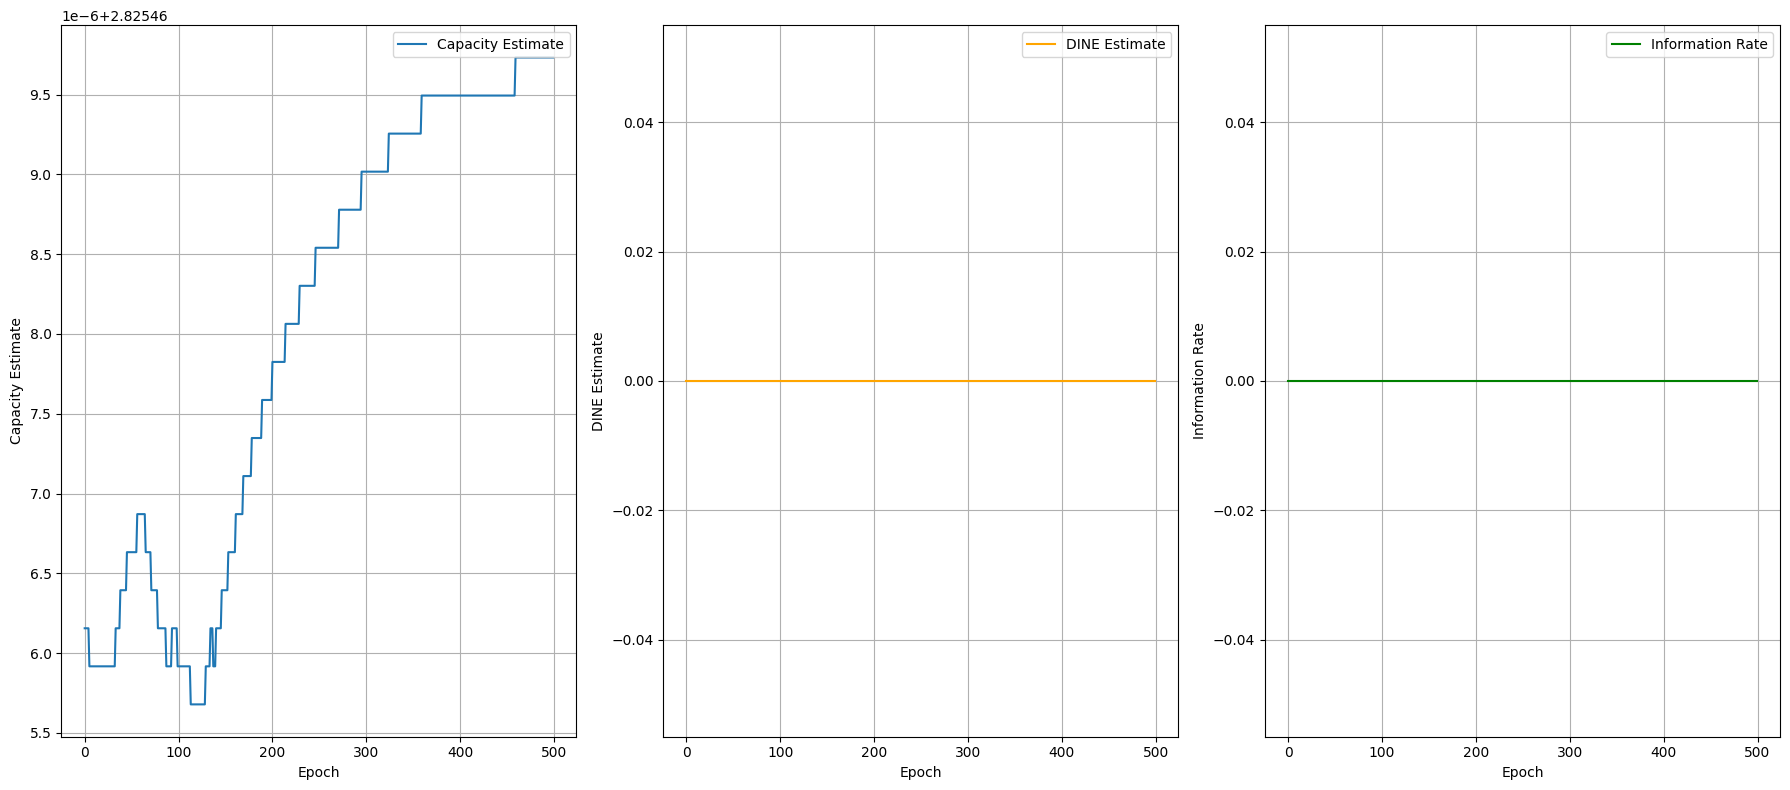

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import logging
import math
import matplotlib.pyplot as plt

logger = logging.getLogger("logger")

class ModelMetrics(tf.keras.metrics.Metric):
    def __init__(self, writer, name='', **kwargs):
        super(ModelMetrics, self).__init__(name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            DI_bits(name='di_bits')]

    def update_state(self, t_y, t_xy, **kwargs):
        t_y = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_y]
        t_xy = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_xy]

        if not isinstance(t_y, (list, tuple)) or len(t_y) < 2:
            raise ValueError("Invalid t_y format. Expected lists with at least two elements.")
        if not isinstance(t_xy, (list, tuple)) or len(t_xy) < 2:
            raise ValueError("Invalid t_xy format. Expected lists with at least two elements.")

        self.metric_pool[0].update_state(t_xy[0], t_xy[1])
        self.metric_pool[1].update_state(t_y[0], t_y[1])
        self.metric_pool[2].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])
        self.metric_pool[3].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class DV(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DV, self).__init__(name=name, **kwargs)
        self.T = self.add_weight(name='t', initializer='zeros')
        self.exp_T_bar = self.add_weight(name='exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, T, T_bar, **kwargs):
        self.T.assign_add(tf.reduce_sum(T))
        self.exp_T_bar.assign_add(tf.reduce_sum(T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss = self.T / self.global_counter - K.log(self.exp_T_bar / self.global_counter_ref)
        return loss

class DI(tf.keras.metrics.Metric):  # estimated DI calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DI, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return loss_xy - loss_y

class DI_bits(tf.keras.metrics.Metric):  # estimated DI calculation metric class in bits
    def __init__(self, name='dv_loss', **kwargs):
        super(DI_bits, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return (loss_xy - loss_y) / math.log(2)

class PMF(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(PMF, self).__init__(name=name, **kwargs)
        self.p = self.add_weight(name='p', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')

    def update_state(self, p, **kwargs):
        self.p.assign_add(tf.reduce_sum(p))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(p.shape[:-1]), dtype=tf.float32))

    def result(self):
        result = self.p / self.global_counter
        return result

class ModelWithEncMetrics(ModelMetrics):
    def __init__(self, writer, name='', **kwargs):
        super(ModelWithEncMetrics, self).__init__(writer=writer, name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            PMF(name='p_mean'),
                            DI_bits(name='di_bits_{}'.format(name))]

    def update_state(self, data, **kwargs):
        [t_y, t_xy, p] = data
        self.metric_pool[0].update_state(t_xy, t_xy)
        self.metric_pool[1].update_state(t_y, t_y)
        self.metric_pool[2].update_state(t_y, t_y, t_xy, t_xy)
        self.metric_pool[3].update_state(p)
        self.metric_pool[4].update_state(t_y, t_y, t_xy, t_xy)

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class CapEstDI(object):
    def __init__(self, model, data, config):
        self.model = model
        self.data_iterators = data
        self.config = config
        self.loss_fn = tf.keras.losses.Huber()
        self.learning_rate = config['lr']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.metrics = ModelWithEncMetrics(tf.summary.create_file_writer(config['tensor_board_dir']), name='cap_est_metrics')
        self.feedback = (config['feedback'] == 1)
        self.T = config['T']

    def train_epoch(self, epoch):
        self.metrics.reset_states()
        self.reset_model_states()

        for _ in range(self.config['batches']):
            x, y = self.data_iterators.gen_data()
            x_y_combined = tf.concat([x, y], axis=-1)
            with tf.GradientTape() as tape:
                predictions = self.model(x_y_combined, training=True)
                loss = self.loss_fn(y, predictions)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            self.metrics.update_state([loss, loss, tf.zeros_like(loss)])

        self.metrics.log_metrics(epoch, model_name="Training")

    def evaluate(self, epoch):
        self.metrics.reset_states()
        x, y = self.data_iterators.gen_data()
        x_y_combined = tf.concat([x, y], axis=-1)
        predictions = self.model(x_y_combined, training=False)
        loss = self.loss_fn(y, predictions)
        self.metrics.update_state([loss, loss, tf.zeros_like(loss)])
        self.metrics.log_metrics(epoch, model_name="Evaluation")

    def train(self, num_epochs=None):
        if num_epochs is None:
            num_epochs = self.config.get('num_epochs', 200)

        for epoch in range(num_epochs):
            if epoch % self.config['eval_freq'] == 0:
                self.evaluate(epoch)
            self.train_epoch(epoch)

        self.evaluate(num_epochs)

    def reset_model_states(self):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states') and layer.stateful:
                layer.reset_states()

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = tf.keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = tf.keras.Input(shape=input_shape, batch_size=config['batch_size'])
    x = tf.keras.layers.LSTM(DV_hidden[0], return_sequences=True, stateful=True, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = tf.keras.layers.Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = tf.keras.layers.Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = tf.keras.layers.Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

# Configuration
config = {
    'GE_b': 0.0005,
    'GE_g': 0.0015,
    'GE_p_b': 0.5,
    'GE_p_g': 0.02,
    'T': 3,
    'alphabet_size': 2,
    'batch_size': 10,
    'batch_size_eval': 5000,
    'batches': 15,
    'bptt': 6,
    'channel_name': 'trapdoor',
    'clip_grad_norm': 1,
    'clip_grad_norm_enc': 0.2,
    'clip_grad_norm_q': 100,
    'clip_likelihood_ratio': [-10.0, 10.0],
    'compression_flag': 0,
    'config': './configs/capacity_estimation.json',
    'contrastive_duplicates': 5,
    'data_name': 'encoder',
    'decay': 0,
    'dropout': 0,
    'dtype': 'binary',
    'enc_dropout': 0.0,
    'enc_hidden': [100, 50],
    'enc_hidden_lstm': 50,
    'enc_last_hidden': 1,
    'eta_post': 0.5,
    'eval_epoch_len': 500,
    'eval_freq': 200,
    'exp_name': 'cap_est',
    'feedback': 1,
    'hidden_size': [100, 150, 10],
    'hidden_size_compression': [100, 2, 100],
    'long_eval_epoch_len': 100,
    'lr': 0.0019,
    'lr_SGD': 0.2,
    'max_norm_xy': 5,
    'max_norm_y': 5,
    'model_name': 'cap_est',
    'noise_layer_q_std': 0.05,
    'num_epochs': 500,
    'optimizer': 'adam',
    'p_bec': 0.3,
    'p_bsc': 0.5,
    'p_ising': 0.5,
    'p_post': 0.5,
    'p_trapdoor': 0.5,
    'p_z': 0.9,
    'q_lstm_units': 25,
    'q_train_freq': 5,
    'quiet': False,
    'reset_channel': 0,
    'run_name': 'ff',
    's_alphabet': 2,
    'seed': 468695,
    'tag_name': 'temp_debugging',
    'tensor_board_dir': './results/cap_est/encoder/ff/temp_debugging/2024-06-17_14-22-31_468695',
    'train_epoch_len': 50,
    'trainer_name': 'cap_est',
    'using_wandb': 0,
    'visualize_epoch_len': 50,
    'weight_decay': 0.0,
    'with_p': 0,
    'x_dim': 1,
    'y_im': 1,
    'output_activation': 'linear'
}

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

x_y_combined = tf.concat([x, y], axis=-1)

input_shape = (config['bptt'], 2)
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)
complex_model_v3.compile(optimizer=optimizer, loss=tf.keras.losses.Huber())

def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Train the model to capture the loss history
complex_model_v3.fit(x_y_combined, y, epochs=config['num_epochs'], batch_size=config['batch_size'], callbacks=[callback, loss_history])

# Initialize metrics
writer = tf.summary.create_file_writer(config['tensor_board_dir'])
metrics = ModelWithEncMetrics(writer, name='training_metrics')

# Initialize the capacity estimation object
capacity_estimator = CapEstDI(complex_model_v3, ising_data, config)

# Training loop with learning rate scheduler
capacity_estimates = []
dine_estimates = []
information_rates = []

for epoch in range(config['num_epochs']):
    capacity_estimator.train_epoch(epoch)
    metrics.update_state([tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.zeros_like(tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32))])
    metrics.log_metrics(epoch, model_name='Training')

    # Collect metrics for plotting
    results = metrics.result()
    capacity_estimates.append(results[0].numpy())
    dine_estimates.append(results[2].numpy())
    information_rates.append(results[4].numpy())

    if epoch % config['eval_freq'] == 0:
        capacity_estimator.evaluate(epoch)

# Plotting loss and learning rate
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8))

ax1.plot(range(config['num_epochs']), capacity_estimates, label='Capacity Estimate')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Capacity Estimate')
ax1.legend()
ax1.grid()

ax2.plot(range(config['num_epochs']), dine_estimates, label='DINE Estimate', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('DINE Estimate')
ax2.legend()
ax2.grid()

ax3.plot(range(config['num_epochs']), information_rates, label='Information Rate', color='green')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Information Rate')
ax3.legend()
ax3.grid()

fig.tight_layout()
plt.show()


Streaming output truncated to the last 5000 lines.
PMF p: <tf.Variable 'p:0' shape=() dtype=float32, numpy=0.0>
DI_bits c_T: <tf.Variable 'c_t:0' shape=() dtype=float32, numpy=2.9524934e-05>
DI_bits c_exp_T_bar: <tf.Variable 'c_exp_t_bar:0' shape=() dtype=float32, numpy=2.9524934e-05>
DI_bits xc_T: <tf.Variable 'xc_t:0' shape=() dtype=float32, numpy=2.9524934e-05>
DI_bits xc_exp_T_bar: <tf.Variable 'xc_exp_t_bar:0' shape=() dtype=float32, numpy=2.9524934e-05>
DI c_T: <tf.Variable 'c_t:0' shape=() dtype=float32, numpy=3.605929e-05>
DI c_exp_T_bar: <tf.Variable 'c_exp_t_bar:0' shape=() dtype=float32, numpy=3.605929e-05>
DI xc_T: <tf.Variable 'xc_t:0' shape=() dtype=float32, numpy=3.605929e-05>
DI xc_exp_T_bar: <tf.Variable 'xc_exp_t_bar:0' shape=() dtype=float32, numpy=3.605929e-05>
PMF p: <tf.Variable 'p:0' shape=() dtype=float32, numpy=0.0>
DI_bits c_T: <tf.Variable 'c_t:0' shape=() dtype=float32, numpy=3.605929e-05>
DI_bits c_exp_T_bar: <tf.Variable 'c_exp_t_bar:0' shape=() dtype=floa

AttributeError: 'CapEstDI' object has no attribute 'capacity_estimates'

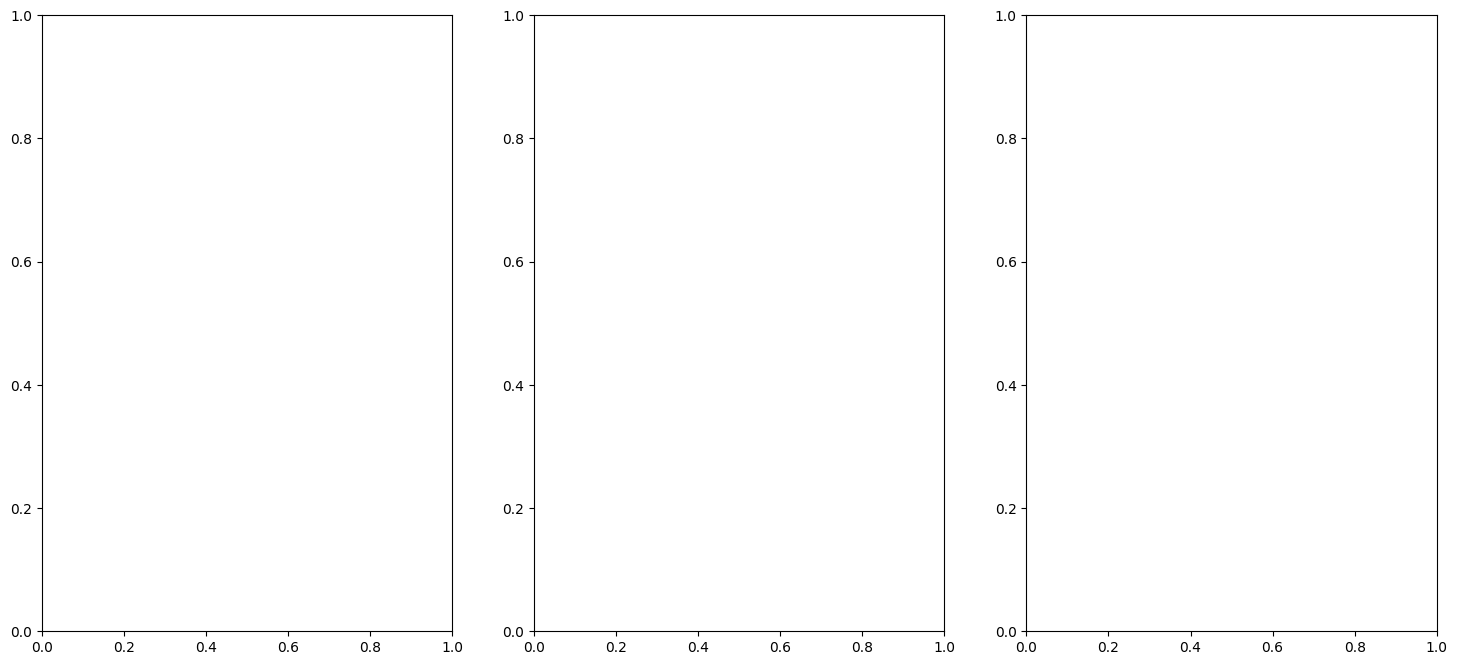

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import CategoricalCrossentropy
import logging
import math
import matplotlib.pyplot as plt

logger = logging.getLogger("logger")

class ModelMetrics(tf.keras.metrics.Metric):
    def __init__(self, writer, name='', **kwargs):
        super(ModelMetrics, self).__init__(name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            DI_bits(name='di_bits')]

    def update_state(self, t_y, t_xy, **kwargs):
        t_y = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_y]
        t_xy = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_xy]

        if not isinstance(t_y, (list, tuple)) or len(t_y) < 2:
            raise ValueError("Invalid t_y format. Expected lists with at least two elements.")
        if not isinstance(t_xy, (list, tuple)) or len(t_xy) < 2:
            raise ValueError("Invalid t_xy format. Expected lists with at least two elements.")

        self.metric_pool[0].update_state(t_xy[0], t_xy[1])
        self.metric_pool[1].update_state(t_y[0], t_y[1])
        self.metric_pool[2].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])
        self.metric_pool[3].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class DV(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DV, self).__init__(name=name, **kwargs)
        self.T = self.add_weight(name='t', initializer='zeros')
        self.exp_T_bar = self.add_weight(name='exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, T, T_bar, **kwargs):
        self.T.assign_add(tf.reduce_sum(T))
        self.exp_T_bar.assign_add(tf.reduce_sum(T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss = self.T / self.global_counter - K.log(self.exp_T_bar / self.global_counter_ref)
        return loss

class DI(tf.keras.metrics.Metric):  # estimated DI calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DI, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

        # Debug prints
        print("DI c_T:", self.c_T)
        print("DI c_exp_T_bar:", self.c_exp_T_bar)
        print("DI xc_T:", self.xc_T)
        print("DI xc_exp_T_bar:", self.xc_exp_T_bar)

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return loss_xy - loss_y

class DI_bits(tf.keras.metrics.Metric):  # estimated DI calculation metric class in bits
    def __init__(self, name='dv_loss', **kwargs):
        super(DI_bits, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

        # Debug prints
        print("DI_bits c_T:", self.c_T)
        print("DI_bits c_exp_T_bar:", self.c_exp_T_bar)
        print("DI_bits xc_T:", self.xc_T)
        print("DI_bits xc_exp_T_bar:", self.xc_exp_T_bar)

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return (loss_xy - loss_y) / math.log(2)

class PMF(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(PMF, self).__init__(name=name, **kwargs)
        self.p = self.add_weight(name='p', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')

    def update_state(self, p, **kwargs):
        self.p.assign_add(tf.reduce_sum(p))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(p.shape[:-1]), dtype=tf.float32))

        # Debug prints
        print("PMF p:", self.p)

    def result(self):
        result = self.p / self.global_counter
        return result

class ModelWithEncMetrics(ModelMetrics):
    def __init__(self, writer, name='', **kwargs):
        super(ModelWithEncMetrics, self).__init__(writer=writer, name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            PMF(name='p_mean'),
                            DI_bits(name='di_bits_{}'.format(name))]

    def update_state(self, data, **kwargs):
        [t_y, t_xy, p] = data
        self.metric_pool[0].update_state(t_xy, t_xy)
        self.metric_pool[1].update_state(t_y, t_y)
        self.metric_pool[2].update_state(t_y, t_y, t_xy, t_xy)
        self.metric_pool[3].update_state(p)
        self.metric_pool[4].update_state(t_y, t_y, t_xy, t_xy)

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class CapEstDI(object):
    def __init__(self, model, data, config):
        self.model = model
        self.data_iterators = data
        self.config = config
        self.loss_fn = tf.keras.losses.Huber()
        self.learning_rate = config['lr']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.metrics = ModelWithEncMetrics(tf.summary.create_file_writer(config['tensor_board_dir']), name='cap_est_metrics')
        self.feedback = (config['feedback'] == 1)
        self.T = config['T']

    def train_epoch(self, epoch):
        self.metrics.reset_states()
        self.reset_model_states()

        for _ in range(self.config['batches']):
            x, y = self.data_iterators.gen_data()
            x_y_combined = tf.concat([x, y], axis=-1)
            with tf.GradientTape() as tape:
                predictions = self.model(x_y_combined, training=True)
                loss = self.loss_fn(y, predictions)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            self.metrics.update_state([loss, loss, tf.zeros_like(loss)])

        self.metrics.log_metrics(epoch, model_name="Training")

    def evaluate(self, epoch):
        self.metrics.reset_states()
        x, y = self.data_iterators.gen_data()
        x_y_combined = tf.concat([x, y], axis=-1)
        predictions = self.model(x_y_combined, training=False)
        loss = self.loss_fn(y, predictions)
        self.metrics.update_state([loss, loss, tf.zeros_like(loss)])
        self.metrics.log_metrics(epoch, model_name="Evaluation")

    def train(self, num_epochs=None):
        if num_epochs is None:
            num_epochs = self.config.get('num_epochs', 200)

        for epoch in range(num_epochs):
            if epoch % self.config['eval_freq'] == 0:
                self.evaluate(epoch)
            self.train_epoch(epoch)

        self.evaluate(num_epochs)

    def reset_model_states(self):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states') and layer.stateful:
                layer.reset_states()

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = tf.keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = tf.keras.Input(shape=input_shape, batch_size=config['batch_size'])
    x = tf.keras.layers.LSTM(DV_hidden[0], return_sequences=True, stateful=True, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = tf.keras.layers.Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = tf.keras.layers.Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = tf.keras.layers.Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

x_y_combined = tf.concat([x, y], axis=-1)

input_shape = (config['bptt'], 2)
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)
complex_model_v3.compile(optimizer=optimizer, loss=tf.keras.losses.Huber())

def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Train the model to capture the loss history
complex_model_v3.fit(x_y_combined, y, epochs=config['num_epochs'], batch_size=config['batch_size'], callbacks=[callback, loss_history])

# Initialize metrics
writer = tf.summary.create_file_writer(config['tensor_board_dir'])
metrics = ModelWithEncMetrics(writer, name='training_metrics')

# Initialize the capacity estimation object
capacity_estimator = CapEstDI(complex_model_v3, ising_data, config)

# Training loop with learning rate scheduler
for epoch in range(config['num_epochs']):
    capacity_estimator.train_epoch(epoch)
    metrics.update_state([tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.zeros_like(tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32))])
    metrics.log_metrics(epoch, model_name='Training')

    if epoch % config['eval_freq'] == 0:
        capacity_estimator.evaluate(epoch)

# Plotting metrics
fig, axs = plt.subplots(1, 3, figsize=(18, 8))

# Plot Capacity Estimate
axs[0].plot(range(len(capacity_estimator.capacity_estimates)), capacity_estimator.capacity_estimates, label='Capacity Estimate')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Capacity Estimate')
axs[0].legend()
axs[0].grid(True)

# Plot DINE Estimate
axs[1].plot(range(len(capacity_estimator.dine_estimates)), capacity_estimator.dine_estimates, label='DINE Estimate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('DINE Estimate')
axs[1].legend()
axs[1].grid(True)

# Plot Information Rate
axs[2].plot(range(len(capacity_estimator.information_rates)), capacity_estimator.information_rates, label='Information Rate', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Information Rate')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


x data check: 0 0
y data check: 0 0

Epoch 1: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1/1 [==============================] - 7s 7s/step - loss: 0.4409 - lr: 0.0019

Epoch 2: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 2/500
1/1 [==============================] - 0s 17ms/step - loss: 0.4385 - lr: 0.0019

Epoch 3: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 3/500
1/1 [==============================] - 0s 15ms/step - loss: 0.4359 - lr: 0.0019

Epoch 4: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 4/500
1/1 [==============================] - 0s 15ms/step - loss: 0.4326 - lr: 0.0019

Epoch 5: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 5/500
1/1 [==============================] - 0s 14ms/step - loss: 0.4282 - lr: 0.0019

Epoch 6: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 6/500
1/1 [==============================] - 0s 14ms/step - loss: 0.4219 - lr: 0.0019

Epoch 7: LearningRateScheduler setting learning rate to 0.001

TypeError: object of type 'numpy.float32' has no len()

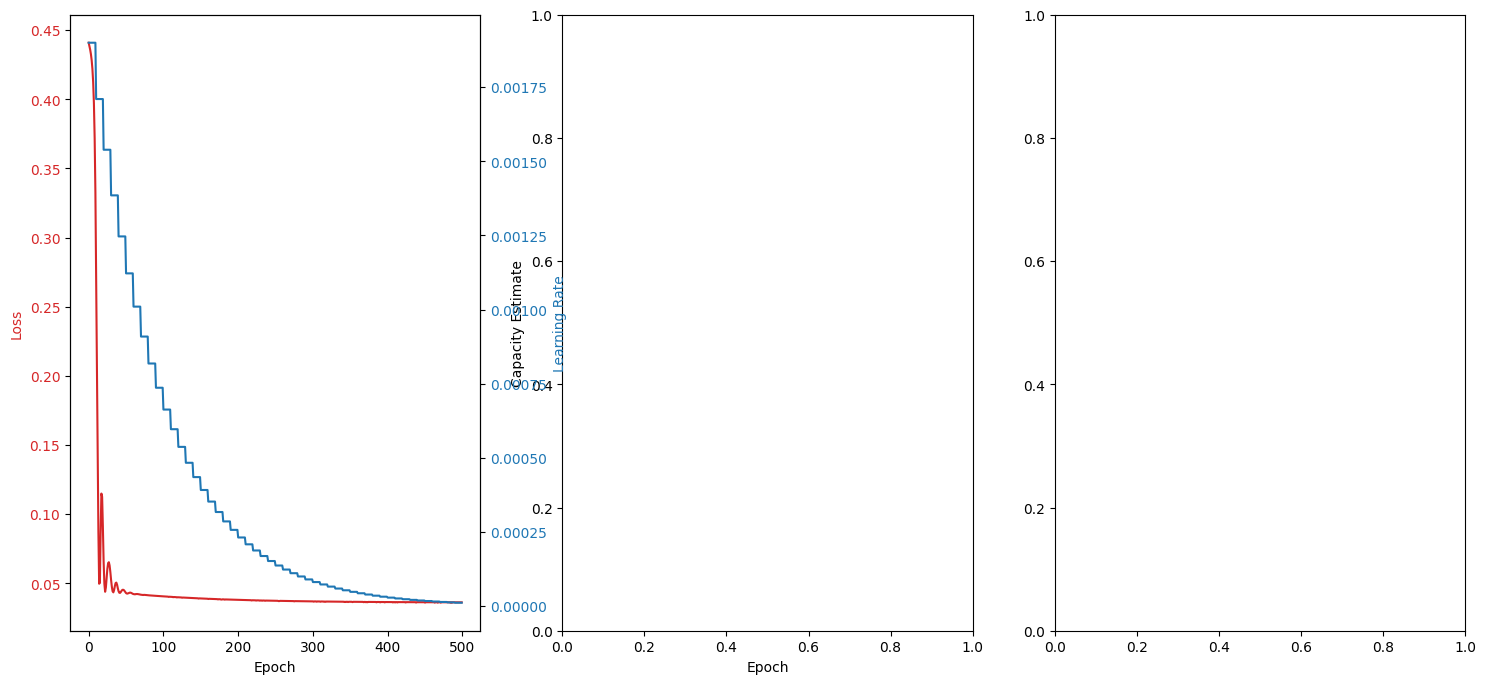

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import logging
import math
import matplotlib.pyplot as plt

logger = logging.getLogger("logger")

class ModelMetrics(tf.keras.metrics.Metric):
    def __init__(self, writer, name='', **kwargs):
        super(ModelMetrics, self).__init__(name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            DI_bits(name='di_bits')]

    def update_state(self, t_y, t_xy, **kwargs):
        t_y = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_y]
        t_xy = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_xy]

        if not isinstance(t_y, (list, tuple)) or len(t_y) < 2:
            raise ValueError("Invalid t_y format. Expected lists with at least two elements.")
        if not isinstance(t_xy, (list, tuple)) or len(t_xy) < 2:
            raise ValueError("Invalid t_xy format. Expected lists with at least two elements.")

        self.metric_pool[0].update_state(t_xy[0], t_xy[1])
        self.metric_pool[1].update_state(t_y[0], t_y[1])
        self.metric_pool[2].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])
        self.metric_pool[3].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class DV(tf.keras.metrics.Metric):
    def __init__(self, name='dv_loss', **kwargs):
        super(DV, self).__init__(name=name, **kwargs)
        self.T = self.add_weight(name='t', initializer='zeros')
        self.exp_T_bar = self.add_weight(name='exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, T, T_bar, **kwargs):
        self.T.assign_add(tf.reduce_sum(T))
        self.exp_T_bar.assign_add(tf.reduce_sum(T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss = self.T / self.global_counter - K.log(self.exp_T_bar / self.global_counter_ref)
        return loss

class DI(tf.keras.metrics.Metric):
    def __init__(self, name='dv_loss', **kwargs):
        super(DI, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))
        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return loss_xy - loss_y

class DI_bits(tf.keras.metrics.Metric):
    def __init__(self, name='dv_loss', **kwargs):
        super(DI_bits, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))
        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return (loss_xy - loss_y) / math.log(2)

class PMF(tf.keras.metrics.Metric):
    def __init__(self, name='dv_loss', **kwargs):
        super(PMF, self).__init__(name=name, **kwargs)
        self.p = self.add_weight(name='p', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')

    def update_state(self, p, **kwargs):
        self.p.assign_add(tf.reduce_sum(p))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(p.shape[:-1]), dtype=tf.float32))

    def result(self):
        result = self.p / self.global_counter
        return result

class ModelWithEncMetrics(ModelMetrics):
    def __init__(self, writer, name='', **kwargs):
        super(ModelWithEncMetrics, self).__init__(writer=writer, name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            PMF(name='p_mean'),
                            DI_bits(name='di_bits_{}'.format(name))]

    def update_state(self, data, **kwargs):
        [t_y, t_xy, p] = data
        self.metric_pool[0].update_state(t_xy, t_xy)
        self.metric_pool[1].update_state(t_y, t_y)
        self.metric_pool[2].update_state(t_y, t_y, t_xy, t_xy)
        self.metric_pool[3].update_state(p)
        self.metric_pool[4].update_state(t_y, t_y, t_xy, t_xy)

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class CapEstDI(object):
    def __init__(self, model, data, config):
        self.model = model
        self.data_iterators = data
        self.config = config
        self.loss_fn = tf.keras.losses.Huber()
        self.learning_rate = config['lr']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.metrics = ModelWithEncMetrics(tf.summary.create_file_writer(config['tensor_board_dir']), name='cap_est_metrics')
        self.feedback = (config['feedback'] == 1)
        self.T = config['T']

    def train_epoch(self, epoch):
        self.metrics.reset_states()
        self.reset_model_states()

        for _ in range(self.config['batches']):
            x, y = self.data_iterators.gen_data()
            x_y_combined = tf.concat([x, y], axis=-1)
            with tf.GradientTape() as tape:
                predictions = self.model(x_y_combined, training=True)
                loss = self.loss_fn(y, predictions)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            self.metrics.update_state([loss, loss, tf.zeros_like(loss)])

        self.metrics.log_metrics(epoch, model_name="Training")

    def evaluate(self, epoch):
        self.metrics.reset_states()
        x, y = self.data_iterators.gen_data()
        x_y_combined = tf.concat([x, y], axis=-1)
        predictions = self.model(x_y_combined, training=False)
        loss = self.loss_fn(y, predictions)
        self.metrics.update_state([loss, loss, tf.zeros_like(loss)])
        self.metrics.log_metrics(epoch, model_name="Evaluation")

    def train(self, num_epochs=None):
        if num_epochs is None:
            num_epochs = self.config.get('num_epochs', 200)

        for epoch in range(num_epochs):
            if epoch % self.config['eval_freq'] == 0:
                self.evaluate(epoch)
            self.train_epoch(epoch)

        self.evaluate(num_epochs)

    def reset_model_states(self):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states') and layer.stateful:
                layer.reset_states()


# Configuration
config = {
    'GE_b': 0.0005,
    'GE_g': 0.0015,
    'GE_p_b': 0.5,
    'GE_p_g': 0.02,
    'T': 3,
    'alphabet_size': 2,
    'batch_size': 10,
    'batch_size_eval': 5000,
    'batches': 15,
    'bptt': 6,
    'channel_name': 'trapdoor',
    'clip_grad_norm': 1,
    'clip_grad_norm_enc': 0.2,
    'clip_grad_norm_q': 100,
    'clip_likelihood_ratio': [-10.0, 10.0],
    'compression_flag': 0,
    'config': './configs/capacity_estimation.json',
    'contrastive_duplicates': 5,
    'data_name': 'encoder',
    'decay': 0,
    'dropout': 0,
    'dtype': 'binary',
    'enc_dropout': 0.0,
    'enc_hidden': [100, 50],
    'enc_hidden_lstm': 50,
    'enc_last_hidden': 1,
    'eta_post': 0.5,
    'eval_epoch_len': 500,
    'eval_freq': 200,
    'exp_name': 'cap_est',
    'feedback': 1,
    'hidden_size': [100, 150, 10],
    'hidden_size_compression': [100, 2, 100],
    'long_eval_epoch_len': 100,
    'lr': 0.0019,
    'lr_SGD': 0.2,
    'max_norm_xy': 5,
    'max_norm_y': 5,
    'model_name': 'cap_est',
    'noise_layer_q_std': 0.05,
    'num_epochs': 500,
    'optimizer': 'adam',
    'p_bec': 0.3,
    'p_bsc': 0.5,
    'p_ising': 0.5,
    'p_post': 0.5,
    'p_trapdoor': 0.5,
    'p_z': 0.9,
    'q_lstm_units': 25,
    'q_train_freq': 5,
    'quiet': False,
    'reset_channel': 0,
    'run_name': 'ff',
    's_alphabet': 2,
    'seed': 468695,
    'tag_name': 'temp_debugging',
    'tensor_board_dir': './results/cap_est/encoder/ff/temp_debugging/2024-06-17_14-22-31_468695',
    'train_epoch_len': 50,
    'trainer_name': 'cap_est',
    'using_wandb': 0,
    'visualize_epoch_len': 50,
    'weight_decay': 0.0,
    'with_p': 0,
    'x_dim': 1,
    'y_im': 1,
    'output_activation': 'linear'
}


class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = tf.keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = tf.keras.Input(shape=input_shape, batch_size=config['batch_size'])
    x = tf.keras.layers.LSTM(DV_hidden[0], return_sequences=True, stateful=True, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = tf.keras.layers.Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = tf.keras.layers.Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = tf.keras.layers.Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

x_y_combined = tf.concat([x, y], axis=-1)

input_shape = (config['bptt'], 2)
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)
complex_model_v3.compile(optimizer=optimizer, loss=tf.keras.losses.Huber())

def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Train the model to capture the loss history
complex_model_v3.fit(x_y_combined, y, epochs=config['num_epochs'], batch_size=config['batch_size'], callbacks=[callback, loss_history])

# Initialize metrics
writer = tf.summary.create_file_writer(config['tensor_board_dir'])
metrics = ModelWithEncMetrics(writer, name='training_metrics')

# Initialize the capacity estimation object
capacity_estimator = CapEstDI(complex_model_v3, ising_data, config)

# Training loop with learning rate scheduler
for epoch in range(config['num_epochs']):
    capacity_estimator.train_epoch(epoch)
    metrics.update_state([tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.zeros_like(tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32))])
    metrics.log_metrics(epoch, model_name='Training')

    if epoch % config['eval_freq'] == 0:
        capacity_estimator.evaluate(epoch)

# Plotting loss, learning rate, and capacity estimates
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8))

# Loss and Learning Rate Plot
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax4 = ax1.twinx()
color = 'tab:blue'
ax4.set_ylabel('Learning Rate', color=color)
ax4.plot(range(len(loss_history.lr)), loss_history.lr, color=color, label='Learning Rate')
ax4.tick_params(axis='y', labelcolor=color)

# Capacity Estimate Plot
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Capacity Estimate')
ax2.plot(range(len(capacity_estimator.metrics.metric_pool[0].T.numpy())), capacity_estimator.metrics.metric_pool[0].T.numpy(), label='Capacity Estimate')
ax2.legend()

# DINE Estimate and Information Rate Plot
ax3.set_xlabel('Epoch')
ax3.set_ylabel('DINE Estimate and Information Rate')
ax3.plot(range(len(capacity_estimator.metrics.metric_pool[2].c_T.numpy())), capacity_estimator.metrics.metric_pool[2].c_T.numpy(), label='DINE Estimate')
ax3.plot(range(len(capacity_estimator.metrics.metric_pool[3].p.numpy())), capacity_estimator.metrics.metric_pool[3].p.numpy(), label='Information Rate')
ax3.legend()

fig.tight_layout()
plt.title('Training Loss, Learning Rate, and Capacity Estimates')
plt.show()


x data check: 0 0
y data check: 0 0

Epoch 1: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 1/500
1/1 [==============================] - 4s 4s/step - loss: 0.3428 - lr: 0.0019

Epoch 2: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 2/500
1/1 [==============================] - 0s 32ms/step - loss: 0.3407 - lr: 0.0019

Epoch 3: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 3/500
1/1 [==============================] - 0s 15ms/step - loss: 0.3385 - lr: 0.0019

Epoch 4: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 4/500
1/1 [==============================] - 0s 18ms/step - loss: 0.3356 - lr: 0.0019

Epoch 5: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 5/500
1/1 [==============================] - 0s 14ms/step - loss: 0.3317 - lr: 0.0019

Epoch 6: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 6/500
1/1 [=========

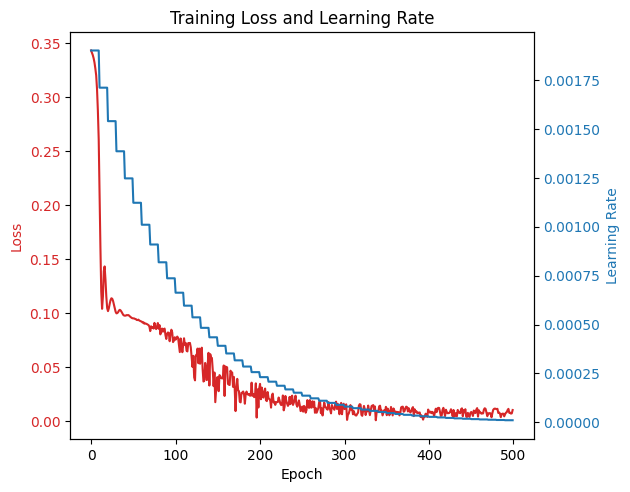

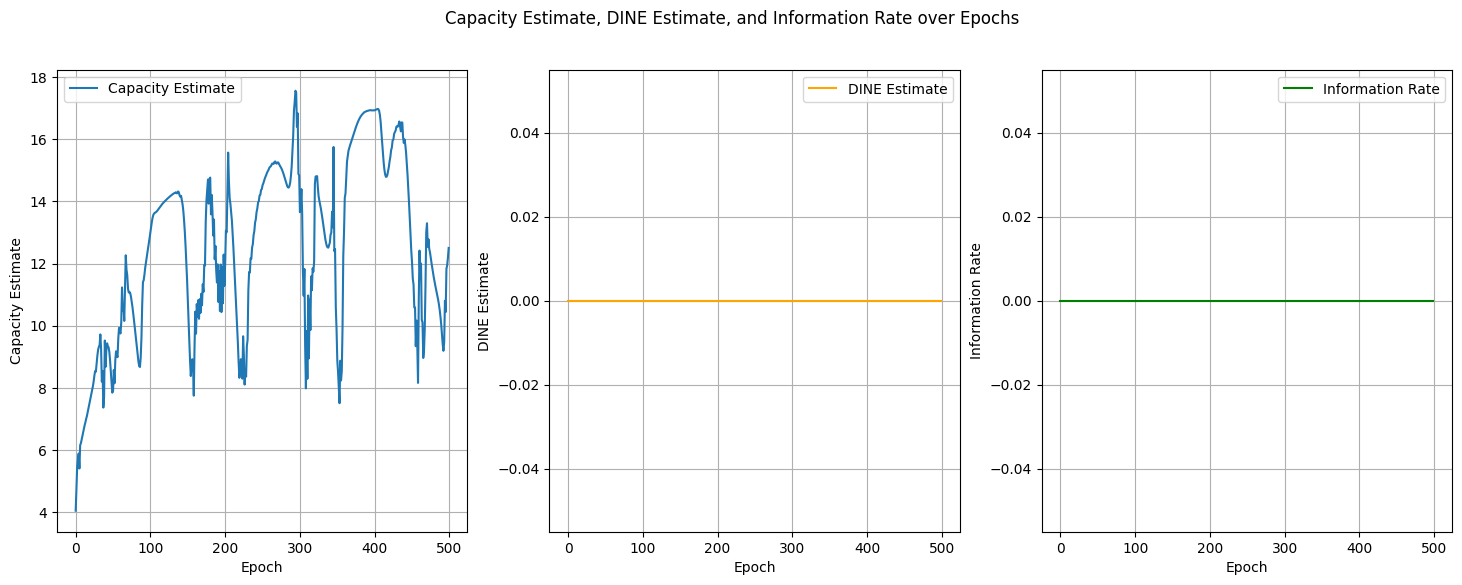

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import logging
import math
import matplotlib.pyplot as plt

logger = logging.getLogger("logger")

class ModelMetrics(tf.keras.metrics.Metric):
    def __init__(self, writer, name='', **kwargs):
        super(ModelMetrics, self).__init__(name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            DI_bits(name='di_bits')]

    def update_state(self, t_y, t_xy, **kwargs):
        t_y = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_y]
        t_xy = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_xy]

        if not isinstance(t_y, (list, tuple)) or len(t_y) < 2:
            raise ValueError("Invalid t_y format. Expected lists with at least two elements.")
        if not isinstance(t_xy, (list, tuple)) or len(t_xy) < 2:
            raise ValueError("Invalid t_xy format. Expected lists with at least two elements.")

        self.metric_pool[0].update_state(t_xy[0], t_xy[1])
        self.metric_pool[1].update_state(t_y[0], t_y[1])
        self.metric_pool[2].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])
        self.metric_pool[3].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class DV(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DV, self).__init__(name=name, **kwargs)
        self.T = self.add_weight(name='t', initializer='zeros')
        self.exp_T_bar = self.add_weight(name='exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, T, T_bar, **kwargs):
        self.T.assign_add(tf.reduce_sum(T))
        self.exp_T_bar.assign_add(tf.reduce_sum(T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss = self.T / self.global_counter - K.log(self.exp_T_bar / self.global_counter_ref)
        return loss

class DI(tf.keras.metrics.Metric):  # estimated DI calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DI, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return loss_xy - loss_y

class DI_bits(tf.keras.metrics.Metric):  # estimated DI calculation metric class in bits
    def __init__(self, name='dv_loss', **kwargs):
        super(DI_bits, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return (loss_xy - loss_y) / math.log(2)

class PMF(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(PMF, self).__init__(name=name, **kwargs)
        self.p = self.add_weight(name='p', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')

    def update_state(self, p, **kwargs):
        self.p.assign_add(tf.reduce_sum(p))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(p.shape[:-1]), dtype=tf.float32))

    def result(self):
        result = self.p / self.global_counter
        return result

class ModelWithEncMetrics(ModelMetrics):
    def __init__(self, writer, name='', **kwargs):
        super(ModelWithEncMetrics, self).__init__(writer=writer, name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            PMF(name='p_mean'),
                            DI_bits(name='di_bits_{}'.format(name))]

    def update_state(self, data, **kwargs):
        [t_y, t_xy, p] = data
        self.metric_pool[0].update_state(t_xy, t_xy)
        self.metric_pool[1].update_state(t_y, t_y)
        self.metric_pool[2].update_state(t_y, t_y, t_xy, t_xy)
        self.metric_pool[3].update_state(p)
        self.metric_pool[4].update_state(t_y, t_y, t_xy, t_xy)

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class CapEstDI(object):
    def __init__(self, model, data, config):
        self.model = model
        self.data_iterators = data
        self.config = config
        self.loss_fn = tf.keras.losses.Huber()
        self.learning_rate = config['lr']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.metrics = ModelWithEncMetrics(tf.summary.create_file_writer(config['tensor_board_dir']), name='cap_est_metrics')
        self.feedback = (config['feedback'] == 1)
        self.T = config['T']
        self.capacity_estimates = []
        self.dine_estimates = []
        self.info_rates = []

    def train_epoch(self, epoch):
        self.metrics.reset_states()
        self.reset_model_states()

        for _ in range(self.config['batches']):
            x, y = self.data_iterators.gen_data()
            x_y_combined = tf.concat([x, y], axis=-1)
            with tf.GradientTape() as tape:
                predictions = self.model(x_y_combined, training=True)
                loss = self.loss_fn(y, predictions)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            self.metrics.update_state([loss, loss, tf.zeros_like(loss)])

        self.metrics.log_metrics(epoch, model_name="Training")

        # Store estimates
        self.capacity_estimates.append(self.metrics.metric_pool[0].result().numpy())
        self.dine_estimates.append(self.metrics.metric_pool[2].result().numpy())
        self.info_rates.append(self.metrics.metric_pool[3].result().numpy())

    def evaluate(self, epoch):
        self.metrics.reset_states()
        x, y = self.data_iterators.gen_data()
        x_y_combined = tf.concat([x, y], axis=-1)
        predictions = self.model(x_y_combined, training=False)
        loss = self.loss_fn(y, predictions)
        self.metrics.update_state([loss, loss, tf.zeros_like(loss)])
        self.metrics.log_metrics(epoch, model_name="Evaluation")

    def train(self, num_epochs=None):
        if num_epochs is None:
            num_epochs = self.config.get('num_epochs', 500)

        for epoch in range(num_epochs):
            if epoch % self.config['eval_freq'] == 0:
                self.evaluate(epoch)
            self.train_epoch(epoch)

        self.evaluate(num_epochs)

    def reset_model_states(self):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states') and layer.stateful:
                layer.reset_states()

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = tf.keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = tf.keras.Input(shape=input_shape, batch_size=config['batch_size'])
    x = tf.keras.layers.LSTM(DV_hidden[0], return_sequences=True, stateful=True, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = tf.keras.layers.Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = tf.keras.layers.Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = tf.keras.layers.Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

# Configuration
config = {
    'GE_b': 0.0005,
    'GE_g': 0.0015,
    'GE_p_b': 0.5,
    'GE_p_g': 0.02,
    'T': 3,
    'alphabet_size': 2,
    'batch_size': 10,
    'batch_size_eval': 5000,
    'batches': 15,
    'bptt': 6,
    'channel_name': 'trapdoor',
    'clip_grad_norm': 1,
    'clip_grad_norm_enc': 0.2,
    'clip_grad_norm_q': 100,
    'clip_likelihood_ratio': [-10.0, 10.0],
    'compression_flag': 0,
    'config': './configs/capacity_estimation.json',
    'contrastive_duplicates': 5,
    'data_name': 'encoder',
    'decay': 0,
    'dropout': 0,
    'dtype': 'binary',
    'enc_dropout': 0.0,
    'enc_hidden': [100, 50],
    'enc_hidden_lstm': 50,
    'enc_last_hidden': 1,
    'eta_post': 0.5,
    'eval_epoch_len': 500,
    'eval_freq': 200,
    'exp_name': 'cap_est',
    'feedback': 1,
    'hidden_size': [100, 150, 10],
    'hidden_size_compression': [100, 2, 100],
    'long_eval_epoch_len': 100,
    'lr': 0.0019,
    'lr_SGD': 0.2,
    'max_norm_xy': 5,
    'max_norm_y': 5,
    'model_name': 'cap_est',
    'noise_layer_q_std': 0.05,
    'num_epochs': 500,  # Number of epochs set to 500
    'optimizer': 'adam',
    'p_bec': 0.3,
    'p_bsc': 0.5,
    'p_ising': 0.5,
    'p_post': 0.5,
    'p_trapdoor': 0.5,
    'p_z': 0.9,
    'q_lstm_units': 25,
    'q_train_freq': 5,
    'quiet': False,
    'reset_channel': 0,
    'run_name': 'ff',
    's_alphabet': 2,
    'seed': 468695,
    'tag_name': 'temp_debugging',
    'tensor_board_dir': './results/cap_est/encoder/ff/temp_debugging/2024-06-17_14-22-31_468695',
    'train_epoch_len': 50,
    'trainer_name': 'cap_est',
    'using_wandb': 0,
    'visualize_epoch_len': 50,
    'weight_decay': 0.0,
    'with_p': 0,
    'x_dim': 1,
    'y_im': 1,
    'output_activation': 'linear'
}

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

x_y_combined = tf.concat([x, y], axis=-1)

input_shape = (config['bptt'], 2)
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)
complex_model_v3.compile(optimizer=optimizer, loss=tf.keras.losses.Huber())

def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Train the model to capture the loss history
complex_model_v3.fit(x_y_combined, y, epochs=config['num_epochs'], batch_size=config['batch_size'], callbacks=[callback, loss_history])

# Initialize metrics
writer = tf.summary.create_file_writer(config['tensor_board_dir'])
metrics = ModelWithEncMetrics(writer, name='training_metrics')

# Initialize the capacity estimation object
capacity_estimator = CapEstDI(complex_model_v3, ising_data, config)

# Training loop with learning rate scheduler
for epoch in range(config['num_epochs']):
    capacity_estimator.train_epoch(epoch)
    metrics.update_state([tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.zeros_like(tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32))])
    metrics.log_metrics(epoch, model_name='Training')

    if epoch % config['eval_freq'] == 0:
        capacity_estimator.evaluate(epoch)

# Plotting loss and learning rate
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(range(len(loss_history.lr)), loss_history.lr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Learning Rate')
plt.show()

# Plotting the results for Capacity Estimate, DINE Estimate, and Information Rate
epochs = list(range(config['num_epochs']))

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Capacity Estimate
axs[0].plot(epochs, capacity_estimator.capacity_estimates, label='Capacity Estimate')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Capacity Estimate')
axs[0].legend()
axs[0].grid(True)

# Plot DINE Estimate
axs[1].plot(epochs, capacity_estimator.dine_estimates, label='DINE Estimate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('DINE Estimate')
axs[1].legend()
axs[1].grid(True)

# Plot Information Rate
axs[2].plot(epochs, capacity_estimator.info_rates, label='Information Rate', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Information Rate')
axs[2].legend()
axs[2].grid(True)

plt.suptitle('Capacity Estimate, DINE Estimate, and Information Rate over Epochs')
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import logging
import math
import matplotlib.pyplot as plt

logger = logging.getLogger("logger")

class ModelMetrics(tf.keras.metrics.Metric):
    def __init__(self, writer, name='', **kwargs):
        super(ModelMetrics, self).__init__(name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            DI_bits(name='di_bits')]

    def update_state(self, t_y, t_xy, **kwargs):
        t_y = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_y]
        t_xy = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_xy]

        if not isinstance(t_y, (list, tuple)) or len(t_y) < 2:
            raise ValueError("Invalid t_y format. Expected lists with at least two elements.")
        if not isinstance(t_xy, (list, tuple)) or len(t_xy) < 2:
            raise ValueError("Invalid t_xy format. Expected lists with at least two elements.")

        self.metric_pool[0].update_state(t_xy[0], t_xy[1])
        self.metric_pool[1].update_state(t_y[0], t_y[1])
        self.metric_pool[2].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])
        self.metric_pool[3].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class DV(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DV, self).__init__(name=name, **kwargs)
        self.T = self.add_weight(name='t', initializer='zeros')
        self.exp_T_bar = self.add_weight(name='exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, T, T_bar, **kwargs):
        self.T.assign_add(tf.reduce_sum(T))
        self.exp_T_bar.assign_add(tf.reduce_sum(T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss = self.T / self.global_counter - K.log(self.exp_T_bar / self.global_counter_ref)
        return loss

class DI(tf.keras.metrics.Metric):  # estimated DI calculation metric class
    def __init__(self, name='di_loss', **kwargs):
        super(DI, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return loss_xy - loss_y

class DI_bits(tf.keras.metrics.Metric):  # estimated DI calculation metric class in bits
    def __init__(self, name='di_bits_loss', **kwargs):
        super(DI_bits, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return (loss_xy - loss_y) / math.log(2)

class PMF(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(PMF, self).__init__(name=name, **kwargs)
        self.p = self.add_weight(name='p', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')

    def update_state(self, p, **kwargs):
        self.p.assign_add(tf.reduce_sum(p))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(p.shape[:-1]), dtype=tf.float32))

    def result(self):
        result = self.p / self.global_counter
        return result

class ModelWithEncMetrics(ModelMetrics):
    def __init__(self, writer, name='', **kwargs):
        super(ModelWithEncMetrics, self).__init__(writer=writer, name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            PMF(name='p_mean'),
                            DI_bits(name='di_bits_{}'.format(name))]

    def update_state(self, data, **kwargs):
        [t_y, t_xy, p] = data
        self.metric_pool[0].update_state(t_xy, t_xy)
        self.metric_pool[1].update_state(t_y, t_y)
        self.metric_pool[2].update_state(t_y, t_y, t_xy, t_xy)
        self.metric_pool[3].update_state(p)
        self.metric_pool[4].update_state(t_y, t_y, t_xy, t_xy)

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class CapEstDI(object):
    def __init__(self, model, data, config):
        self.model = model
        self.data_iterators = data
        self.config = config
        self.loss_fn = tf.keras.losses.KLDivergence()  # Use KL Divergence
        self.learning_rate = config['lr']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.metrics = ModelWithEncMetrics(tf.summary.create_file_writer(config['tensor_board_dir']), name='cap_est_metrics')
        self.feedback = (config['feedback'] == 1)
        self.T = config['T']
        self.capacity_estimates = []
        self.dine_estimates = []
        self.info_rates = []

    def train_epoch(self, epoch):
        self.metrics.reset_states()
        self.reset_model_states()

        for _ in range(self.config['batches']):
            x, y = self.data_iterators.gen_data()
            x_y_combined = tf.concat([x, y], axis=-1)
            with tf.GradientTape() as tape:
                predictions = self.model(x_y_combined, training=True)
                loss = self.loss_fn(y, predictions)
                if np.isnan(loss.numpy()):
                    raise ValueError("NaN appeared in loss")
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            self.metrics.update_state([loss, loss, tf.zeros_like(loss)])

        self.metrics.log_metrics(epoch, model_name="Training")

    def evaluate(self, epoch):
        self.metrics.reset_states()
        x, y = self.data_iterators.gen_data()
        x_y_combined = tf.concat([x, y], axis=-1)
        predictions = self.model(x_y_combined, training=False)
        loss = self.loss_fn(y, predictions)
        self.metrics.update_state([loss, loss, tf.zeros_like(loss)])
        self.metrics.log_metrics(epoch, model_name="Evaluation")
        self.capacity_estimates.append(float(self.metrics.metric_pool[0].result().numpy()))
        self.dine_estimates.append(float(self.metrics.metric_pool[1].result().numpy()))
        self.info_rates.append(float(self.metrics.metric_pool[2].result().numpy()))

    def train(self, num_epochs=None):
        if num_epochs is None:
            num_epochs = self.config.get('num_epochs', 500)

        for epoch in range(num_epochs):
            if epoch % self.config['eval_freq'] == 0:
                self.evaluate(epoch)
            self.train_epoch(epoch)

        self.evaluate(num_epochs)

    def reset_model_states(self):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states') and layer.stateful:
                layer.reset_states()

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = tf.keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = tf.keras.Input(shape=input_shape, batch_size=config['batch_size'])
    x = tf.keras.layers.LSTM(DV_hidden[0], return_sequences=True, stateful=True, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = tf.keras.layers.Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = tf.keras.layers.Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = tf.keras.layers.Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

# Configuration
config = {
    'GE_b': 0.0005,
    'GE_g': 0.0015,
    'GE_p_b': 0.5,
    'GE_p_g': 0.02,
    'T': 3,
    'alphabet_size': 2,
    'batch_size': 10,
    'batch_size_eval': 5000,
    'batches': 15,
    'bptt': 6,
    'channel_name': 'trapdoor',
    'clip_grad_norm': 1,
    'clip_grad_norm_enc': 0.2,
    'clip_grad_norm_q': 100,
    'clip_likelihood_ratio': [-10.0, 10.0],
    'compression_flag': 0,
    'config': './configs/capacity_estimation.json',
    'contrastive_duplicates': 5,
    'data_name': 'encoder',
    'decay': 0,
    'dropout': 0,
    'dtype': 'binary',
    'enc_dropout': 0.0,
    'enc_hidden': [100, 50],
    'enc_hidden_lstm': 50,
    'enc_last_hidden': 1,
    'eta_post': 0.5,
    'eval_epoch_len': 500,
    'eval_freq': 200,
    'exp_name': 'cap_est',
    'feedback': 1,
    'hidden_size': [100, 150, 10],
    'hidden_size_compression': [100, 2, 100],
    'long_eval_epoch_len': 100,
    'lr': 0.0019,
    'lr_SGD': 0.2,
    'max_norm_xy': 5,
    'max_norm_y': 5,
    'model_name': 'cap_est',
    'noise_layer_q_std': 0.05,
    'num_epochs': 500,  # Number of epochs set to 500
    'optimizer': 'adam',
    'p_bec': 0.3,
    'p_bsc': 0.5,
    'p_ising': 0.5,
    'p_post': 0.5,
    'p_trapdoor': 0.5,
    'p_z': 0.9,
    'q_lstm_units': 25,
    'q_train_freq': 5,
    'quiet': False,
    'reset_channel': 0,
    'run_name': 'ff',
    's_alphabet': 2,
    'seed': 468695,
    'tag_name': 'temp_debugging',
    'tensor_board_dir': './results/cap_est/encoder/ff/temp_debugging/2024-06-17_14-22-31_468695',
    'train_epoch_len': 50,
    'trainer_name': 'cap_est',
    'using_wandb': 0,
    'visualize_epoch_len': 50,
    'weight_decay': 0.0,
    'with_p': 0,
    'x_dim': 1,
    'y_im': 1,
    'output_activation': 'linear'
}

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

x_y_combined = tf.concat([x, y], axis=-1)

input_shape = (config['bptt'], 2)
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)
complex_model_v3.compile(optimizer=optimizer, loss=tf.keras.losses.KLDivergence())

def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Train the model to capture the loss history
complex_model_v3.fit(x_y_combined, y, epochs=config['num_epochs'], batch_size=config['batch_size'], callbacks=[callback, loss_history])

# Initialize metrics
writer = tf.summary.create_file_writer(config['tensor_board_dir'])
metrics = ModelWithEncMetrics(writer, name='training_metrics')

# Initialize the capacity estimation object
capacity_estimator = CapEstDI(complex_model_v3, ising_data, config)

# Training loop with learning rate scheduler
for epoch in range(config['num_epochs']):
    capacity_estimator.train_epoch(epoch)
    metrics.update_state([tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.zeros_like(tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32))])
    metrics.log_metrics(epoch, model_name='Training')

    if epoch % config['eval_freq'] == 0:
        capacity_estimator.evaluate(epoch)

# Plotting loss and learning rate
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(range(len(loss_history.lr)), loss_history.lr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Learning Rate')
plt.show()

# Plotting the results for Capacity Estimate, DINE Estimate, and Information Rate
epochs = list(range(config['num_epochs']))

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Capacity Estimate
axs[0].plot(epochs, capacity_estimator.capacity_estimates, label='Capacity Estimate')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Capacity Estimate')
axs[0].legend()
axs[0].grid(True)

# Plot DINE Estimate
axs[1].plot(epochs, capacity_estimator.dine_estimates, label='DINE Estimate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('DINE Estimate')
axs[1].legend()
axs[1].grid(True)

# Plot Information Rate
axs[2].plot(epochs, capacity_estimator.info_rates, label='Information Rate', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Information Rate')
axs[2].legend()
axs[2].grid(True)

plt.suptitle('Capacity Estimate, DINE Estimate, and Information Rate over Epochs')
plt.show()


x data check: 0 0
y data check: 0 0

Epoch 1: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 1/500
1/1 [==============================] - 7s 7s/step - loss: 1.3772 - lr: 0.0019

Epoch 2: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 2/500
1/1 [==============================] - 0s 22ms/step - loss: 1.3006 - lr: 0.0019

Epoch 3: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 3/500
1/1 [==============================] - 0s 26ms/step - loss: 1.2385 - lr: 0.0019

Epoch 4: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 4/500
1/1 [==============================] - 0s 24ms/step - loss: 1.1839 - lr: 0.0019

Epoch 5: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 5/500
1/1 [==============================] - 0s 30ms/step - loss: 1.1082 - lr: 0.0019

Epoch 6: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 6/500
1/1 [=========

ValueError: NaN appeared in metric dv_xy_training_metrics

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import logging
import math
import matplotlib.pyplot as plt

logger = logging.getLogger("logger")

class ModelMetrics(tf.keras.metrics.Metric):
    def __init__(self, writer, name='', **kwargs):
        super(ModelMetrics, self).__init__(name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            DI_bits(name='di_bits')]

    def update_state(self, t_y, t_xy, **kwargs):
        t_y = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_y]
        t_xy = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_xy]

        if not isinstance(t_y, (list, tuple)) or len(t_y) < 2:
            raise ValueError("Invalid t_y format. Expected lists with at least two elements.")
        if not isinstance(t_xy, (list, tuple)) or len(t_xy) < 2:
            raise ValueError("Invalid t_xy format. Expected lists with at least two elements.")

        self.metric_pool[0].update_state(t_xy[0], t_xy[1])
        self.metric_pool[1].update_state(t_y[0], t_y[1])
        self.metric_pool[2].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])
        self.metric_pool[3].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            result = metric.result()
            if np.isnan(result):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(result)))
        msg.append(model_name)
        logger.info("\t".join(msg))

class DV(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DV, self).__init__(name=name, **kwargs)
        self.T = self.add_weight(name='t', initializer='zeros')
        self.exp_T_bar = self.add_weight(name='exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, T, T_bar, **kwargs):
        self.T.assign_add(tf.reduce_sum(T))
        self.exp_T_bar.assign_add(tf.reduce_sum(T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss = self.T / self.global_counter - K.log(self.exp_T_bar / self.global_counter_ref + K.epsilon())
        return loss

class DI(tf.keras.metrics.Metric):  # estimated DI calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DI, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))
        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref + K.epsilon())
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref + K.epsilon())
        return loss_xy - loss_y

class DI_bits(tf.keras.metrics.Metric):  # estimated DI calculation metric class in bits
    def __init__(self, name='dv_loss', **kwargs):
        super(DI_bits, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))
        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref + K.epsilon())
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref + K.epsilon())
        return (loss_xy - loss_y) / math.log(2)

class PMF(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(PMF, self).__init__(name=name, **kwargs)
        self.p = self.add_weight(name='p', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')

    def update_state(self, p, **kwargs):
        self.p.assign_add(tf.reduce_sum(p))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(p.shape[:-1]), dtype=tf.float32))

    def result(self):
        result = self.p / self.global_counter
        return result

class ModelWithEncMetrics(ModelMetrics):
    def __init__(self, writer, name='', **kwargs):
        super(ModelWithEncMetrics, self).__init__(writer=writer, name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            PMF(name='p_mean'),
                            DI_bits(name='di_bits_{}'.format(name))]

    def update_state(self, data, **kwargs):
        [t_y, t_xy, p] = data
        self.metric_pool[0].update_state(t_xy, t_xy)
        self.metric_pool[1].update_state(t_y, t_y)
        self.metric_pool[2].update_state(t_y, t_y, t_xy, t_xy)
        self.metric_pool[3].update_state(p)
        self.metric_pool[4].update_state(t_y, t_y, t_xy, t_xy)

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            result = metric.result()
            if np.isnan(result):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(result)))
        msg.append(model_name)
        logger.info("\t".join(msg))

class CapEstDI(object):
    def __init__(self, model, data, config):
        self.model = model
        self.data_iterators = data
        self.config = config
        self.loss_fn = tf.keras.losses.KLDivergence()
        self.learning_rate = config['lr']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.metrics = ModelWithEncMetrics(tf.summary.create_file_writer(config['tensor_board_dir']), name='cap_est_metrics')
        self.feedback = (config['feedback'] == 1)
        self.T = config['T']
        self.capacity_estimates = []
        self.dine_estimates = []
        self.info_rates = []

    def train_epoch(self, epoch):
        self.metrics.reset_states()
        self.reset_model_states()

        for _ in range(self.config['batches']):
            x, y = self.data_iterators.gen_data()
            x_y_combined = tf.concat([x, y], axis=-1)
            with tf.GradientTape() as tape:
                predictions = self.model(x_y_combined, training=True)
                loss = self.loss_fn(y, predictions)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            self.metrics.update_state([loss, loss, tf.zeros_like(loss)])

        self.metrics.log_metrics(epoch, model_name="Training")
        self.capacity_estimates.append(float(self.metrics.result()[0]))
        self.dine_estimates.append(float(self.metrics.result()[1]))
        self.info_rates.append(float(self.metrics.result()[2]))

    def evaluate(self, epoch):
        self.metrics.reset_states()
        x, y = self.data_iterators.gen_data()
        x_y_combined = tf.concat([x, y], axis=-1)
        predictions = self.model(x_y_combined, training=False)
        loss = self.loss_fn(y, predictions)
        self.metrics.update_state([loss, loss, tf.zeros_like(loss)])
        self.metrics.log_metrics(epoch, model_name="Evaluation")

    def train(self, num_epochs=None):
        if num_epochs is None:
            num_epochs = self.config.get('num_epochs', 500)

        for epoch in range(num_epochs):
            if epoch % self.config['eval_freq'] == 0:
                self.evaluate(epoch)
            self.train_epoch(epoch)

        self.evaluate(num_epochs)

    def reset_model_states(self):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states') and layer.stateful:
                layer.reset_states()

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = tf.keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = tf.keras.Input(shape=input_shape, batch_size=config['batch_size'])
    x = tf.keras.layers.LSTM(DV_hidden[0], return_sequences=True, stateful=True, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = tf.keras.layers.Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = tf.keras.layers.Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = tf.keras.layers.Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

# Configuration
config = {
    'GE_b': 0.0005,
    'GE_g': 0.0015,
    'GE_p_b': 0.5,
    'GE_p_g': 0.02,
    'T': 3,
    'alphabet_size': 2,
    'batch_size': 10,
    'batch_size_eval': 5000,
    'batches': 15,
    'bptt': 6,
    'channel_name': 'trapdoor',
    'clip_grad_norm': 1,
    'clip_grad_norm_enc': 0.2,
    'clip_grad_norm_q': 100,
    'clip_likelihood_ratio': [-10.0, 10.0],
    'compression_flag': 0,
    'config': './configs/capacity_estimation.json',
    'contrastive_duplicates': 5,
    'data_name': 'encoder',
    'decay': 0,
    'dropout': 0,
    'dtype': 'binary',
    'enc_dropout': 0.0,
    'enc_hidden': [100, 50],
    'enc_hidden_lstm': 50,
    'enc_last_hidden': 1,
    'eta_post': 0.5,
    'eval_epoch_len': 500,
    'eval_freq': 200,
    'exp_name': 'cap_est',
    'feedback': 1,
    'hidden_size': [100, 150, 10],
    'hidden_size_compression': [100, 2, 100],
    'long_eval_epoch_len': 100,
    'lr': 0.000019,  # Further reduced learning rate
    'lr_SGD': 0.2,
    'max_norm_xy': 5,
    'max_norm_y': 5,
    'model_name': 'cap_est',
    'noise_layer_q_std': 0.05,
    'num_epochs': 500,  # Number of epochs set to 500
    'optimizer': 'adam',
    'p_bec': 0.3,
    'p_bsc': 0.5,
    'p_ising': 0.5,
    'p_post': 0.5,
    'p_trapdoor': 0.5,
    'p_z': 0.9,
    'q_lstm_units': 25,
    'q_train_freq': 5,
    'quiet': False,
    'reset_channel': 0,
    'run_name': 'ff',
    's_alphabet': 2,
    'seed': 468695,
    'tag_name': 'temp_debugging',
    'tensor_board_dir': './results/cap_est/encoder/ff/temp_debugging/2024-06-17_14-22-31_468695',
    'train_epoch_len': 50,
    'trainer_name': 'cap_est',
    'using_wandb': 0,
    'visualize_epoch_len': 50,
    'weight_decay': 0.0,
    'with_p': 0,
    'x_dim': 1,
    'y_im': 1,
    'output_activation': 'linear'
}

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

x_y_combined = tf.concat([x, y], axis=-1)

input_shape = (config['bptt'], 2)
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)
complex_model_v3.compile(optimizer=optimizer, loss=tf.keras.losses.KLDivergence())

def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Train the model to capture the loss history
complex_model_v3.fit(x_y_combined, y, epochs=config['num_epochs'], batch_size=config['batch_size'], callbacks=[callback, loss_history])

# Initialize metrics
writer = tf.summary.create_file_writer(config['tensor_board_dir'])
metrics = ModelWithEncMetrics(writer, name='training_metrics')

# Initialize the capacity estimation object
capacity_estimator = CapEstDI(complex_model_v3, ising_data, config)

# Training loop with learning rate scheduler
for epoch in range(config['num_epochs']):
    capacity_estimator.train_epoch(epoch)
    metrics.update_state([tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.zeros_like(tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32))])
    metrics.log_metrics(epoch, model_name='Training')

    if epoch % config['eval_freq'] == 0:
        capacity_estimator.evaluate(epoch)

# Plotting loss and learning rate
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(range(len(loss_history.lr)), loss_history.lr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Learning Rate')
plt.show()

# Plotting the results for Capacity Estimate, DINE Estimate, and Information Rate
epochs = list(range(config['num_epochs']))

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Capacity Estimate
axs[0].plot(epochs, capacity_estimator.capacity_estimates, label='Capacity Estimate')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Capacity Estimate')
axs[0].legend()
axs[0].grid(True)

# Plot DINE Estimate
axs[1].plot(epochs, capacity_estimator.dine_estimates, label='DINE Estimate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('DINE Estimate')
axs[1].legend()
axs[1].grid(True)

# Plot Information Rate
axs[2].plot(epochs, capacity_estimator.info_rates, label='Information Rate', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Information Rate')
axs[2].legend()
axs[2].grid(True)

plt.suptitle('Capacity Estimate, DINE Estimate, and Information Rate over Epochs')
plt.show()


x data check: 0 0
y data check: 0 0

Epoch 1: LearningRateScheduler setting learning rate to 1.8999999156221747e-05.
Epoch 1/500
1/1 [==============================] - 6s 6s/step - loss: 1.8536 - lr: 1.9000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.8999999156221747e-05.
Epoch 2/500
1/1 [==============================] - 0s 20ms/step - loss: 1.8525 - lr: 1.9000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.8999999156221747e-05.
Epoch 3/500
1/1 [==============================] - 0s 17ms/step - loss: 1.8512 - lr: 1.9000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.8999999156221747e-05.
Epoch 4/500
1/1 [==============================] - 0s 19ms/step - loss: 1.8499 - lr: 1.9000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.8999999156221747e-05.
Epoch 5/500
1/1 [==============================] - 0s 13ms/step - loss: 1.8487 - lr: 1.9000e-05

Epoch 6: LearningRateScheduler setting learning rate to 1.8999999156221747e-05.


ValueError: NaN appeared in metric dv_xy_cap_est_metrics

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import logging
import math
import matplotlib.pyplot as plt

logger = logging.getLogger("logger")

class ModelMetrics(tf.keras.metrics.Metric):
    def __init__(self, writer, name='', **kwargs):
        super(ModelMetrics, self).__init__(name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            DI_bits(name='di_bits')]

    def update_state(self, t_y, t_xy, **kwargs):
        t_y = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_y]
        t_xy = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_xy]

        if not isinstance(t_y, (list, tuple)) or len(t_y) < 2:
            raise ValueError("Invalid t_y format. Expected lists with at least two elements.")
        if not isinstance(t_xy, (list, tuple)) or len(t_xy) < 2:
            raise ValueError("Invalid t_xy format. Expected lists with at least two elements.")

        self.metric_pool[0].update_state(t_xy[0], t_xy[1])
        self.metric_pool[1].update_state(t_y[0], t_y[1])
        self.metric_pool[2].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])
        self.metric_pool[3].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            result = metric.result()
            if np.isnan(result):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(result)))
        msg.append(model_name)
        logger.info("\t".join(msg))

class DV(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DV, self).__init__(name=name, **kwargs)
        self.T = self.add_weight(name='t', initializer='zeros')
        self.exp_T_bar = self.add_weight(name='exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, T, T_bar, **kwargs):
        self.T.assign_add(tf.reduce_sum(T))
        self.exp_T_bar.assign_add(tf.reduce_sum(T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss = self.T / self.global_counter - K.log(self.exp_T_bar / self.global_counter_ref)
        return loss

class DI(tf.keras.metrics.Metric):  # estimated DI calculation metric class
    def __init__(self, name='di', **kwargs):
        super(DI, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return loss_xy - loss_y

class DI_bits(tf.keras.metrics.Metric):  # estimated DI calculation metric class in bits
    def __init__(self, name='dv_loss', **kwargs):
        super(DI_bits, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return (loss_xy - loss_y) / math.log(2)

class PMF(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(PMF, self).__init__(name=name, **kwargs)
        self.p = self.add_weight(name='p', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')

    def update_state(self, p, **kwargs):
        self.p.assign_add(tf.reduce_sum(p))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(p.shape[:-1]), dtype=tf.float32))

    def result(self):
        result = self.p / self.global_counter
        return result

class ModelWithEncMetrics(ModelMetrics):
    def __init__(self, writer, name='', **kwargs):
        super(ModelWithEncMetrics, self).__init__(writer=writer, name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            PMF(name='p_mean'),
                            DI_bits(name='di_bits_{}'.format(name))]

    def update_state(self, data, **kwargs):
        [t_y, t_xy, p] = data
        self.metric_pool[0].update_state(t_xy, t_xy)
        self.metric_pool[1].update_state(t_y, t_y)
        self.metric_pool[2].update_state(t_y, t_y, t_xy, t_xy)
        self.metric_pool[3].update_state(p)
        self.metric_pool[4].update_state(t_y, t_y, t_xy, t_xy)

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            result = metric.result()
            if np.isnan(result):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(result)))
        msg.append(model_name)
        logger.info("\t".join(msg))

class CapEstDI(object):
    def __init__(self, model, data, config):
        self.model = model
        self.data_iterators = data
        self.config = config
        self.loss_fn = tf.keras.losses.KLDivergence()  # Using KL Divergence loss
        self.learning_rate = config['lr']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.metrics = ModelWithEncMetrics(tf.summary.create_file_writer(config['tensor_board_dir']), name='cap_est_metrics')
        self.feedback = (config['feedback'] == 1)
        self.T = config['T']
        self.capacity_estimates = []
        self.dine_estimates = []
        self.info_rates = []

    def train_epoch(self, epoch):
        self.metrics.reset_states()
        self.reset_model_states()

        for _ in range(self.config['batches']):
            x, y = self.data_iterators.gen_data()
            x_y_combined = tf.concat([x, y], axis=-1)
            with tf.GradientTape() as tape:
                predictions = self.model(x_y_combined, training=True)
                loss = self.loss_fn(y, predictions)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            self.metrics.update_state([loss, loss, tf.zeros_like(loss)])

        self.metrics.log_metrics(epoch, model_name="Training")

        # Store estimates
        self.capacity_estimates.append(self.metrics.metric_pool[0].result().numpy())
        self.dine_estimates.append(self.metrics.metric_pool[2].result().numpy())
        self.info_rates.append(self.metrics.metric_pool[3].result().numpy())

    def evaluate(self, epoch):
        self.metrics.reset_states()
        x, y = self.data_iterators.gen_data()
        x_y_combined = tf.concat([x, y], axis=-1)
        predictions = self.model(x_y_combined, training=False)
        loss = self.loss_fn(y, predictions)
        self.metrics.update_state([loss, loss, tf.zeros_like(loss)])
        self.metrics.log_metrics(epoch, model_name="Evaluation")

    def train(self, num_epochs=None):
        if num_epochs is None:
            num_epochs = self.config.get('num_epochs', 500)

        for epoch in range(num_epochs):
            if epoch % self.config['eval_freq'] == 0:
                self.evaluate(epoch)
            self.train_epoch(epoch)

        self.evaluate(num_epochs)

    def reset_model_states(self):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states') and layer.stateful:
                layer.reset_states()

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = tf.keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = tf.keras.Input(shape=input_shape, batch_size=config['batch_size'])
    x = tf.keras.layers.LSTM(DV_hidden[0], return_sequences=True, stateful=True, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = tf.keras.layers.Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = tf.keras.layers.Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = tf.keras.layers.Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

# Configuration
config = {
    'GE_b': 0.0005,
    'GE_g': 0.0015,
    'GE_p_b': 0.5,
    'GE_p_g': 0.02,
    'T': 3,
    'alphabet_size': 2,
    'batch_size': 100,  # Increased batch size
    'batch_size_eval': 5000,
    'batches': 15,
    'bptt': 6,
    'channel_name': 'trapdoor',
    'clip_grad_norm': 1,
    'clip_grad_norm_enc': 0.2,
    'clip_grad_norm_q': 100,
    'clip_likelihood_ratio': [-10.0, 10.0],
    'compression_flag': 0,
    'config': './configs/capacity_estimation.json',
    'contrastive_duplicates': 5,
    'data_name': 'encoder',
    'decay': 0,
    'dropout': 0,
    'dtype': 'binary',
    'enc_dropout': 0.0,
    'enc_hidden': [100, 50],
    'enc_hidden_lstm': 50,
    'enc_last_hidden': 1,
    'eta_post': 0.5,
    'eval_epoch_len': 500,
    'eval_freq': 200,
    'exp_name': 'cap_est',
    'feedback': 1,
    'hidden_size': [100, 150, 10],
    'hidden_size_compression': [100, 2, 100],
    'long_eval_epoch_len': 100,
    'lr': 0.0001,  # Further reduced learning rate
    'lr_SGD': 0.2,
    'max_norm_xy': 5,
    'max_norm_y': 5,
    'model_name': 'cap_est',
    'noise_layer_q_std': 0.05,
    'num_epochs': 500,  # Number of epochs set to 500
    'optimizer': 'adam',
    'p_bec': 0.3,
    'p_bsc': 0.5,
    'p_ising': 0.5,
    'p_post': 0.5,
    'p_trapdoor': 0.5,
    'p_z': 0.9,
    'q_lstm_units': 25,
    'q_train_freq': 5,
    'quiet': False,
    'reset_channel': 0,
    'run_name': 'ff',
    's_alphabet': 2,
    'seed': 468695,
    'tag_name': 'temp_debugging',
    'tensor_board_dir': './results/cap_est/encoder/ff/temp_debugging/2024-06-17_14-22-31_468695',
    'train_epoch_len': 50,
    'trainer_name': 'cap_est',
    'using_wandb': 0,
    'visualize_epoch_len': 50,
    'weight_decay': 0.0,
    'with_p': 0,
    'x_dim': 1,
    'y_im': 1,
    'output_activation': 'linear'
}

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

x_y_combined = tf.concat([x, y], axis=-1)

input_shape = (config['bptt'], 2)
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)
complex_model_v3.compile(optimizer=optimizer, loss=tf.keras.losses.KLDivergence())  # Using KL Divergence loss

def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Train the model to capture the loss history
complex_model_v3.fit(x_y_combined, y, epochs=config['num_epochs'], batch_size=config['batch_size'], callbacks=[callback, loss_history])

# Initialize metrics
writer = tf.summary.create_file_writer(config['tensor_board_dir'])
metrics = ModelWithEncMetrics(writer, name='training_metrics')

# Initialize the capacity estimation object
capacity_estimator = CapEstDI(complex_model_v3, ising_data, config)

# Training loop with learning rate scheduler
for epoch in range(config['num_epochs']):
    capacity_estimator.train_epoch(epoch)
    metrics.update_state([tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.zeros_like(tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32))])
    metrics.log_metrics(epoch, model_name='Training')

    if epoch % config['eval_freq'] == 0:
        capacity_estimator.evaluate(epoch)

# Plotting loss and learning rate
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(range(len(loss_history.lr)), loss_history.lr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Learning Rate')
plt.show()

# Smoothing function
def smooth(values, weight=0.9):
    smoothed_values = []
    last = values[0]
    for value in values:
        smoothed_value = last * weight + (1 - weight) * value
        smoothed_values.append(smoothed_value)
        last = smoothed_value
    return smoothed_values

# Apply smoothing to the estimates
smoothed_capacity_estimates = smooth(capacity_estimator.capacity_estimates)
smoothed_dine_estimates = smooth(capacity_estimator.dine_estimates)
smoothed_info_rates = smooth(capacity_estimator.info_rates)

# Plotting the results for Capacity Estimate, DINE Estimate, and Information Rate
epochs = list(range(config['num_epochs']))

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Capacity Estimate
axs[0].plot(epochs, smoothed_capacity_estimates, label='Capacity Estimate')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Capacity Estimate')
axs[0].legend()
axs[0].grid(True)

# Plot DINE Estimate
axs[1].plot(epochs, smoothed_dine_estimates, label='DINE Estimate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('DINE Estimate')
axs[1].legend()
axs[1].grid(True)

# Plot Information Rate
axs[2].plot(epochs, smoothed_info_rates, label='Information Rate', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Information Rate')
axs[2].legend()
axs[2].grid(True)

plt.suptitle('Capacity Estimate, DINE Estimate, and Information Rate over Epochs')
plt.show()


x data check: 0 0
y data check: 0 0

Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/500
1/1 [==============================] - 5s 5s/step - loss: 2.4245 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/500
1/1 [==============================] - 0s 17ms/step - loss: 2.4162 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/500
1/1 [==============================] - 0s 15ms/step - loss: 2.4078 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 4/500
1/1 [==============================] - 0s 14ms/step - loss: 2.3998 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 5/500
1/1 [==============================] - 0s 18ms/step - loss: 2.3920 - lr: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 

ValueError: NaN appeared in metric dv_xy_cap_est_metrics

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import logging
import math
import matplotlib.pyplot as plt

logger = logging.getLogger("logger")

class ModelMetrics(tf.keras.metrics.Metric):
    def __init__(self, writer, name='', **kwargs):
        super(ModelMetrics, self).__init__(name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            DI_bits(name='di_bits')]

    def update_state(self, t_y, t_xy, **kwargs):
        t_y = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_y]
        t_xy = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_xy]

        if not isinstance(t_y, (list, tuple)) or len(t_y) < 2:
            raise ValueError("Invalid t_y format. Expected lists with at least two elements.")
        if not isinstance(t_xy, (list, tuple)) or len(t_xy) < 2:
            raise ValueError("Invalid t_xy format. Expected lists with at least two elements.")

        self.metric_pool[0].update_state(t_xy[0], t_xy[1])
        self.metric_pool[1].update_state(t_y[0], t_y[1])
        self.metric_pool[2].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])
        self.metric_pool[3].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class DV(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DV, self).__init__(name=name, **kwargs)
        self.T = self.add_weight(name='t', initializer='zeros')
        self.exp_T_bar = self.add_weight(name='exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, T, T_bar, **kwargs):
        self.T.assign_add(tf.reduce_sum(T))
        self.exp_T_bar.assign_add(tf.reduce_sum(T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss = self.T / self.global_counter - K.log(self.exp_T_bar / self.global_counter_ref)
        return loss

class DI(tf.keras.metrics.Metric):  # estimated DI calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DI, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return loss_xy - loss_y

class DI_bits(tf.keras.metrics.Metric):  # estimated DI calculation metric class in bits
    def __init__(self, name='dv_loss', **kwargs):
        super(DI_bits, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return (loss_xy - loss_y) / math.log(2)

class PMF(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(PMF, self).__init__(name=name, **kwargs)
        self.p = self.add_weight(name='p', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')

    def update_state(self, p, **kwargs):
        self.p.assign_add(tf.reduce_sum(p))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(p.shape[:-1]), dtype=tf.float32))

    def result(self):
        result = self.p / self.global_counter
        return result

class ModelWithEncMetrics(ModelMetrics):
    def __init__(self, writer, name='', **kwargs):
        super(ModelWithEncMetrics, self).__init__(writer=writer, name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            PMF(name='p_mean'),
                            DI_bits(name='di_bits_{}'.format(name))]

    def update_state(self, data, **kwargs):
        [t_y, t_xy, p] = data
        self.metric_pool[0].update_state(t_xy, t_xy)
        self.metric_pool[1].update_state(t_y, t_y)
        self.metric_pool[2].update_state(t_y, t_y, t_xy, t_xy)
        self.metric_pool[3].update_state(p)
        self.metric_pool[4].update_state(t_y, t_y, t_xy, t_xy)

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class CapEstDI(object):
    def __init__(self, model, data, config):
        self.model = model
        self.data_iterators = data
        self.config = config
        self.loss_fn = tf.keras.losses.KLDivergence()  # Using KL Divergence loss
        self.learning_rate = config['lr']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate, clipnorm=1.0)  # Gradient clipping
        self.metrics = ModelWithEncMetrics(tf.summary.create_file_writer(config['tensor_board_dir']), name='cap_est_metrics')
        self.feedback = (config['feedback'] == 1)
        self.T = config['T']
        self.capacity_estimates = []
        self.dine_estimates = []
        self.info_rates = []

    def train_epoch(self, epoch):
        self.metrics.reset_states()
        self.reset_model_states()

        for _ in range(self.config['batches']):
            x, y = self.data_iterators.gen_data()
            x_y_combined = tf.concat([x, y], axis=-1)
            with tf.GradientTape() as tape:
                predictions = self.model(x_y_combined, training=True)
                loss = self.loss_fn(y, predictions)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            self.metrics.update_state([loss, loss, tf.zeros_like(loss)])

        self.metrics.log_metrics(epoch, model_name="Training")

        # Store estimates
        self.capacity_estimates.append(self.metrics.metric_pool[0].result().numpy())
        self.dine_estimates.append(self.metrics.metric_pool[2].result().numpy())
        self.info_rates.append(self.metrics.metric_pool[3].result().numpy())

    def evaluate(self, epoch):
        self.metrics.reset_states()
        x, y = self.data_iterators.gen_data()
        x_y_combined = tf.concat([x, y], axis=-1)
        predictions = self.model(x_y_combined, training=False)
        loss = self.loss_fn(y, predictions)
        self.metrics.update_state([loss, loss, tf.zeros_like(loss)])
        self.metrics.log_metrics(epoch, model_name="Evaluation")

    def train(self, num_epochs=None):
        if num_epochs is None:
            num_epochs = self.config.get('num_epochs', 500)

        for epoch in range(num_epochs):
            if epoch % self.config['eval_freq'] == 0:
                self.evaluate(epoch)
            self.train_epoch(epoch)

        self.evaluate(num_epochs)

    def reset_model_states(self):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states') and layer.stateful:
                layer.reset_states()

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = tf.keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = tf.keras.Input(shape=input_shape, batch_size=config['batch_size'])
    x = tf.keras.layers.LSTM(DV_hidden[0], return_sequences=True, stateful=True, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = tf.keras.layers.Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = tf.keras.layers.Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = tf.keras.layers.Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

# Configuration
config = {
    'GE_b': 0.0005,
    'GE_g': 0.0015,
    'GE_p_b': 0.5,
    'GE_p_g': 0.02,
    'T': 3,
    'alphabet_size': 2,
    'batch_size': 100,  # Increased batch size
    'batch_size_eval': 5000,
    'batches': 15,
    'bptt': 6,
    'channel_name': 'trapdoor',
    'clip_grad_norm': 1,
    'clip_grad_norm_enc': 0.2,
    'clip_grad_norm_q': 100,
    'clip_likelihood_ratio': [-10.0, 10.0],
    'compression_flag': 0,
    'config': './configs/capacity_estimation.json',
    'contrastive_duplicates': 5,
    'data_name': 'encoder',
    'decay': 0,
    'dropout': 0,
    'dtype': 'binary',
    'enc_dropout': 0.0,
    'enc_hidden': [100, 50],
    'enc_hidden_lstm': 50,
    'enc_last_hidden': 1,
    'eta_post': 0.5,
    'eval_epoch_len': 500,
    'eval_freq': 200,
    'exp_name': 'cap_est',
    'feedback': 1,
    'hidden_size': [100, 150, 10],
    'hidden_size_compression': [100, 2, 100],
    'long_eval_epoch_len': 100,
    'lr': 0.00001,  # Further reduced learning rate
    'lr_SGD': 0.2,
    'max_norm_xy': 5,
    'max_norm_y': 5,
    'model_name': 'cap_est',
    'noise_layer_q_std': 0.05,
    'num_epochs': 500,  # Number of epochs set to 500
    'optimizer': 'adam',
    'p_bec': 0.3,
    'p_bsc': 0.5,
    'p_ising': 0.5,
    'p_post': 0.5,
    'p_trapdoor': 0.5,
    'p_z': 0.9,
    'q_lstm_units': 25,
    'q_train_freq': 5,
    'quiet': False,
    'reset_channel': 0,
    'run_name': 'ff',
    's_alphabet': 2,
    'seed': 468695,
    'tag_name': 'temp_debugging',
    'tensor_board_dir': './results/cap_est/encoder/ff/temp_debugging/2024-06-17_14-22-31_468695',
    'train_epoch_len': 50,
    'trainer_name': 'cap_est',
    'using_wandb': 0,
    'visualize_epoch_len': 50,
    'weight_decay': 0.0,
    'with_p': 0,
    'x_dim': 1,
    'y_im': 1,
    'output_activation': 'linear'
}

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

x_y_combined = tf.concat([x, y], axis=-1)

input_shape = (config['bptt'], 2)
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)
complex_model_v3.compile(optimizer=optimizer, loss=tf.keras.losses.KLDivergence())  # Using KL Divergence loss

def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Train the model to capture the loss history
complex_model_v3.fit(x_y_combined, y, epochs=config['num_epochs'], batch_size=config['batch_size'], callbacks=[callback, loss_history])

# Initialize metrics
writer = tf.summary.create_file_writer(config['tensor_board_dir'])
metrics = ModelWithEncMetrics(writer, name='training_metrics')

# Initialize the capacity estimation object
capacity_estimator = CapEstDI(complex_model_v3, ising_data, config)

# Training loop with learning rate scheduler
for epoch in range(config['num_epochs']):
    capacity_estimator.train_epoch(epoch)
    metrics.update_state([tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.zeros_like(tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32))])
    metrics.log_metrics(epoch, model_name='Training')

    if epoch % config['eval_freq'] == 0:
        capacity_estimator.evaluate(epoch)

# Plotting loss and learning rate
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(range(len(loss_history.lr)), loss_history.lr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Learning Rate')
plt.show()

# Apply smoothing to the metric values
def smooth(values, weight=0.6):
    smoothed_values = []
    last = values[0]
    for value in values:
        smoothed_value = last * weight + (1 - weight) * value
        smoothed_values.append(smoothed_value)
        last = smoothed_value
    return smoothed_values

capacity_estimates_smooth = smooth(capacity_estimator.capacity_estimates)
dine_estimates_smooth = smooth(capacity_estimator.dine_estimates)
info_rates_smooth = smooth(capacity_estimator.info_rates)

# Plotting the results for Capacity Estimate, DINE Estimate, and Information Rate
epochs = list(range(config['num_epochs']))

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Capacity Estimate
axs[0].plot(epochs, capacity_estimates_smooth, label='Capacity Estimate')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Capacity Estimate')
axs[0].legend()
axs[0].grid(True)

# Plot DINE Estimate
axs[1].plot(epochs, dine_estimates_smooth, label='DINE Estimate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('DINE Estimate')
axs[1].legend()
axs[1].grid(True)

# Plot Information Rate
axs[2].plot(epochs, info_rates_smooth, label='Information Rate', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Information Rate')
axs[2].legend()
axs[2].grid(True)

plt.suptitle('Capacity Estimate, DINE Estimate, and Information Rate over Epochs')
plt.show()


x data check: 0 0
y data check: 0 0

Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 1/500
1/1 [==============================] - 4s 4s/step - loss: 2.3732 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 2/500
1/1 [==============================] - 0s 21ms/step - loss: 2.3727 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 3/500
1/1 [==============================] - 0s 21ms/step - loss: 2.3720 - lr: 1.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 4/500
1/1 [==============================] - 0s 15ms/step - loss: 2.3710 - lr: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 5/500
1/1 [==============================] - 0s 20ms/step - loss: 2.3700 - lr: 1.0000e-05

Epoch 6: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 

ValueError: NaN appeared in metric dv_xy_cap_est_metrics

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import logging
import math
import matplotlib.pyplot as plt

logger = logging.getLogger("logger")

class ModelMetrics(tf.keras.metrics.Metric):
    def __init__(self, writer, name='', **kwargs):
        super(ModelMetrics, self).__init__(name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            DI_bits(name='di_bits')]

    def update_state(self, t_y, t_xy, **kwargs):
        t_y = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_y]
        t_xy = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_xy]

        if not isinstance(t_y, (list, tuple)) or len(t_y) < 2:
            raise ValueError("Invalid t_y format. Expected lists with at least two elements.")
        if not isinstance(t_xy, (list, tuple)) or len(t_xy) < 2:
            raise ValueError("Invalid t_xy format. Expected lists with at least two elements.")

        self.metric_pool[0].update_state(t_xy[0], t_xy[1])
        self.metric_pool[1].update_state(t_y[0], t_y[1])
        self.metric_pool[2].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])
        self.metric_pool[3].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class DV(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DV, self).__init__(name=name, **kwargs)
        self.T = self.add_weight(name='t', initializer='zeros')
        self.exp_T_bar = self.add_weight(name='exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, T, T_bar, **kwargs):
        self.T.assign_add(tf.reduce_sum(T))
        self.exp_T_bar.assign_add(tf.reduce_sum(T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss = self.T / self.global_counter - K.log(self.exp_T_bar / self.global_counter_ref)
        return loss

class DI(tf.keras.metrics.Metric):  # estimated DI calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DI, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return loss_xy - loss_y

class DI_bits(tf.keras.metrics.Metric):  # estimated DI calculation metric class in bits
    def __init__(self, name='dv_loss', **kwargs):
        super(DI_bits, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return (loss_xy - loss_y) / math.log(2)

class PMF(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(PMF, self).__init__(name=name, **kwargs)
        self.p = self.add_weight(name='p', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')

    def update_state(self, p, **kwargs):
        self.p.assign_add(tf.reduce_sum(p))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(p.shape[:-1]), dtype=tf.float32))

    def result(self):
        result = self.p / self.global_counter
        return result

class ModelWithEncMetrics(ModelMetrics):
    def __init__(self, writer, name='', **kwargs):
        super(ModelWithEncMetrics, self).__init__(writer=writer, name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            PMF(name='p_mean'),
                            DI_bits(name='di_bits_{}'.format(name))]

    def update_state(self, data, **kwargs):
        [t_y, t_xy, p] = data
        self.metric_pool[0].update_state(t_xy, t_xy)
        self.metric_pool[1].update_state(t_y, t_y)
        self.metric_pool[2].update_state(t_y, t_y, t_xy, t_xy)
        self.metric_pool[3].update_state(p)
        self.metric_pool[4].update_state(t_y, t_y, t_xy, t_xy)

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class CapEstDI(object):
    def __init__(self, model, data, config):
        self.model = model
        self.data_iterators = data
        self.config = config
        self.loss_fn = tf.keras.losses.KLDivergence()  # Using KL Divergence loss
        self.learning_rate = config['lr']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate, clipnorm=1.0)  # Gradient clipping
        self.metrics = ModelWithEncMetrics(tf.summary.create_file_writer(config['tensor_board_dir']), name='cap_est_metrics')
        self.feedback = (config['feedback'] == 1)
        self.T = config['T']
        self.capacity_estimates = []
        self.dine_estimates = []
        self.info_rates = []

    def train_epoch(self, epoch):
        self.metrics.reset_states()
        self.reset_model_states()

        for _ in range(self.config['batches']):
            x, y = self.data_iterators.gen_data()
            x_y_combined = tf.concat([x, y], axis=-1)
            with tf.GradientTape() as tape:
                predictions = self.model(x_y_combined, training=True)
                loss = self.loss_fn(y, predictions)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            self.metrics.update_state([loss, loss, tf.zeros_like(loss)])

        self.metrics.log_metrics(epoch, model_name="Training")

        # Store estimates
        self.capacity_estimates.append(self.metrics.metric_pool[0].result().numpy())
        self.dine_estimates.append(self.metrics.metric_pool[2].result().numpy())
        self.info_rates.append(self.metrics.metric_pool[3].result().numpy())

    def evaluate(self, epoch):
        self.metrics.reset_states()
        x, y = self.data_iterators.gen_data()
        x_y_combined = tf.concat([x, y], axis=-1)
        predictions = self.model(x_y_combined, training=False)
        loss = self.loss_fn(y, predictions)
        self.metrics.update_state([loss, loss, tf.zeros_like(loss)])
        self.metrics.log_metrics(epoch, model_name="Evaluation")

    def train(self, num_epochs=None):
        if num_epochs is None:
            num_epochs = self.config.get('num_epochs', 500)

        for epoch in range(num_epochs):
            if epoch % self.config['eval_freq'] == 0:
                self.evaluate(epoch)
            self.train_epoch(epoch)

        self.evaluate(num_epochs)

    def reset_model_states(self):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states') and layer.stateful:
                layer.reset_states()

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = tf.keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = tf.keras.Input(shape=input_shape, batch_size=config['batch_size'])
    x = tf.keras.layers.LSTM(DV_hidden[0], return_sequences=True, stateful=True, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = tf.keras.layers.Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = tf.keras.layers.Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = tf.keras.layers.Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

# Configuration
config = {
    'GE_b': 0.0005,
    'GE_g': 0.0015,
    'GE_p_b': 0.5,
    'GE_p_g': 0.02,
    'T': 3,
    'alphabet_size': 2,
    'batch_size': 100,  # Increased batch size
    'batch_size_eval': 5000,
    'batches': 15,
    'bptt': 6,
    'channel_name': 'trapdoor',
    'clip_grad_norm': 1,
    'clip_grad_norm_enc': 0.2,
    'clip_grad_norm_q': 100,
    'clip_likelihood_ratio': [-10.0, 10.0],
    'compression_flag': 0,
    'config': './configs/capacity_estimation.json',
    'contrastive_duplicates': 5,
    'data_name': 'encoder',
    'decay': 0,
    'dropout': 0,
    'dtype': 'binary',
    'enc_dropout': 0.0,
    'enc_hidden': [100, 50],
    'enc_hidden_lstm': 50,
    'enc_last_hidden': 1,
    'eta_post': 0.5,
    'eval_epoch_len': 500,
    'eval_freq': 200,
    'exp_name': 'cap_est',
    'feedback': 1,
    'hidden_size': [100, 150, 10],
    'hidden_size_compression': [100, 2, 100],
    'long_eval_epoch_len': 100,
    'lr': 0.0001,  # Further reduced learning rate
    'lr_SGD': 0.2,
    'max_norm_xy': 5,
    'max_norm_y': 5,
    'model_name': 'cap_est',
    'noise_layer_q_std': 0.05,
    'num_epochs': 500,  # Number of epochs set to 500
    'optimizer': 'adam',
    'p_bec': 0.3,
    'p_bsc': 0.5,
    'p_ising': 0.5,
    'p_post': 0.5,
    'p_trapdoor': 0.5,
    'p_z': 0.9,
    'q_lstm_units': 25,
    'q_train_freq': 5,
    'quiet': False,
    'reset_channel': 0,
    'run_name': 'ff',
    's_alphabet': 2,
    'seed': 468695,
    'tag_name': 'temp_debugging',
    'tensor_board_dir': './results/cap_est/encoder/ff/temp_debugging/2024-06-17_14-22-31_468695',
    'train_epoch_len': 50,
    'trainer_name': 'cap_est',
    'using_wandb': 0,
    'visualize_epoch_len': 50,
    'weight_decay': 0.0,
    'with_p': 0,
    'x_dim': 1,
    'y_im': 1,
    'output_activation': 'linear'
}

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

x_y_combined = tf.concat([x, y], axis=-1)

input_shape = (config['bptt'], 2)
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)
complex_model_v3.compile(optimizer=optimizer, loss=tf.keras.losses.KLDivergence())  # Using KL Divergence loss

def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Train the model to capture the loss history
complex_model_v3.fit(x_y_combined, y, epochs=config['num_epochs'], batch_size=config['batch_size'], callbacks=[callback, loss_history])

# Initialize metrics
writer = tf.summary.create_file_writer(config['tensor_board_dir'])
metrics = ModelWithEncMetrics(writer, name='training_metrics')

# Initialize the capacity estimation object
capacity_estimator = CapEstDI(complex_model_v3, ising_data, config)

# Training loop with learning rate scheduler
for epoch in range(config['num_epochs']):
    capacity_estimator.train_epoch(epoch)
    metrics.update_state([tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.zeros_like(tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32))])
    metrics.log_metrics(epoch, model_name='Training')

    if epoch % config['eval_freq'] == 0:
        capacity_estimator.evaluate(epoch)

# Plotting loss and learning rate
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(range(len(loss_history.lr)), loss_history.lr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Learning Rate')
plt.show()

# Apply smoothing to the metric values
def smooth(values, weight=0.6):
    smoothed_values = []
    last = values[0]
    for value in values:
        smoothed_value = last * weight + (1 - weight) * value
        smoothed_values.append(smoothed_value)
        last = smoothed_value
    return smoothed_values

capacity_estimates_smooth = smooth(capacity_estimator.capacity_estimates)
dine_estimates_smooth = smooth(capacity_estimator.dine_estimates)
info_rates_smooth = smooth(capacity_estimator.info_rates)

# Plotting the results for Capacity Estimate, DINE Estimate, and Information Rate
epochs = list(range(config['num_epochs']))

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Capacity Estimate
axs[0].plot(epochs, capacity_estimates_smooth, label='Capacity Estimate')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Capacity Estimate')
axs[0].legend()
axs[0].grid(True)

# Plot DINE Estimate
axs[1].plot(epochs, dine_estimates_smooth, label='DINE Estimate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('DINE Estimate')
axs[1].legend()
axs[1].grid(True)

# Plot Information Rate
axs[2].plot(epochs, info_rates_smooth, label='Information Rate', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Information Rate')
axs[2].legend()
axs[2].grid(True)

plt.suptitle('Capacity Estimate, DINE Estimate, and Information Rate over Epochs')
plt.show()


x data check: 0 0
y data check: 0 0

Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/500
1/1 [==============================] - 4s 4s/step - loss: 2.3337 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/500
1/1 [==============================] - 0s 18ms/step - loss: 2.3267 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/500
1/1 [==============================] - 0s 17ms/step - loss: 2.3194 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 4/500
1/1 [==============================] - 0s 17ms/step - loss: 2.3121 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 5/500
1/1 [==============================] - 0s 16ms/step - loss: 2.3048 - lr: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 

ValueError: NaN appeared in metric dv_xy_cap_est_metrics

x data check: 0 0
y data check: 0 0


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(



Epoch 1: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 1/500
1/1 [==============================] - 11s 11s/step - loss: 0.2943 - lr: 0.0019

Epoch 2: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 2/500
1/1 [==============================] - 0s 16ms/step - loss: 0.2927 - lr: 0.0019

Epoch 3: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 3/500
1/1 [==============================] - 0s 17ms/step - loss: 0.2914 - lr: 0.0019

Epoch 4: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 4/500
1/1 [==============================] - 0s 16ms/step - loss: 0.2899 - lr: 0.0019

Epoch 5: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 5/500
1/1 [==============================] - 0s 16ms/step - loss: 0.2882 - lr: 0.0019

Epoch 6: LearningRateScheduler setting learning rate to 0.0019000000320374966.
Epoch 6/500
1/1 [==============================] - 0s 22ms/s

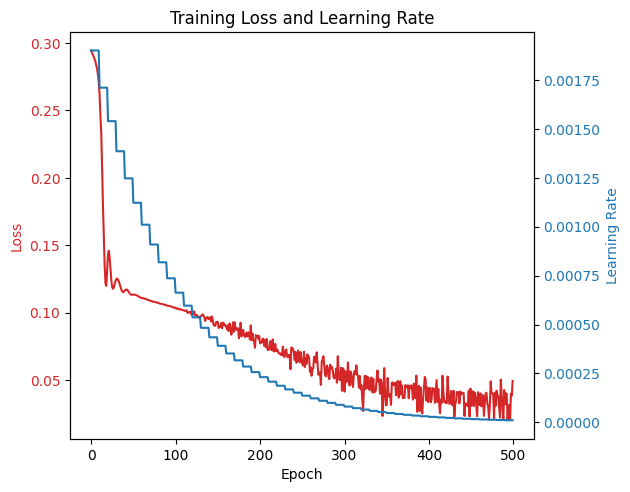

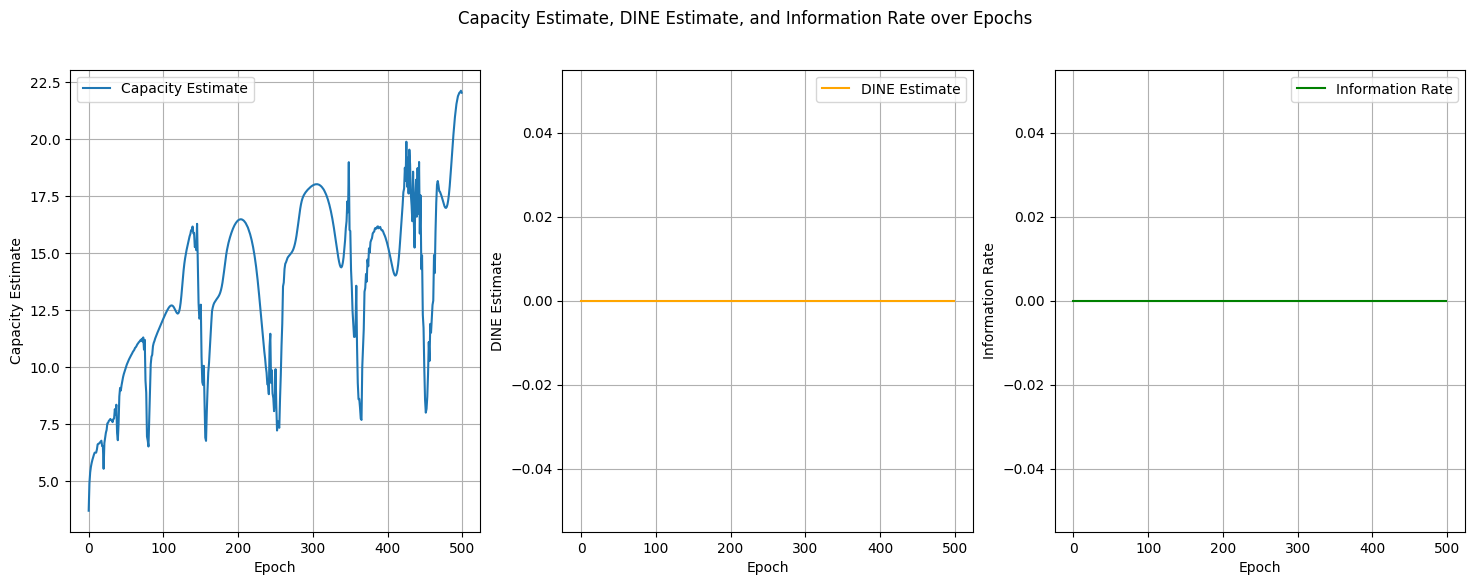

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import logging
import math
import matplotlib.pyplot as plt

logger = logging.getLogger("logger")

class ModelMetrics(tf.keras.metrics.Metric):
    def __init__(self, writer, name='', **kwargs):
        super(ModelMetrics, self).__init__(name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            DI_bits(name='di_bits')]

    def update_state(self, t_y, t_xy, **kwargs):
        t_y = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_y]
        t_xy = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_xy]

        if not isinstance(t_y, (list, tuple)) or len(t_y) < 2:
            raise ValueError("Invalid t_y format. Expected lists with at least two elements.")
        if not isinstance(t_xy, (list, tuple)) or len(t_xy) < 2:
            raise ValueError("Invalid t_xy format. Expected lists with at least two elements.")

        self.metric_pool[0].update_state(t_xy[0], t_xy[1])
        self.metric_pool[1].update_state(t_y[0], t_y[1])
        self.metric_pool[2].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])
        self.metric_pool[3].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class DV(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DV, self).__init__(name=name, **kwargs)
        self.T = self.add_weight(name='t', initializer='zeros')
        self.exp_T_bar = self.add_weight(name='exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, T, T_bar, **kwargs):
        self.T.assign_add(tf.reduce_sum(T))
        self.exp_T_bar.assign_add(tf.reduce_sum(T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss = self.T / self.global_counter - K.log(self.exp_T_bar / self.global_counter_ref)
        return loss

class DI(tf.keras.metrics.Metric):  # estimated DI calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DI, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return loss_xy - loss_y

class DI_bits(tf.keras.metrics.Metric):  # estimated DI calculation metric class in bits
    def __init__(self, name='dv_loss', **kwargs):
        super(DI_bits, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return (loss_xy - loss_y) / math.log(2)

class PMF(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(PMF, self).__init__(name=name, **kwargs)
        self.p = self.add_weight(name='p', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')

    def update_state(self, p, **kwargs):
        self.p.assign_add(tf.reduce_sum(p))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(p.shape[:-1]), dtype=tf.float32))

    def result(self):
        result = self.p / self.global_counter
        return result

class ModelWithEncMetrics(ModelMetrics):
    def __init__(self, writer, name='', **kwargs):
        super(ModelWithEncMetrics, self).__init__(writer=writer, name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            PMF(name='p_mean'),
                            DI_bits(name='di_bits_{}'.format(name))]

    def update_state(self, data, **kwargs):
        [t_y, t_xy, p] = data
        self.metric_pool[0].update_state(t_xy, t_xy)
        self.metric_pool[1].update_state(t_y, t_y)
        self.metric_pool[2].update_state(t_y, t_y, t_xy, t_xy)
        self.metric_pool[3].update_state(p)
        self.metric_pool[4].update_state(t_y, t_y, t_xy, t_xy)

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class CapEstDI(object):
    def __init__(self, model, data, config):
        self.model = model
        self.data_iterators = data
        self.config = config
        self.loss_fn = tf.keras.losses.Huber()
        self.learning_rate = config['lr']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.metrics = ModelWithEncMetrics(tf.summary.create_file_writer(config['tensor_board_dir']), name='cap_est_metrics')
        self.feedback = (config['feedback'] == 1)
        self.T = config['T']
        self.capacity_estimates = []
        self.dine_estimates = []
        self.info_rates = []

    def train_epoch(self, epoch):
        self.metrics.reset_states()
        self.reset_model_states()

        for _ in range(self.config['batches']):
            x, y = self.data_iterators.gen_data()
            x_y_combined = tf.concat([x, y], axis=-1)
            with tf.GradientTape() as tape:
                predictions = self.model(x_y_combined, training=True)
                loss = self.loss_fn(y, predictions)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            self.metrics.update_state([loss, loss, tf.zeros_like(loss)])

        self.metrics.log_metrics(epoch, model_name="Training")

        # Store estimates
        self.capacity_estimates.append(self.metrics.metric_pool[0].result().numpy())
        self.dine_estimates.append(self.metrics.metric_pool[2].result().numpy())
        self.info_rates.append(self.metrics.metric_pool[3].result().numpy())

    def evaluate(self, epoch):
        self.metrics.reset_states()
        x, y = self.data_iterators.gen_data()
        x_y_combined = tf.concat([x, y], axis=-1)
        predictions = self.model(x_y_combined, training=False)
        loss = self.loss_fn(y, predictions)
        self.metrics.update_state([loss, loss, tf.zeros_like(loss)])
        self.metrics.log_metrics(epoch, model_name="Evaluation")

    def train(self, num_epochs=None):
        if num_epochs is None:
            num_epochs = self.config.get('num_epochs', 500)

        for epoch in range(num_epochs):
            if epoch % self.config['eval_freq'] == 0:
                self.evaluate(epoch)
            self.train_epoch(epoch)

        self.evaluate(num_epochs)

    def reset_model_states(self):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states') and layer.stateful:
                layer.reset_states()

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = tf.keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = tf.keras.Input(shape=input_shape, batch_size=config['batch_size'])
    x = tf.keras.layers.LSTM(DV_hidden[0], return_sequences=True, stateful=True, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = tf.keras.layers.Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = tf.keras.layers.Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = tf.keras.layers.Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

# Configuration
config = {
    'GE_b': 0.0005,
    'GE_g': 0.0015,
    'GE_p_b': 0.5,
    'GE_p_g': 0.02,
    'T': 3,
    'alphabet_size': 2,
    'batch_size': 10,
    'batch_size_eval': 5000,
    'batches': 15,
    'bptt': 6,
    'channel_name': 'trapdoor',
    'clip_grad_norm': 1,
    'clip_grad_norm_enc': 0.2,
    'clip_grad_norm_q': 100,
    'clip_likelihood_ratio': [-10.0, 10.0],
    'compression_flag': 0,
    'config': './configs/capacity_estimation.json',
    'contrastive_duplicates': 5,
    'data_name': 'encoder',
    'decay': 0,
    'dropout': 0,
    'dtype': 'binary',
    'enc_dropout': 0.0,
    'enc_hidden': [100, 50],
    'enc_hidden_lstm': 50,
    'enc_last_hidden': 1,
    'eta_post': 0.5,
    'eval_epoch_len': 500,
    'eval_freq': 200,
    'exp_name': 'cap_est',
    'feedback': 1,
    'hidden_size': [100, 150, 10],
    'hidden_size_compression': [100, 2, 100],
    'long_eval_epoch_len': 100,
    'lr': 0.0019,
    'lr_SGD': 0.2,
    'max_norm_xy': 5,
    'max_norm_y': 5,
    'model_name': 'cap_est',
    'noise_layer_q_std': 0.05,
    'num_epochs': 500,  # Number of epochs set to 500
    'optimizer': 'adam',
    'p_bec': 0.3,
    'p_bsc': 0.5,
    'p_ising': 0.5,
    'p_post': 0.5,
    'p_trapdoor': 0.5,
    'p_z': 0.9,
    'q_lstm_units': 25,
    'q_train_freq': 5,
    'quiet': False,
    'reset_channel': 0,
    'run_name': 'ff',
    's_alphabet': 2,
    'seed': 468695,
    'tag_name': 'temp_debugging',
    'tensor_board_dir': './results/cap_est/encoder/ff/temp_debugging/2024-06-17_14-22-31_468695',
    'train_epoch_len': 50,
    'trainer_name': 'cap_est',
    'using_wandb': 0,
    'visualize_epoch_len': 50,
    'weight_decay': 0.0,
    'with_p': 0,
    'x_dim': 1,
    'y_im': 1,
    'output_activation': 'linear'
}

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

x_y_combined = tf.concat([x, y], axis=-1)

input_shape = (config['bptt'], 2)
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)
complex_model_v3.compile(optimizer=optimizer, loss=tf.keras.losses.Huber())

def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Train the model to capture the loss history
complex_model_v3.fit(x_y_combined, y, epochs=config['num_epochs'], batch_size=config['batch_size'], callbacks=[callback, loss_history])

# Initialize metrics
writer = tf.summary.create_file_writer(config['tensor_board_dir'])
metrics = ModelWithEncMetrics(writer, name='training_metrics')

# Initialize the capacity estimation object
capacity_estimator = CapEstDI(complex_model_v3, ising_data, config)

# Training loop with learning rate scheduler
for epoch in range(config['num_epochs']):
    capacity_estimator.train_epoch(epoch)
    metrics.update_state([tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.zeros_like(tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32))])
    metrics.log_metrics(epoch, model_name='Training')

    if epoch % config['eval_freq'] == 0:
        capacity_estimator.evaluate(epoch)

# Plotting loss and learning rate
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(range(len(loss_history.lr)), loss_history.lr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Learning Rate')
plt.show()

# Plotting the results for Capacity Estimate, DINE Estimate, and Information Rate
epochs = list(range(config['num_epochs']))

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Capacity Estimate
axs[0].plot(epochs, capacity_estimator.capacity_estimates, label='Capacity Estimate')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Capacity Estimate')
axs[0].legend()
axs[0].grid(True)

# Plot DINE Estimate
axs[1].plot(epochs, capacity_estimator.dine_estimates, label='DINE Estimate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('DINE Estimate')
axs[1].legend()
axs[1].grid(True)

# Plot Information Rate
axs[2].plot(epochs, capacity_estimator.info_rates, label='Information Rate', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Information Rate')
axs[2].legend()
axs[2].grid(True)

plt.suptitle('Capacity Estimate, DINE Estimate, and Information Rate over Epochs')
plt.show()


x data check: 0 0
y data check: 0 0

Epoch 1: LearningRateScheduler setting learning rate to 0.0001900000061141327.
Epoch 1/500
1/1 [==============================] - 6s 6s/step - loss: 2.8188 - lr: 1.9000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0001900000061141327.
Epoch 2/500
1/1 [==============================] - 0s 15ms/step - loss: 2.8025 - lr: 1.9000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001900000061141327.
Epoch 3/500
1/1 [==============================] - 0s 14ms/step - loss: 2.7866 - lr: 1.9000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001900000061141327.
Epoch 4/500
1/1 [==============================] - 0s 14ms/step - loss: 2.7713 - lr: 1.9000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0001900000061141327.
Epoch 5/500
1/1 [==============================] - 0s 13ms/step - loss: 2.7563 - lr: 1.9000e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0001900000061141327.
Epoch 

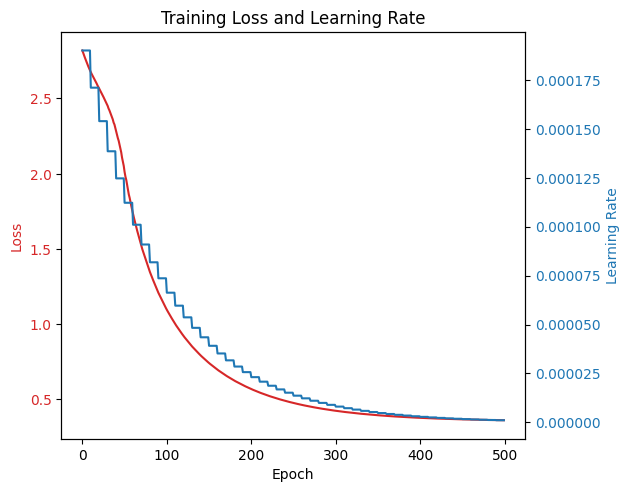

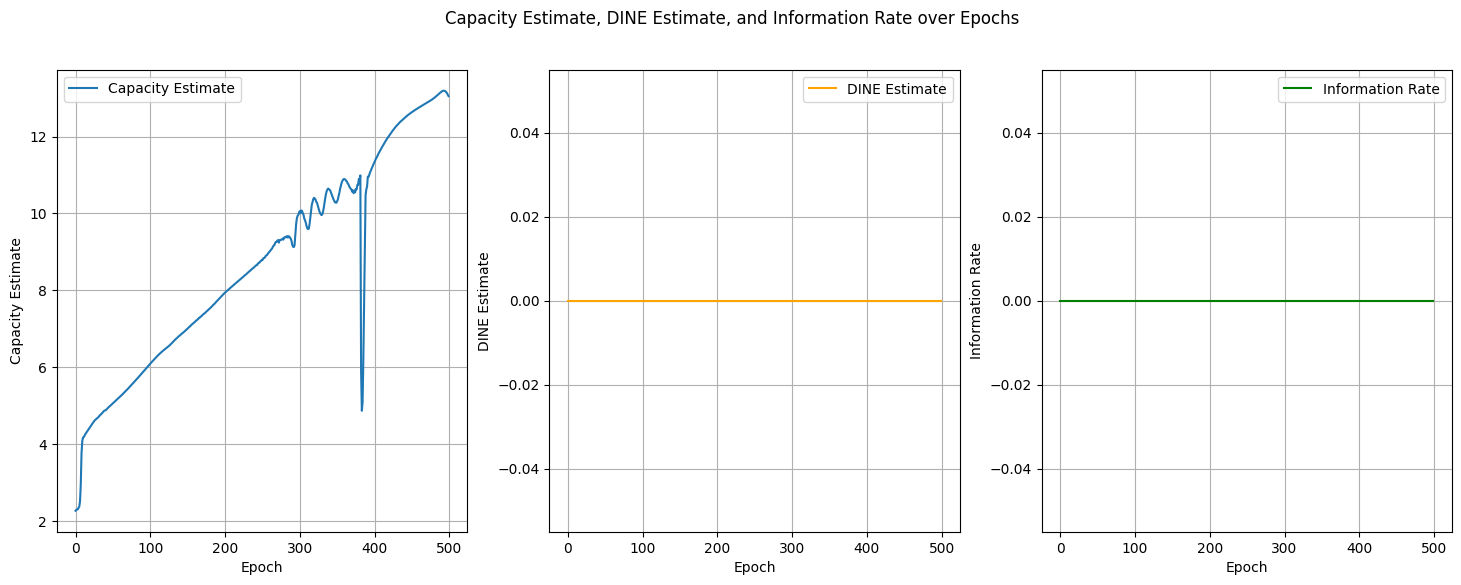

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import logging
import math
import matplotlib.pyplot as plt

logger = logging.getLogger("logger")

class ModelMetrics(tf.keras.metrics.Metric):
    def __init__(self, writer, name='', **kwargs):
        super(ModelMetrics, self).__init__(name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            DI_bits(name='di_bits')]

    def update_state(self, t_y, t_xy, **kwargs):
        t_y = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_y]
        t_xy = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_xy]

        if not isinstance(t_y, (list, tuple)) or len(t_y) < 2:
            raise ValueError("Invalid t_y format. Expected lists with at least two elements.")
        if not isinstance(t_xy, (list, tuple)) or len(t_xy) < 2:
            raise ValueError("Invalid t_xy format. Expected lists with at least two elements.")

        self.metric_pool[0].update_state(t_xy[0], t_xy[1])
        self.metric_pool[1].update_state(t_y[0], t_y[1])
        self.metric_pool[2].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])
        self.metric_pool[3].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class DV(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DV, self).__init__(name=name, **kwargs)
        self.T = self.add_weight(name='t', initializer='zeros')
        self.exp_T_bar = self.add_weight(name='exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, T, T_bar, **kwargs):
        self.T.assign_add(tf.reduce_sum(T))
        self.exp_T_bar.assign_add(tf.reduce_sum(T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss = self.T / self.global_counter - K.log(self.exp_T_bar / self.global_counter_ref)
        return loss

class DI(tf.keras.metrics.Metric):  # estimated DI calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DI, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return loss_xy - loss_y

class DI_bits(tf.keras.metrics.Metric):  # estimated DI calculation metric class in bits
    def __init__(self, name='dv_loss', **kwargs):
        super(DI_bits, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return (loss_xy - loss_y) / math.log(2)

class PMF(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(PMF, self).__init__(name=name, **kwargs)
        self.p = self.add_weight(name='p', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')

    def update_state(self, p, **kwargs):
        self.p.assign_add(tf.reduce_sum(p))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(p.shape[:-1]), dtype=tf.float32))

    def result(self):
        result = self.p / self.global_counter
        return result

class ModelWithEncMetrics(ModelMetrics):
    def __init__(self, writer, name='', **kwargs):
        super(ModelWithEncMetrics, self).__init__(writer=writer, name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            PMF(name='p_mean'),
                            DI_bits(name='di_bits_{}'.format(name))]

    def update_state(self, data, **kwargs):
        [t_y, t_xy, p] = data
        self.metric_pool[0].update_state(t_xy, t_xy)
        self.metric_pool[1].update_state(t_y, t_y)
        self.metric_pool[2].update_state(t_y, t_y, t_xy, t_xy)
        self.metric_pool[3].update_state(p)
        self.metric_pool[4].update_state(t_y, t_y, t_xy, t_xy)

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class CapEstDI(object):
    def __init__(self, model, data, config):
        self.model = model
        self.data_iterators = data
        self.config = config
        self.loss_fn = tf.keras.losses.Huber()
        self.learning_rate = config['lr']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.metrics = ModelWithEncMetrics(tf.summary.create_file_writer(config['tensor_board_dir']), name='cap_est_metrics')
        self.feedback = (config['feedback'] == 1)
        self.T = config['T']
        self.capacity_estimates = []
        self.dine_estimates = []
        self.info_rates = []

    def train_epoch(self, epoch):
        self.metrics.reset_states()
        self.reset_model_states()

        for _ in range(self.config['batches']):
            x, y = self.data_iterators.gen_data()
            x_y_combined = tf.concat([x, y], axis=-1)
            with tf.GradientTape() as tape:
                predictions = self.model(x_y_combined, training=True)
                loss = self.loss_fn(y, predictions)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            self.metrics.update_state([loss, loss, tf.zeros_like(loss)])

        self.metrics.log_metrics(epoch, model_name="Training")

        # Store estimates
        self.capacity_estimates.append(self.metrics.metric_pool[0].result().numpy())
        self.dine_estimates.append(self.metrics.metric_pool[2].result().numpy())
        self.info_rates.append(self.metrics.metric_pool[3].result().numpy())

    def evaluate(self, epoch):
        self.metrics.reset_states()
        x, y = self.data_iterators.gen_data()
        x_y_combined = tf.concat([x, y], axis=-1)
        predictions = self.model(x_y_combined, training=False)
        loss = self.loss_fn(y, predictions)
        self.metrics.update_state([loss, loss, tf.zeros_like(loss)])
        self.metrics.log_metrics(epoch, model_name="Evaluation")

    def train(self, num_epochs=None):
        if num_epochs is None:
            num_epochs = self.config.get('num_epochs', 500)

        for epoch in range(num_epochs):
            if epoch % self.config['eval_freq'] == 0:
                self.evaluate(epoch)
            self.train_epoch(epoch)

        self.evaluate(num_epochs)

    def reset_model_states(self):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states') and layer.stateful:
                layer.reset_states()

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = tf.keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = tf.keras.Input(shape=input_shape, batch_size=config['batch_size'])
    x = tf.keras.layers.LSTM(DV_hidden[0], return_sequences=True, stateful=True, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = tf.keras.layers.Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = tf.keras.layers.Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = tf.keras.layers.Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

# Configuration
config = {
    'GE_b': 0.0005,
    'GE_g': 0.0015,
    'GE_p_b': 0.5,
    'GE_p_g': 0.02,
    'T': 3,
    'alphabet_size': 2,
    'batch_size': 100,
    'batch_size_eval': 5000,
    'batches': 15,
    'bptt': 6,
    'channel_name': 'trapdoor',
    'clip_grad_norm': 1,
    'clip_grad_norm_enc': 0.2,
    'clip_grad_norm_q': 100,
    'clip_likelihood_ratio': [-10.0, 10.0],
    'compression_flag': 0,
    'config': './configs/capacity_estimation.json',
    'contrastive_duplicates': 5,
    'data_name': 'encoder',
    'decay': 0,
    'dropout': 0,
    'dtype': 'binary',
    'enc_dropout': 0.0,
    'enc_hidden': [100, 50],
    'enc_hidden_lstm': 50,
    'enc_last_hidden': 1,
    'eta_post': 0.5,
    'eval_epoch_len': 500,
    'eval_freq': 200,
    'exp_name': 'cap_est',
    'feedback': 1,
    'hidden_size': [100, 150, 10],
    'hidden_size_compression': [100, 2, 100],
    'long_eval_epoch_len': 100,
    'lr': 0.00019,
    'lr_SGD': 0.2,
    'max_norm_xy': 5,
    'max_norm_y': 5,
    'model_name': 'cap_est',
    'noise_layer_q_std': 0.05,
    'num_epochs': 500,  # Number of epochs set to 500
    'optimizer': 'adam',
    'p_bec': 0.3,
    'p_bsc': 0.5,
    'p_ising': 0.5,
    'p_post': 0.5,
    'p_trapdoor': 0.5,
    'p_z': 0.9,
    'q_lstm_units': 25,
    'q_train_freq': 5,
    'quiet': False,
    'reset_channel': 0,
    'run_name': 'ff',
    's_alphabet': 2,
    'seed': 468695,
    'tag_name': 'temp_debugging',
    'tensor_board_dir': './results/cap_est/encoder/ff/temp_debugging/2024-06-17_14-22-31_468695',
    'train_epoch_len': 50,
    'trainer_name': 'cap_est',
    'using_wandb': 0,
    'visualize_epoch_len': 50,
    'weight_decay': 0.0,
    'with_p': 0,
    'x_dim': 1,
    'y_im': 1,
    'output_activation': 'linear'
}

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

x_y_combined = tf.concat([x, y], axis=-1)

input_shape = (config['bptt'], 2)
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)
complex_model_v3.compile(optimizer=optimizer, loss=tf.keras.losses.KLDivergence())

def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Train the model to capture the loss history
complex_model_v3.fit(x_y_combined, y, epochs=config['num_epochs'], batch_size=config['batch_size'], callbacks=[callback, loss_history])

# Initialize metrics
writer = tf.summary.create_file_writer(config['tensor_board_dir'])
metrics = ModelWithEncMetrics(writer, name='training_metrics')

# Initialize the capacity estimation object
capacity_estimator = CapEstDI(complex_model_v3, ising_data, config)

# Training loop with learning rate scheduler
for epoch in range(config['num_epochs']):
    capacity_estimator.train_epoch(epoch)
    metrics.update_state([tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.zeros_like(tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32))])
    metrics.log_metrics(epoch, model_name='Training')

    if epoch % config['eval_freq'] == 0:
        capacity_estimator.evaluate(epoch)

# Plotting loss and learning rate
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(range(len(loss_history.lr)), loss_history.lr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Learning Rate')
plt.show()

# Plotting the results for Capacity Estimate, DINE Estimate, and Information Rate
epochs = list(range(config['num_epochs']))

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Capacity Estimate
axs[0].plot(epochs, capacity_estimator.capacity_estimates, label='Capacity Estimate')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Capacity Estimate')
axs[0].legend()
axs[0].grid(True)

# Plot DINE Estimate
axs[1].plot(epochs, capacity_estimator.dine_estimates, label='DINE Estimate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('DINE Estimate')
axs[1].legend()
axs[1].grid(True)

# Plot Information Rate
axs[2].plot(epochs, capacity_estimator.info_rates, label='Information Rate', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Information Rate')
axs[2].legend()
axs[2].grid(True)

plt.suptitle('Capacity Estimate, DINE Estimate, and Information Rate over Epochs')
plt.show()


x data check: 0 0
y data check: 0 0

Epoch 1: LearningRateScheduler setting learning rate to 0.0001900000061141327.
Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1/1 [==============================] - 5s 5s/step - loss: 2.6520 - lr: 1.9000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0001900000061141327.
Epoch 2/500
1/1 [==============================] - 0s 23ms/step - loss: 2.6347 - lr: 1.9000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001900000061141327.
Epoch 3/500
1/1 [==============================] - 0s 21ms/step - loss: 2.6173 - lr: 1.9000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001900000061141327.
Epoch 4/500
1/1 [==============================] - 0s 18ms/step - loss: 2.6005 - lr: 1.9000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0001900000061141327.
Epoch 5/500
1/1 [==============================] - 0s 26ms/step - loss: 2.5840 - lr: 1.9000e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0001900000061141327.
Epoch 6/500
1/1 [==============================] - 0s 21ms/step - loss: 2.5680 - lr: 1.9000e-04

Epoch 7: LearningRateScheduler settin

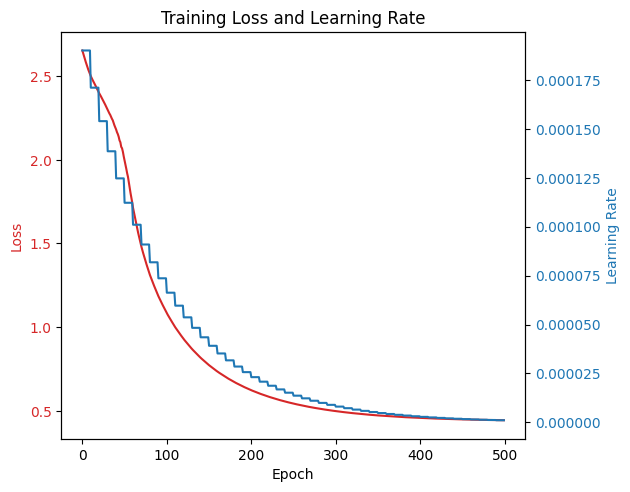

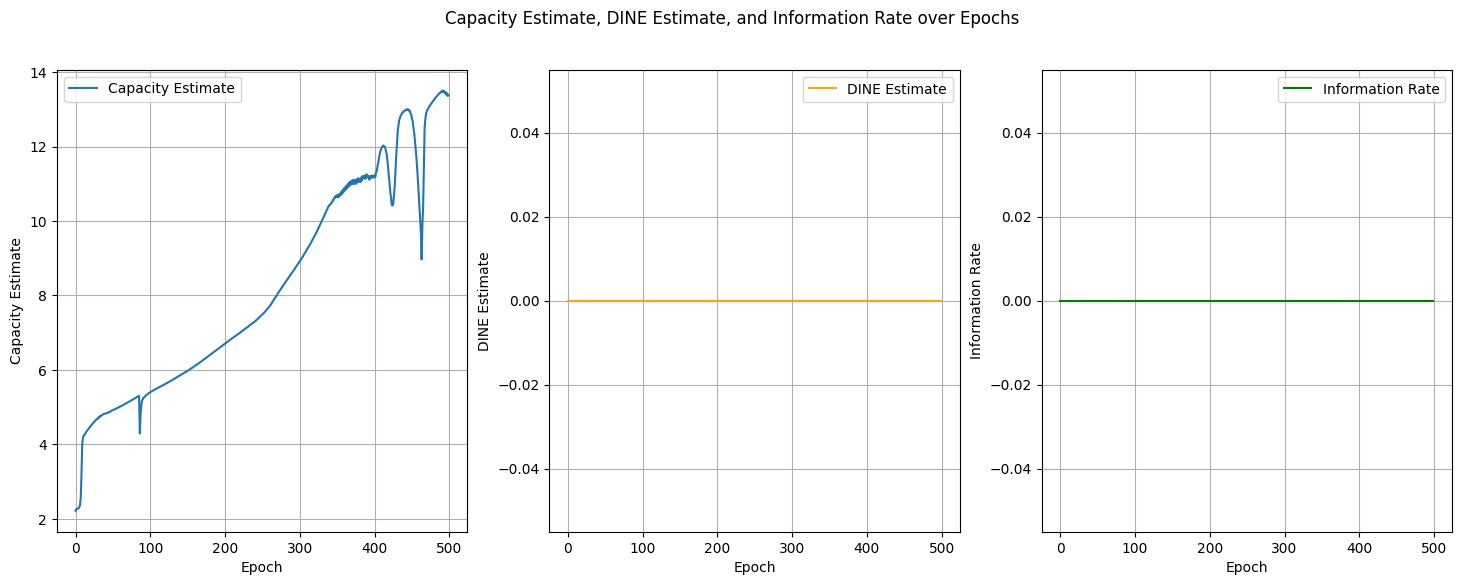

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import logging
import math
import matplotlib.pyplot as plt

logger = logging.getLogger("logger")

class ModelMetrics(tf.keras.metrics.Metric):
    def __init__(self, writer, name='', **kwargs):
        super(ModelMetrics, self).__init__(name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            DI_bits(name='di_bits')]

    def update_state(self, t_y, t_xy, **kwargs):
        t_y = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_y]
        t_xy = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_xy]

        if not isinstance(t_y, (list, tuple)) or len(t_y) < 2:
            raise ValueError("Invalid t_y format. Expected lists with at least two elements.")
        if not isinstance(t_xy, (list, tuple)) or len(t_xy) < 2:
            raise ValueError("Invalid t_xy format. Expected lists with at least two elements.")

        self.metric_pool[0].update_state(t_xy[0], t_xy[1])
        self.metric_pool[1].update_state(t_y[0], t_y[1])
        self.metric_pool[2].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])
        self.metric_pool[3].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class DV(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DV, self).__init__(name=name, **kwargs)
        self.T = self.add_weight(name='t', initializer='zeros')
        self.exp_T_bar = self.add_weight(name='exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, T, T_bar, **kwargs):
        self.T.assign_add(tf.reduce_sum(T))
        self.exp_T_bar.assign_add(tf.reduce_sum(T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss = self.T / self.global_counter - K.log(self.exp_T_bar / self.global_counter_ref)
        return loss

class DI(tf.keras.metrics.Metric):  # estimated DI calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DI, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return loss_xy - loss_y

class DI_bits(tf.keras.metrics.Metric):  # estimated DI calculation metric class in bits
    def __init__(self, name='dv_loss', **kwargs):
        super(DI_bits, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(self.c_exp_T_bar / self.global_counter_ref)
        loss_xy = self.xc_T / self.global_counter - K.log(self.xc_exp_T_bar / self.global_counter_ref)
        return (loss_xy - loss_y) / math.log(2)

class PMF(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(PMF, self).__init__(name=name, **kwargs)
        self.p = self.add_weight(name='p', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')

    def update_state(self, p, **kwargs):
        self.p.assign_add(tf.reduce_sum(p))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(p.shape[:-1]), dtype=tf.float32))

    def result(self):
        result = self.p / self.global_counter
        return result

class ModelWithEncMetrics(ModelMetrics):
    def __init__(self, writer, name='', **kwargs):
        super(ModelWithEncMetrics, self).__init__(writer=writer, name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            PMF(name='p_mean'),
                            DI_bits(name='di_bits_{}'.format(name))]

    def update_state(self, data, **kwargs):
        [t_y, t_xy, p] = data
        self.metric_pool[0].update_state(t_xy, t_xy)
        self.metric_pool[1].update_state(t_y, t_y)
        self.metric_pool[2].update_state(t_y, t_y, t_xy, t_xy)
        self.metric_pool[3].update_state(p)
        self.metric_pool[4].update_state(t_y, t_y, t_xy, t_xy)

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class CapEstDI(object):
    def __init__(self, model, data, config):
        self.model = model
        self.data_iterators = data
        self.config = config
        self.loss_fn = tf.keras.losses.Huber()
        self.learning_rate = config['lr']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.metrics = ModelWithEncMetrics(tf.summary.create_file_writer(config['tensor_board_dir']), name='cap_est_metrics')
        self.feedback = (config['feedback'] == 1)
        self.T = config['T']
        self.capacity_estimates = []
        self.dine_estimates = []
        self.info_rates = []

    def train_epoch(self, epoch):
        self.metrics.reset_states()
        self.reset_model_states()

        for _ in range(self.config['batches']):
            x, y = self.data_iterators.gen_data()
            x_y_combined = tf.concat([x, y], axis=-1)
            with tf.GradientTape() as tape:
                predictions = self.model(x_y_combined, training=True)
                loss = self.loss_fn(y, predictions)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            self.metrics.update_state([loss, loss, tf.zeros_like(loss)])

        self.metrics.log_metrics(epoch, model_name="Training")

        # Store estimates
        self.capacity_estimates.append(self.metrics.metric_pool[0].result().numpy())
        self.dine_estimates.append(self.metrics.metric_pool[2].result().numpy())
        self.info_rates.append(self.metrics.metric_pool[3].result().numpy())

    def evaluate(self, epoch):
        self.metrics.reset_states()
        x, y = self.data_iterators.gen_data()
        x_y_combined = tf.concat([x, y], axis=-1)
        predictions = self.model(x_y_combined, training=False)
        loss = self.loss_fn(y, predictions)
        self.metrics.update_state([loss, loss, tf.zeros_like(loss)])
        self.metrics.log_metrics(epoch, model_name="Evaluation")

    def train(self, num_epochs=None):
        if num_epochs is None:
            num_epochs = self.config.get('num_epochs', 500)

        for epoch in range(num_epochs):
            if epoch % self.config['eval_freq'] == 0:
                self.evaluate(epoch)
            self.train_epoch(epoch)

        self.evaluate(num_epochs)

    def reset_model_states(self):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states') and layer.stateful:
                layer.reset_states()

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = tf.keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = tf.keras.Input(shape=input_shape, batch_size=config['batch_size'])
    x = tf.keras.layers.LSTM(DV_hidden[0], return_sequences=True, stateful=True, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = tf.keras.layers.Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = tf.keras.layers.Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = tf.keras.layers.Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())


def negative_log_likelihood(y_true, y_pred):
    # Assuming y_pred is the probability distribution (e.g., output of a softmax layer)
    return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(y_pred + 1e-10), axis=-1))


# Configuration
config = {
    'GE_b': 0.0005,
    'GE_g': 0.0015,
    'GE_p_b': 0.5,
    'GE_p_g': 0.02,
    'T': 3,
    'alphabet_size': 2,
    'batch_size': 100,
    'batch_size_eval': 5000,
    'batches': 15,
    'bptt': 6,
    'channel_name': 'trapdoor',
    'clip_grad_norm': 1,
    'clip_grad_norm_enc': 0.2,
    'clip_grad_norm_q': 100,
    'clip_likelihood_ratio': [-10.0, 10.0],
    'compression_flag': 0,
    'config': './configs/capacity_estimation.json',
    'contrastive_duplicates': 5,
    'data_name': 'encoder',
    'decay': 0,
    'dropout': 0,
    'dtype': 'binary',
    'enc_dropout': 0.0,
    'enc_hidden': [100, 50],
    'enc_hidden_lstm': 50,
    'enc_last_hidden': 1,
    'eta_post': 0.5,
    'eval_epoch_len': 500,
    'eval_freq': 200,
    'exp_name': 'cap_est',
    'feedback': 1,
    'hidden_size': [100, 150, 10],
    'hidden_size_compression': [100, 2, 100],
    'long_eval_epoch_len': 100,
    'lr': 0.00019,
    'lr_SGD': 0.2,
    'max_norm_xy': 5,
    'max_norm_y': 5,
    'model_name': 'cap_est',
    'noise_layer_q_std': 0.05,
    'num_epochs': 500,  # Number of epochs set to 500
    'optimizer': 'adam',
    'p_bec': 0.3,
    'p_bsc': 0.5,
    'p_ising': 0.5,
    'p_post': 0.5,
    'p_trapdoor': 0.5,
    'p_z': 0.9,
    'q_lstm_units': 25,
    'q_train_freq': 5,
    'quiet': False,
    'reset_channel': 0,
    'run_name': 'ff',
    's_alphabet': 2,
    'seed': 468695,
    'tag_name': 'temp_debugging',
    'tensor_board_dir': './results/cap_est/encoder/ff/temp_debugging/2024-06-17_14-22-31_468695',
    'train_epoch_len': 50,
    'trainer_name': 'cap_est',
    'using_wandb': 0,
    'visualize_epoch_len': 50,
    'weight_decay': 0.0,
    'with_p': 0,
    'x_dim': 1,
    'y_im': 1,
    'output_activation': 'linear'
}

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

x_y_combined = tf.concat([x, y], axis=-1)

input_shape = (config['bptt'], 2)
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)
complex_model_v3.compile(optimizer=optimizer, loss=negative_log_likelihood)

def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Train the model to capture the loss history
complex_model_v3.fit(x_y_combined, y, epochs=config['num_epochs'], batch_size=config['batch_size'], callbacks=[callback, loss_history])

# Initialize metrics
writer = tf.summary.create_file_writer(config['tensor_board_dir'])
metrics = ModelWithEncMetrics(writer, name='training_metrics')

# Initialize the capacity estimation object
capacity_estimator = CapEstDI(complex_model_v3, ising_data, config)

# Training loop with learning rate scheduler
for epoch in range(config['num_epochs']):
    capacity_estimator.train_epoch(epoch)
    metrics.update_state([tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.zeros_like(tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32))])
    metrics.log_metrics(epoch, model_name='Training')

    if epoch % config['eval_freq'] == 0:
        capacity_estimator.evaluate(epoch)

# Plotting loss and learning rate
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(range(len(loss_history.lr)), loss_history.lr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Learning Rate')
plt.show()

# Plotting the results for Capacity Estimate, DINE Estimate, and Information Rate
epochs = list(range(config['num_epochs']))

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Capacity Estimate
axs[0].plot(epochs, capacity_estimator.capacity_estimates, label='Capacity Estimate')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Capacity Estimate')
axs[0].legend()
axs[0].grid(True)

# Plot DINE Estimate
axs[1].plot(epochs, capacity_estimator.dine_estimates, label='DINE Estimate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('DINE Estimate')
axs[1].legend()
axs[1].grid(True)

# Plot Information Rate
axs[2].plot(epochs, capacity_estimator.info_rates, label='Information Rate', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Information Rate')
axs[2].legend()
axs[2].grid(True)

plt.suptitle('Capacity Estimate, DINE Estimate, and Information Rate over Epochs')
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import logging
import math
import matplotlib.pyplot as plt

logger = logging.getLogger("logger")

class GridWorldMDP:
    def __init__(self, grid_size, start_state, goal_state):
        self.grid_size = grid_size
        self.start_state = start_state
        self.goal_state = goal_state
        self.state = start_state

    def reset(self):
        self.state = self.start_state
        return self.state

    def step(self, action):
        # Define possible actions: 0=up, 1=right, 2=down, 3=left
        if action == 0 and self.state[0] > 0:
            self.state = (self.state[0] - 1, self.state[1])
        elif action == 1 and self.state[1] < self.grid_size[1] - 1:
            self.state = (self.state[0], self.state[1] + 1)
        elif action == 2 and self.state[0] < self.grid_size[0] - 1:
            self.state = (self.state[0] + 1, self.state[1])
        elif action == 3 and self.state[1] > 0:
            self.state = (self.state[0], self.state[1] - 1)

        reward = -1  # default reward for non-terminal states
        done = False
        if self.state == self.goal_state:
            reward = 0  # reward for reaching the goal
            done = True

        return self.state, reward, done

class PolicyNetwork(tf.keras.Model):
    def __init__(self, action_size):
        super(PolicyNetwork, self).__init__()
        self.dense1 = tf.keras.layers.Dense(24, activation='relu')
        self.dense2 = tf.keras.layers.Dense(24, activation='relu')
        self.logits = tf.keras.layers.Dense(action_size)

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        return self.logits(x)

class ModelMetrics(tf.keras.metrics.Metric):
    def __init__(self, writer, name='', **kwargs):
        super(ModelMetrics, self).__init__(name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            DI_bits(name='di_bits')]

    def update_state(self, t_y, t_xy, **kwargs):
        t_y = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_y]
        t_xy = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_xy]

        if not isinstance(t_y, (list, tuple)) or len(t_y) < 2:
            raise ValueError("Invalid t_y format. Expected lists with at least two elements.")
        if not isinstance(t_xy, (list, tuple)) or len(t_xy) < 2:
            raise ValueError("Invalid t_xy format. Expected lists with at least two elements.")

        self.metric_pool[0].update_state(t_xy[0], t_xy[1])
        self.metric_pool[1].update_state(t_y[0], t_y[1])
        self.metric_pool[2].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])
        self.metric_pool[3].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class DV(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='dv_loss', **kwargs):
        super(DV, self).__init__(name=name, **kwargs)
        self.T = self.add_weight(name='t', initializer='zeros')
        self.exp_T_bar = self.add_weight(name='exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, T, T_bar, **kwargs):
        self.T.assign_add(tf.reduce_sum(T))
        self.exp_T_bar.assign_add(tf.reduce_sum(T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        T_value = self.T / self.global_counter
        exp_T_bar_value = self.exp_T_bar / self.global_counter_ref

        # Ensure exp_T_bar_value is not zero to avoid log(0)
        exp_T_bar_value = tf.maximum(exp_T_bar_value, 1e-10)

        loss = T_value - K.log(exp_T_bar_value)
        return loss

class DI(tf.keras.metrics.Metric):  # estimated DI calculation metric class
    def __init__(self, name='di_loss', **kwargs):
        super(DI, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(tf.maximum(self.c_exp_T_bar / self.global_counter_ref, 1e-10))
        loss_xy = self.xc_T / self.global_counter - K.log(tf.maximum(self.xc_exp_T_bar / self.global_counter_ref, 1e-10))

        # Check for NaNs before computing the loss
        if tf.math.is_nan(loss_y) or tf.math.is_nan(loss_xy):
            tf.print("NaN detected in DI result calculation")
            tf.print("loss_y:", loss_y)
            tf.print("loss_xy:", loss_xy)

        return loss_xy - loss_y

class DI_bits(tf.keras.metrics.Metric):  # estimated DI calculation metric class in bits
    def __init__(self, name='di_bits_loss', **kwargs):
        super(DI_bits, self).__init__(name=name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / self.global_counter - K.log(tf.maximum(self.c_exp_T_bar / self.global_counter_ref, 1e-10))
        loss_xy = self.xc_T / self.global_counter - K.log(tf.maximum(self.xc_exp_T_bar / self.global_counter_ref, 1e-10))

        # Check for NaNs before computing the loss
        if tf.math.is_nan(loss_y) or tf.math.is_nan(loss_xy):
            tf.print("NaN detected in DI_bits result calculation")
            tf.print("loss_y:", loss_y)
            tf.print("loss_xy:", loss_xy)

        return (loss_xy - loss_y) / math.log(2)

class PMF(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, name='pmf_loss', **kwargs):
        super(PMF, self).__init__(name=name, **kwargs)
        self.p = self.add_weight(name='p', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')

    def update_state(self, p, **kwargs):
        self.p.assign_add(tf.reduce_sum(p))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(p.shape[:-1]), dtype=tf.float32))

    def result(self):
        result = self.p / self.global_counter

        # Check for NaNs before returning the result
        if tf.math.is_nan(result):
            tf.print("NaN detected in PMF result calculation")
            tf.print("result:", result)

        return result

class ModelWithEncMetrics(ModelMetrics):
    def __init__(self, writer, name='', **kwargs):
        super(ModelWithEncMetrics, self).__init__(writer=writer, name=name, **kwargs)
        self.writer = writer
        self.metric_pool = [DV(name='dv_xy_{}'.format(name)),
                            DV(name='dv_y_{}'.format(name)),
                            DI(name='di_{}'.format(name)),
                            PMF(name='p_mean'),
                            DI_bits(name='di_bits_{}'.format(name))]

    def update_state(self, data, **kwargs):
        [t_y, t_xy, p] = data
        self.metric_pool[0].update_state(t_xy, t_xy)
        self.metric_pool[1].update_state(t_y, t_y)
        self.metric_pool[2].update_state(t_y, t_y, t_xy, t_xy)
        self.metric_pool[3].update_state(p)
        self.metric_pool[4].update_state(t_y, t_y, t_xy, t_xy)

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            if np.isnan(metric.result()):
                raise ValueError("NaN appeared in metric {}".format(metric.name))
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(metric.result())))
        msg.append(model_name)
        logger.info("\t".join(msg))

class CapEstDI(object):
    def __init__(self, model, data, config):
        self.model = model
        self.data_iterators = data
        self.config = config
        self.loss_fn = negative_log_likelihood
        self.learning_rate = config['lr']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.metrics = ModelWithEncMetrics(tf.summary.create_file_writer(config['tensor_board_dir']), name='cap_est_metrics')
        self.feedback = (config['feedback'] == 1)
        self.T = config['T']
        self.capacity_estimates = []
        self.dine_estimates = []
        self.info_rates = []

    def train_epoch(self, epoch):
        self.metrics.reset_states()
        self.reset_model_states()

        for _ in range(self.config['batches']):
            x, y = self.data_iterators.gen_data()
            x_y_combined = tf.concat([x, y], axis=-1)
            with tf.GradientTape() as tape:
                predictions = self.model(x_y_combined, training=True)
                loss = self.loss_fn(y, predictions)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            self.metrics.update_state([loss, loss, tf.zeros_like(loss)])

        self.metrics.log_metrics(epoch, model_name="Training")

        # Store estimates
        self.capacity_estimates.append(self.metrics.metric_pool[0].result().numpy())
        self.dine_estimates.append(self.metrics.metric_pool[2].result().numpy())
        self.info_rates.append(self.metrics.metric_pool[3].result().numpy())

    def evaluate(self, epoch):
        self.metrics.reset_states()
        x, y = self.data_iterators.gen_data()
        x_y_combined = tf.concat([x, y], axis=-1)
        predictions = self.model(x_y_combined, training=False)
        loss = self.loss_fn(y, predictions)
        self.metrics.update_state([loss, loss, tf.zeros_like(loss)])
        self.metrics.log_metrics(epoch, model_name="Evaluation")

    def train(self, num_epochs=None):
        if num_epochs is None:
            num_epochs = self.config.get('num_epochs', 500)

        for epoch in range(num_epochs):
            if epoch % self.config['eval_freq'] == 0:
                self.evaluate(epoch)
            self.train_epoch(epoch)

        self.evaluate(num_epochs)

    def reset_model_states(self):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states') and layer.stateful:
                layer.reset_states()

class Ising_Data(object):
    def __init__(self, config, mdp, policy_network):
        self.config = config
        self.mdp = mdp  # Add MDP environment
        self.policy_network = policy_network
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'])
        self.gamma = 0.99  # Discount factor for rewards
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.initialize_channel()
        self.y = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)

    def initialize_channel(self):
        self.state = self.mdp.reset()
        self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)
        self.x = tf.cast(tf.random.categorical(logits=self.gen_logits(0.5), num_samples=1), dtype=tf.float32)
        self.x = tf.expand_dims(self.x, axis=-1)
        self.s = self.s_past  # Initialize self.s

    def gen_data(self):
        x_l, y_l = [], []
        states, actions, rewards = [], [], []
        done = False
        self.state = self.mdp.reset()

        for _ in range(self.config['bptt']):
            # Convert state to TensorFlow tensor
            state_tensor = tf.convert_to_tensor(self.state, dtype=tf.float32)
            state_tensor = tf.expand_dims(state_tensor, axis=0)  # Add batch dimension

            # Get policy network logits and probabilities
            logits = self.policy_network(state_tensor)
            action_probs = tf.nn.softmax(logits)

            # Sample action
            action = tf.random.categorical(logits, 1)[0, 0]
            action_int = int(action.numpy())

            # Take a step in the MDP environment
            new_state, reward, done = self.mdp.step(action_int)

            # Store data for training
            states.append(state_tensor)
            actions.append(action_int)  # Store the action taken
            rewards.append(reward)
            x_l.append(self.x)  # Assuming self.x is already a TensorFlow tensor
            y_l.append(self.y)  # Assuming self.y is already a TensorFlow tensor

            # Update state based on done flag
            if done:
                self.state = self.mdp.reset()  # Reset the MDP if done
            else:
                self.state = new_state

        # Concatenate data for training
        x = tf.concat(x_l, axis=0)  # Concatenate along the batch axis (assuming x_l are batched tensors)
        y = tf.concat(y_l, axis=0)  # Concatenate along the batch axis (assuming y_l are batched tensors)

        # Perform policy gradient update (assumed to be in a separate function)
        self.update_policy(states, actions, rewards)

        return x, y

    def update_policy(self, states, actions, rewards):
        G = 0
        returns = []
        for r in rewards[::-1]:
            G = r + self.gamma * G
            returns.insert(0, G)
        returns = tf.convert_to_tensor(returns, dtype=tf.float32)

        with tf.GradientTape() as tape:
            loss = 0
            for logit, action, G in zip(states, actions, returns):
                logit = tf.reshape(logit, [-1, logit.shape[-1]])  # Reshape to [batch_size, action_size]
                action_prob = tf.nn.softmax(logit)

                selected_action_prob = tf.reduce_sum(action_prob * tf.one_hot(action, action_prob.shape[-1]))
                loss -= tf.math.log(selected_action_prob + 1e-10) * G  # Policy gradient loss

        gradients = tape.gradient(loss, self.policy_network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.policy_network.trainable_variables))

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)
        return logits

    def encoder(self, step=None):
        if step == 0:
            self.state = self.mdp.reset()
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)
            self.x = tf.cast(tf.random.categorical(logits=self.gen_logits(0.5), num_samples=1), dtype=tf.float32)
            self.x = tf.expand_dims(self.x, axis=-1)
            self.s = self.s_past  # Initialize self.s
        else:
            state_tensor = tf.convert_to_tensor(self.state, dtype=tf.float32)
            state_tensor = tf.expand_dims(state_tensor, axis=0)  # Add batch dimension
            logits = self.policy_network(state_tensor)
            action_probs = tf.nn.softmax(logits)
            action = np.random.choice(4, p=action_probs.numpy().flatten())  # Sample action from policy
            new_state, reward, done = self.mdp.step(action)

            z = tf.cast(tf.random.categorical(logits=self.gen_logits(0.5), num_samples=1), dtype=tf.float32)
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.gen_logits(0.5), num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = tf.keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = tf.keras.Input(shape=input_shape, batch_size=config['batch_size'])
    x = tf.keras.layers.LSTM(DV_hidden[0], return_sequences=True, stateful=True, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = tf.keras.layers.Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = tf.keras.layers.Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = tf.keras.layers.Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

# Negative Log-Likelihood Loss Function
def negative_log_likelihood(y_true, y_pred):
    # Assuming y_pred is the probability distribution (e.g., output of a softmax layer)
    return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(y_pred + 1e-10), axis=-1))

# Configuration
config = {
    'GE_b': 0.0005,
    'GE_g': 0.0015,
    'GE_p_b': 0.5,
    'GE_p_g': 0.02,
    'T': 3,
    'alphabet_size': 2,
    'batch_size': 100,
    'batch_size_eval': 5000,
    'batches': 15,
    'bptt': 6,
    'channel_name': 'ising',  # Updated from 'trapdoor' to 'ising'
    'clip_grad_norm': 1,
    'clip_grad_norm_enc': 0.2,
    'clip_grad_norm_q': 100,
    'clip_likelihood_ratio': [-10.0, 10.0],
    'compression_flag': 0,
    'config': './configs/capacity_estimation.json',
    'contrastive_duplicates': 5,
    'data_name': 'encoder',
    'decay': 0,
    'dropout': 0,
    'dtype': 'binary',
    'enc_dropout': 0.0,
    'enc_hidden': [100, 50],
    'enc_hidden_lstm': 50,
    'enc_last_hidden': 1,
    'eta_post': 0.5,
    'eval_epoch_len': 500,
    'eval_freq': 200,
    'exp_name': 'cap_est',
    'feedback': 1,
    'hidden_size': [100, 150, 10],
    'hidden_size_compression': [100, 2, 100],
    'long_eval_epoch_len': 100,
    'lr': 0.00019,
    'lr_SGD': 0.2,
    'max_norm_xy': 5,
    'max_norm_y': 5,
    'model_name': 'cap_est',
    'noise_layer_q_std': 0.05,
    'num_epochs': 500,
    'optimizer': 'adam',
    'p_bec': 0.3,
    'p_bsc': 0.5,
    'p_ising': 0.5,
    'p_post': 0.5,
    'p_trapdoor': 0.5,
    'p_z': 0.9,
    'q_lstm_units': 25,
    'q_train_freq': 5,
    'quiet': False,
    'reset_channel': 0,
    'run_name': 'ff',
    's_alphabet': 2,
    'seed': 468695,
    'tag_name': 'temp_debugging',
    'tensor_board_dir': './results/cap_est/encoder/ff/temp_debugging/2024-06-17_14-22-31_468695',
    'train_epoch_len': 50,
    'trainer_name': 'cap_est',
    'using_wandb': 0,
    'visualize_epoch_len': 50,
    'weight_decay': 0.0,
    'with_p': 0,
    'x_dim': 1,
    'y_im': 1,
    'output_activation': 'linear'
}

# Initialize the MDP environment
mdp = GridWorldMDP(grid_size=(5, 5), start_state=(0, 0), goal_state=(4, 4))

# Initialize the policy network
policy_network = PolicyNetwork(action_size=4)

# Initialize the data generator with the MDP and policy network
ising_data = Ising_Data(config, mdp, policy_network)
x, y = ising_data.gen_data()

print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

x_y_combined = tf.concat([x, y], axis=-1)

input_shape = (config['bptt'], 2)
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)
complex_model_v3.compile(optimizer=optimizer, loss=negative_log_likelihood)

def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Train the model to capture the loss history
complex_model_v3.fit(x_y_combined, y, epochs=config['num_epochs'], batch_size=config['batch_size'], callbacks=[callback, loss_history])

# Initialize metrics
writer = tf.summary.create_file_writer(config['tensor_board_dir'])
metrics = ModelWithEncMetrics(writer, name='training_metrics')

# Initialize the capacity estimation object
capacity_estimator = CapEstDI(complex_model_v3, ising_data, config)

# Training loop with learning rate scheduler
for epoch in range(config['num_epochs']):
    capacity_estimator.train_epoch(epoch)
    metrics.update_state([tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
                          tf.zeros_like(tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32))])
    metrics.log_metrics(epoch, model_name='Training')

    if epoch % config['eval_freq'] == 0:
        capacity_estimator.evaluate(epoch)

# Plotting loss and learning rate
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(range(len(loss_history.lr)), loss_history.lr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Learning Rate')
plt.show()

# Plotting the results for Capacity Estimate, DINE Estimate, and Information Rate
epochs = list(range(config['num_epochs']))

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Capacity Estimate
axs[0].plot(epochs, capacity_estimator.capacity_estimates, label='Capacity Estimate')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Capacity Estimate')
axs[0].legend()
axs[0].grid(True)

# Plot DINE Estimate
axs[1].plot(epochs, capacity_estimator.dine_estimates, label='DINE Estimate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('DINE Estimate')
axs[1].legend()
axs[1].grid(True)

# Plot Information Rate
axs[2].plot(epochs, capacity_estimator.info_rates, label='Information Rate', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Information Rate')
axs[2].legend()
axs[2].grid(True)

plt.suptitle('Capacity Estimate, DINE Estimate, and Information Rate over Epochs')
plt.show()


ValueError: No gradients provided for any variable: (['policy_network/dense/kernel:0', 'policy_network/dense/bias:0', 'policy_network/dense_1/kernel:0', 'policy_network/dense_1/bias:0', 'policy_network/dense_2/kernel:0', 'policy_network/dense_2/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'policy_network/dense/kernel:0' shape=(2, 24) dtype=float32, numpy=
array([[ 0.16189742,  0.15028459,  0.17699522, -0.33448714, -0.42630675,
        -0.47080404,  0.40792465,  0.02582312,  0.43524456, -0.30233705,
         0.38436562,  0.19340968, -0.10732609, -0.22723311,  0.35973102,
         0.37055588, -0.14921421,  0.42442256,  0.06905878, -0.0357691 ,
         0.13705462, -0.29148543,  0.21594465, -0.00510404],
       [ 0.23673081,  0.2534182 ,  0.30858022, -0.4663587 ,  0.45422328,
         0.3271631 ,  0.43433344,  0.39479417, -0.30941182,  0.16296577,
        -0.19284287,  0.4033715 ,  0.4460562 , -0.01473245,  0.05841655,
        -0.1883865 , -0.05267996,  0.08215743,  0.25454795,  0.22835207,
         0.21955943, -0.438284  ,  0.31095552,  0.4442538 ]],
      dtype=float32)>), (None, <tf.Variable 'policy_network/dense/bias:0' shape=(24,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)>), (None, <tf.Variable 'policy_network/dense_1/kernel:0' shape=(24, 24) dtype=float32, numpy=
array([[-1.90272614e-01, -1.15593046e-01, -2.59039253e-01,
        -2.98608482e-01, -2.34036222e-01,  4.49948907e-02,
         3.24701279e-01,  4.39547896e-02,  3.34374696e-01,
        -3.24746102e-01, -8.08793902e-02, -1.15968913e-01,
         4.44010198e-02,  5.71013093e-02, -2.89934665e-01,
        -2.35516921e-01,  1.09101653e-01, -8.14050436e-02,
        -8.09491873e-02, -2.03519791e-01, -4.47000265e-02,
        -3.45214456e-01, -7.62617588e-02,  2.34181792e-01],
       [-2.73513913e-01, -1.70007989e-01, -2.72442877e-01,
        -1.41204417e-01, -5.74843287e-02, -2.34688073e-01,
        -3.31010818e-01, -2.56279111e-02, -2.59312034e-01,
        -3.42183411e-02,  3.22270691e-02,  9.15531516e-02,
         1.96058005e-01, -1.30616203e-01,  2.31479257e-01,
         2.00422198e-01,  3.83927524e-02,  2.39661664e-01,
        -2.85095781e-01, -2.58031011e-01, -4.07300293e-02,
        -3.07574213e-01, -1.24262735e-01, -8.76006484e-03],
       [-1.19335085e-01, -2.79109150e-01,  3.43950480e-01,
         2.17772752e-01, -1.78347424e-01,  3.34815294e-01,
         3.48679125e-02,  2.06339687e-01,  3.52534026e-01,
         1.89547807e-01, -2.92253673e-01,  2.36199170e-01,
         6.24474585e-02, -1.77144885e-01,  6.93739653e-02,
        -2.98409134e-01, -2.13389829e-01,  3.22530299e-01,
         6.16708398e-03, -1.56771272e-01, -8.71419907e-03,
        -1.93530574e-01, -2.49762475e-01, -9.38666761e-02],
       [-2.31288075e-01,  1.42199159e-01,  3.25730592e-01,
        -2.05200106e-01, -1.04784817e-01, -1.54414505e-01,
         3.12218398e-01,  7.00813532e-02,  1.43441498e-01,
        -2.70930141e-01, -1.88671038e-01,  3.38653475e-01,
         1.05094433e-01,  3.19302082e-04,  2.91968971e-01,
        -1.53994977e-01, -2.68462598e-01,  1.12039983e-01,
         5.03131449e-02, -3.52683991e-01, -6.99949265e-03,
        -1.68242961e-01, -1.41018882e-01, -2.81967223e-01],
       [ 1.01440310e-01, -1.29169896e-01,  2.10595131e-02,
        -3.05144697e-01, -2.19479963e-01,  1.62871331e-01,
         2.84976929e-01,  1.85160547e-01, -5.25853634e-02,
        -2.58890569e-01,  5.06241918e-02,  1.69781417e-01,
        -3.40009928e-01,  2.31310219e-01, -2.68361628e-01,
        -2.81345725e-01,  3.25501889e-01, -1.27669290e-01,
        -5.32612205e-02, -2.98131198e-01,  1.77225024e-01,
         2.06760317e-01, -3.05245757e-01,  3.19265753e-01],
       [ 3.49576086e-01,  1.88134104e-01, -2.14946315e-01,
         4.75333929e-02,  2.04385012e-01,  2.51185447e-01,
        -5.54216802e-02,  6.13519847e-02,  9.73280370e-02,
        -2.13928223e-02,  1.01409525e-01,  1.07534975e-01,
        -1.85177565e-01,  2.50300854e-01,  2.18971163e-01,
         1.62309021e-01, -2.46372268e-01, -2.42498219e-01,
        -2.95790792e-01, -9.22112465e-02, -8.23162496e-02,
        -2.24381477e-01, -3.07928085e-01,  2.87653208e-02],
       [-1.40240684e-01, -1.17225558e-01,  1.77568525e-01,
         2.98496395e-01,  7.33614862e-02, -3.38813692e-01,
         1.64706916e-01, -3.78414690e-02,  1.16641402e-01,
         2.34803885e-01,  2.66901642e-01, -9.86122489e-02,
         3.04198056e-01,  9.18002129e-02,  2.87751287e-01,
         2.49780625e-01,  6.11523688e-02,  3.24923545e-01,
        -3.20621610e-01,  1.76194400e-01, -3.31649005e-01,
         2.06643611e-01, -3.37900132e-01, -2.53415525e-01],
       [ 2.84026772e-01, -3.42809647e-01, -3.06808919e-01,
        -2.14014113e-01, -6.28498793e-02,  1.25501841e-01,
        -7.10090995e-03,  2.27688402e-01, -1.39374658e-01,
         3.12339097e-01, -2.81911790e-02,  3.31621796e-01,
         3.16353172e-01,  3.89398038e-02,  1.09694153e-01,
        -1.94086999e-01, -1.76448524e-02,  1.72005266e-01,
        -1.73786119e-01, -2.24307880e-01, -1.85019433e-01,
        -1.13692731e-01,  7.42838979e-02, -2.47741193e-01],
       [-2.53517002e-01,  3.13629806e-02, -4.50462103e-02,
        -1.73497498e-01,  3.24974209e-01, -2.44905218e-01,
         1.62564427e-01,  1.08892113e-01, -1.26870856e-01,
        -1.54783040e-01, -8.77410471e-02,  3.25417250e-01,
        -1.73426569e-02,  1.01565480e-01, -1.53264731e-01,
        -7.23925233e-02, -2.44128108e-01, -2.10195482e-02,
         2.39657164e-02,  1.85777038e-01, -3.49970311e-01,
        -1.28552273e-01, -7.78871179e-02, -2.28929818e-02],
       [-2.83423960e-02, -3.27473253e-01, -2.94342548e-01,
        -1.36408940e-01,  1.94261998e-01, -3.01118195e-02,
        -3.37802529e-01,  2.92964786e-01,  1.71409041e-01,
        -3.28692555e-01, -1.39673144e-01, -1.23825327e-01,
        -3.83992195e-02,  2.16971964e-01,  8.35015178e-02,
         2.42644519e-01, -1.20824724e-01,  1.87500805e-01,
         4.94785309e-02, -1.96683064e-01, -2.90613562e-01,
        -6.03914261e-03,  1.21132731e-01,  8.18167329e-02],
       [ 2.26268977e-01,  2.61137217e-01,  1.84515864e-01,
         1.30377740e-01, -1.49971977e-01,  3.11811656e-01,
        -1.73939198e-01, -1.73642814e-01,  1.66996151e-01,
        -3.09213400e-01,  2.36042470e-01, -3.46763372e-01,
        -2.97101974e-01, -2.88468182e-01, -3.21006924e-01,
         9.32124853e-02,  3.24143767e-02, -3.36006820e-01,
        -2.78458327e-01, -2.30570063e-01, -5.28909266e-02,
         2.68629789e-02,  6.00686669e-03,  3.38221937e-01],
       [-7.29615092e-02, -1.21415287e-01,  2.27465719e-01,
        -1.82673633e-02,  2.23892421e-01, -2.67069161e-01,
         2.61136144e-01,  2.57501394e-01, -2.76860774e-01,
        -3.36752564e-01,  1.64005965e-01,  1.01960897e-02,
         4.14251983e-02,  2.01635510e-01, -3.48551989e-01,
         6.58535957e-03, -2.36334205e-02, -1.98134094e-01,
        -8.33360255e-02, -2.38673389e-02, -1.83441460e-01,
         2.48431236e-01,  1.56484097e-01,  1.19755536e-01],
       [-1.79363579e-01,  1.54298037e-01,  2.23692983e-01,
         1.47363544e-03,  3.94236445e-02,  3.16906363e-01,
         1.48232073e-01,  6.31146431e-02, -2.14061901e-01,
         3.12036127e-01, -6.42758906e-02, -2.83411920e-01,
         3.43468457e-01, -5.84217608e-02,  7.51577020e-02,
        -1.38020813e-01,  2.72663623e-01, -1.43297851e-01,
         1.28321886e-01,  2.14156955e-01,  3.32041830e-01,
         3.23887318e-01, -1.52155086e-01, -6.67306781e-02],
       [ 1.74588770e-01,  2.99048930e-01, -1.82687283e-01,
         9.19251442e-02, -2.61229575e-02,  2.94371098e-01,
         1.16956234e-03, -3.47920895e-01, -1.13806009e-01,
        -8.25698972e-02,  6.36983812e-02,  1.31340712e-01,
         2.21195430e-01, -2.19529107e-01, -3.11882138e-01,
         3.44789535e-01,  2.12233931e-01,  3.18036228e-01,
        -2.06117466e-01,  1.94081932e-01,  3.07454914e-01,
        -5.57113886e-02,  2.22960263e-01,  1.23731196e-02],
       [ 1.88437611e-01, -6.20318949e-02, -2.49657363e-01,
        -1.12415254e-01,  2.70791382e-01, -8.15858543e-02,
        -1.21815607e-01,  2.22010911e-02,  2.93092102e-01,
         3.37775737e-01,  2.29683548e-01, -6.86980188e-02,
        -1.39996827e-01, -2.54311711e-01, -3.51160198e-01,
        -3.01533729e-01, -8.12147856e-02, -3.42265368e-01,
        -1.73842520e-01, -3.19094628e-01,  3.27034682e-01,
         9.00492072e-03,  1.25465006e-01,  1.03246450e-01],
       [-2.50246733e-01,  2.87407637e-02, -2.70225406e-02,
        -3.40461046e-01, -9.27067101e-02, -5.14521897e-02,
        -2.78925151e-01,  2.69304007e-01,  1.49387717e-02,
         1.11491978e-02, -5.72316349e-02,  2.25591928e-01,
         2.70946771e-01,  3.27877194e-01,  2.54043669e-01,
        -1.82938471e-01, -7.97554851e-02, -7.44148195e-02,
        -2.93025553e-01, -2.70759940e-01, -1.04208931e-01,
         2.26388901e-01, -1.41848847e-01,  3.42489153e-01],
       [-1.28825039e-01,  2.95597017e-02, -2.88599432e-01,
        -1.45483673e-01, -6.15001619e-02, -2.00811327e-02,
        -7.98811615e-02,  1.28895760e-01,  6.66151941e-02,
         1.81492835e-01, -1.46902412e-01,  7.70443678e-02,
        -3.08342367e-01, -1.91536680e-01,  2.44445831e-01,
         1.97369069e-01, -3.04983109e-01, -7.79640675e-03,
         2.70161718e-01, -7.21552372e-02,  1.45614654e-01,
         2.48574585e-01,  3.33690614e-01,  1.77590519e-01],
       [ 3.00415725e-01,  2.26206928e-01, -1.00382417e-01,
         2.78190970e-02,  2.75562912e-01,  2.57059008e-01,
         1.21005356e-01,  2.97738910e-02, -2.42929131e-01,
         1.60110623e-01,  1.55523151e-01, -2.46077240e-01,
        -2.54527330e-02, -2.36605152e-01, -2.53135502e-01,
        -3.30203176e-01, -3.01911235e-02,  4.37856913e-02,
        -4.01925743e-02, -7.28876591e-02, -1.63985878e-01,
        -1.80778116e-01, -3.48897099e-01, -2.83129275e-01],
       [-1.84641182e-02, -2.95547426e-01,  2.06072718e-01,
         2.07787454e-02, -8.94462466e-02, -2.75608778e-01,
         7.18491673e-02,  3.52738291e-01,  1.07641369e-01,
         1.90215379e-01,  1.50431305e-01,  2.87538916e-01,
         1.69105828e-02,  1.44966692e-01, -1.55115232e-01,
         4.12271917e-02, -1.24528706e-02,  3.15804809e-01,
        -2.45342955e-01, -3.44698846e-01, -2.61291414e-01,
        -3.51001322e-01,  3.09749812e-01,  8.09351802e-02],
       [-3.07131410e-01,  1.55981034e-01,  2.91734308e-01,
        -8.19684565e-02,  2.35743910e-01,  7.46739209e-02,
         4.59173918e-02,  5.27532697e-02, -2.77527988e-01,
         2.94976324e-01,  2.53433555e-01,  2.66761035e-01,
        -1.12278029e-01,  2.70431966e-01,  2.71641761e-01,
         8.10536146e-02, -2.24674135e-01,  1.45745903e-01,
         2.41454393e-01, -6.27579987e-02,  1.66005462e-01,
         1.92075759e-01, -2.05108136e-01, -3.50057483e-01],
       [-2.52411991e-01,  9.58178937e-02,  1.27314746e-01,
         7.19076395e-03,  2.13669032e-01, -1.50327697e-01,
         2.20639259e-01, -1.72231242e-01, -1.37906596e-01,
         2.18787581e-01, -3.36304456e-01,  7.92986155e-02,
         1.76981121e-01, -6.09067380e-02,  1.95139557e-01,
         2.50004381e-01,  2.54571289e-01,  3.73758376e-02,
         2.00997144e-01, -3.33247721e-01, -1.38918787e-01,
         1.46968752e-01,  1.66852444e-01,  1.13206357e-01],
       [ 1.69847935e-01, -1.46463335e-01, -1.31537959e-01,
         1.49613023e-02, -1.35879576e-01, -8.80336761e-03,
         1.10121697e-01, -2.79120266e-01, -2.69474566e-01,
        -3.48217338e-01,  2.72460431e-01,  9.70622599e-02,
         2.40908235e-01, -2.29694158e-01,  1.61116868e-01,
         3.49183410e-01,  2.32921869e-01, -2.00069144e-01,
         2.60299295e-01,  2.01480061e-01,  1.20864004e-01,
        -4.68057692e-02,  2.49198467e-01, -4.84965146e-02],
       [-1.40947148e-01, -1.63008749e-01,  1.64918870e-01,
         1.18912280e-01, -1.66663140e-01,  2.45003611e-01,
         2.57830709e-01,  1.07511133e-01, -3.25863242e-01,
        -5.75338304e-02, -6.74438775e-02, -1.26914948e-01,
        -1.10660344e-01,  2.88257599e-02,  2.20529646e-01,
        -3.32986325e-01, -1.53735101e-01,  4.25067842e-02,
         2.04323798e-01,  1.16818845e-01,  3.23948264e-03,
        -3.05426240e-01,  2.30589718e-01,  3.39673430e-01],
       [ 9.79889631e-02,  2.10161239e-01, -1.79430082e-01,
         1.19469285e-01,  8.38327408e-03, -3.05242985e-01,
        -5.97719848e-02,  2.91501433e-01,  5.34015596e-02,
        -1.63340777e-01,  2.40639776e-01,  1.13147438e-01,
        -2.53599286e-01, -3.42463791e-01,  2.81918496e-01,
        -2.94709206e-01, -1.59495890e-01,  1.11134171e-01,
        -3.38490605e-01,  1.62505358e-01, -3.39953780e-01,
         2.34669417e-01, -5.42850494e-02,  2.33046800e-01]], dtype=float32)>), (None, <tf.Variable 'policy_network/dense_1/bias:0' shape=(24,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)>), (None, <tf.Variable 'policy_network/dense_2/kernel:0' shape=(24, 4) dtype=float32, numpy=
array([[-0.06605372, -0.06720871, -0.07387406, -0.34867954],
       [-0.2074987 ,  0.02428269,  0.13439357,  0.30778652],
       [-0.06230479,  0.17720789, -0.4417175 ,  0.36455166],
       [ 0.13255608, -0.09000587,  0.40820563,  0.17414898],
       [-0.2647754 , -0.34391913,  0.03752178, -0.19860703],
       [-0.3074736 ,  0.03984058,  0.01655483,  0.3090952 ],
       [-0.18894511,  0.36989957,  0.14977676, -0.26128972],
       [ 0.41445583,  0.08918297,  0.2550351 ,  0.20798719],
       [ 0.18863112,  0.35426444, -0.42950106,  0.05789775],
       [ 0.21203333,  0.05584097,  0.3407293 , -0.12163177],
       [-0.4474464 ,  0.33229822, -0.28693265, -0.16766527],
       [ 0.2853666 , -0.11133569,  0.32544625,  0.09685189],
       [ 0.46053243, -0.4292045 , -0.27347338,  0.3505547 ],
       [-0.36457264,  0.03067932,  0.15568578, -0.19579202],
       [-0.16500586,  0.01677623,  0.03671414, -0.134128  ],
       [ 0.20947963,  0.4298957 , -0.3823277 ,  0.11642545],
       [ 0.02552852,  0.00184101,  0.35425735,  0.20489293],
       [-0.33203575,  0.42056912,  0.11162335, -0.19491538],
       [-0.23300579, -0.11464503, -0.34123987, -0.4563    ],
       [-0.4264608 ,  0.07744873,  0.4219414 ,  0.35553968],
       [ 0.40558267,  0.36079955,  0.45178646, -0.1950166 ],
       [ 0.20027721,  0.42843086,  0.07316482,  0.22726429],
       [-0.0062165 ,  0.29696596, -0.01356348, -0.41727236],
       [ 0.01424807,  0.14742428,  0.11485684, -0.14712873]],
      dtype=float32)>), (None, <tf.Variable 'policy_network/dense_2/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>)).

In [ ]:
# Verify data integrity
x, y = ising_data.gen_data()

print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())


x data check: 0 0
y data check: 0 0
